# Assessment for Advanced Data Science
# *Data Pipelines*

## Radzim Sendyka, Christian Cabrera, Carl Henrik Ek and Neil D. Lawrence

### 19 November 2024

Welcome to the course assessment for the Advanced Data Science unit. In this assessment, you will build two data pipelines and prediction systems.

The maximum total mark for this assessment is 20. That mark is split into two miniprojects below.
- The first miniproject is worth 7 marks.
- The second miniproject is worth 13 marks.

*The check Session for this Assessment is 03 December 2024.*

# Task 1 (7 marks)

This example project builds on your experience from the practicals, using Open Street Maps, and connecting them to real-world datasets.

Your prediction system will be based on data from the 2021 UK Census, and Open Street Maps.

### Build a data pipeline and prediction system

Structure your system around the [Access-Assess-Address](https://inverseprobability.com/talks/notes/access-assess-address-a-pipeline-for-automated-data-science.html) framework for automated data science.
Use the framework of [Data Readiness Levels](https://inverseprobability.com/publications/data-readiness-levels.html) to track the state of your datasets throughout the process.
Visualise your data and predictions using appropriate charts and graphics.
Remember, your notebook should tell a story.

1.1. Download the data from online sources. In this task you will need:
  - UK Census Data
    - The UK Census data file for and Socio-economic Classification (NS SEC) [here](https://www.ons.gov.uk/datasets/TS062/editions/2021/versions/5) or [here](https://www.nomisweb.co.uk/sources/census_2021_bulk). Use the most detailed area type (Output Areas).
    - One other UK Census data file of your choosing [here](https://www.ons.gov.uk/search?topics=9731,6646,3845,9497,4262,4128,7755,4994,6885,9724,7367&filter=datasets) or [here](https://www.nomisweb.co.uk/sources/census_2021_bulk). Use the most detailed area type available.
    - Geographic coordinates of Census Output Areas [here](https://www.data.gov.uk/dataset/4d4e021d-fe98-4a0e-88e2-3ead84538537/output-areas-december-2021-boundaries-ew-bgc-v2).
  - Spatial data
    - Set up an API connection to Open Street Maps [here](https://osmnx.readthedocs.io/en/stable/). Optionally, to be able to use more data in training, you might want to also download the entire map for England (or more) [here](https://download.openstreetmap.fr/extracts/) or [here](https://wiki.openstreetmap.org/wiki/Planet.osm).

1.2. Structure the data, and upload it to your AWS database.

- Census datasets can be huge and unwieldy to manipulate directly in python frameworks such as pandas. As a result we will host the data in a relational database.

- Using a cloud hosted database (such as MariaDB hosted on the AWS RDS service),  you will construct a database containing tables that contain per-output-area data, latitudes and longitudes of the output areas, and potentially, extracted selected open street maps features from the country-wide data file.

- Make sure you set the correct indices on your data, which will allow your code to run much faster. Hint: create an index on any columns you will be looking up, and joint indices if your lookup involves multiple columns (like coordinates).

You will likely find the following resources helpful.

- Lecture 1, 2 and 3.
- Lab class 1 and 2.


- *Note, this particular dataset could probably be handled directly in pandas, but you are explicitly tasked with using a database. This is a compromise from previous iterations of this course, where students spent quite a lot of time struggling from the size of the data. This is an opportunity for you to demonstrate your skills, as well as prepare for the second part of the assessment where databases might be necessary. Approach that do not use databases where needed will be penalised during marking.*


2.0. Explore the data.

  - To make predictions you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will need to use the techniques you have learnt in the course to indentify and incorporate useful features for your prediction tasks.
  - Look at the percentage of students (NS SEC code L15) in the individual output areas, and explore how it's related to various types of open street map features in those locations. Use the relationships you found to suggest the features to be used in a system that predicts percentage of students in a given area.
  - Do the same for an additional census variable (e.g., the average age in a given area).

3.0. Make a prediction system.
- Use Open Street Maps to predict Socio-Economic Status - in particular, the percent of full time students, from OSM features. Your function should take as input a coordinate pair (you can assume it will be in England), and return an estimate for the share of students in that area.

- Do the same for the additional census variable you selected in the previous step.

Hints:

  - *Some of the census data sheets are very detailed. You might want to try "boiling them down" to some aggregate value or selecting just the most important columns.*

  - *This assignment is focused on data pipelines, rather than machine learning, so we do not expect any advanced architectures here - a linear model or similar is perfectly fine.*
  
  - *For data exploration, or picking your second dataset, you may find useful the [interactive map](https://www.ons.gov.uk/census/maps/) of the census data.*

### Story

- Remember the notebook you create should tell a story, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template). Make sure your decisions are well substanciated and flow nicely throughout the notebook, with clear explanations.

- Explain everything you do. Why is your question important, why you selected the datasets you did, why did you join them how you did, why did you look at the things you looked at.

Make sure in your notebook you discuss the design decisions you made in your pipeline and prediction system. How did you structure your notebook? How did you track data readiness? Which aspects of your system could be improved further?

Make sure you compare how you predict student population and your second chosen property. What differences are there, in the underlying data, process, and results?

Make sure you discuss the reusability of your data pipeline and prediction system. What changes to the underlying data/system is it resilient to, and what isn't it? What work would need to be done to adjust it to answer questions about other statistics, or a different country, instead?

### Fynesse library

- Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (https://github.com/lawrennd/fynesse_template) for structuring your code.

- One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.
You should base your module on the template repository given by the Fynesse template repository. That should make it pip-installable as below.
`%pip install git+https://github.com/lawrennd/fynesse_template.git`. You can either replace fynesse with the name you've given your analysis module or you can leave the name as fynesse if you prefer.

- Remember the notebook you create should tell a story, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template). Remember to include you fynesse library in your submission.

## Installs and imports

Let's start with installing, importing, and checking contents of fynesse library:

In [ ]:
%pip uninstall --yes fynesse
%pip install git+https://github.com/sdenyskov/sd995_ads_2024.git

In [85]:
import fynesse

In [1253]:
import os

print('FUNCTION DECLARATIONS:')
print()
package_path = os.path.dirname(fynesse.__file__)
for root, dirs, files in os.walk(package_path):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith("s.py"):
            print(f"--- Function declarations in {file_path} ---\n")
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    lines = f.readlines()
                    for line in lines:
                        if line.strip().startswith('def '):
                            print(line.strip())
            except Exception as e:
                print(f"Could not read {file_path}: {e}")
            print()

FUNCTION DECLARATIONS:

--- Function declarations in /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fynesse/address.py ---

def fit_and_predict(x, y, x_pred, design_matrix = lambda x: x.reshape(-1, 1), regularised = False, alpha = 0.05, L1_wt = 1.0):
def cross_validation(x, y, k):
def predict_age_profile(nssec_df, age_df, nssec_row_to_predict):

--- Function declarations in /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fynesse/access.py ---

def download_data_csv(file_url_list, file_name_list):
def download_data_zip(file_url, file_name):
def download_census_data(code, base_dir=''):
def load_census_data(code, level='msoa'):
def create_connection(database='ads_2024'):
def csv_to_df(file_name):
def csv_to_db(conn, file_name, table_name, ignore_first_row):
def db_to_csv(conn, table_name, file_name):
def df_to_csv(df, file_name):
def housing_upload_join_data_csv(conn, start_date, end_date, csv_file_name):
def housing_upload_

## Access

In [1370]:
import subprocess
import glob
import geopandas as gpd
import pandas as pd
import statsmodels.api as sm
import pymysql

We will download needed data from online sources and upload it to the database. Datasets that we are going to use can be huge and unwieldy to manipulate directly in python frameworks such as pandas. Therefore, we will host the data in a cloud hosted relational database (such as MariaDB hosted on the AWS RDS service).

Now let's structure the data and upload it to our AWS database.

We will construct tables that contain per-output-area data, latitudes and longitudes of the output areas, (and potentially, extracted selected open street maps features from the country-wide data file).

In [1494]:
conn = fynesse.access.create_connection()

Connection established!


### Census Data

- UK Census data file for and Socio-economic Classification (NS SEC) - we will use the most detailed area type (Output Areas).
- One other UK Census data file of our choosing - we will use Migrant Indicator - we will use the most detailed area type (Output Areas).
- Geographic coordinates of Census Output Areas - two types.

In [ ]:
fynesse.access.download_census_data('TS062')

fynesse.access.download_census_data('TS019')

fynesse.access.download_data_csv(['https://open-geography-portalx-ons.hub.arcgis.com/api/download/v1/items/6beafcfd9b9c4c9993a06b6b199d7e6d/csv?layers=0'], ['uk_oa_list.csv'])

url = "https://open-geography-portalx-ons.hub.arcgis.com/api/download/v1/items/6beafcfd9b9c4c9993a06b6b199d7e6d/shapefile?layers=0"
zip_file_path = "uk_oa_with_borders.zip"
extraction_folder = "uk_oa_with_borders"
fynesse.access.download_and_extract_zip(url, zip_file_path, extraction_folder)
gdf_oa_boundaries_2021 = gpd.read_file('uk_oa_with_borders/OA_2021_EW_BGC_V2.shp')
fynesse.access.df_to_csv(gdf_oa_boundaries_2021, "uk_oa_with_boundaries.csv")

# fynesse.access.load_census_data('TS062', level='oa')
# fynesse.access.load_census_data('TS019', level='oa')

In [1477]:
conn = None # don't re-run!!!

query_create_data_oa = """
CREATE TABLE IF NOT EXISTS `data_oa` (
  `FID` int unsigned NOT NULL,
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21NM` tinytext COLLATE utf8_bin NOT NULL,
  `LSOA21NMW` tinytext COLLATE utf8_bin NOT NULL,
  `BNG_E` int unsigned NOT NULL,
  `BNG_N` int unsigned NOT NULL,
  `LAT` float NOT NULL,
  `LON` float NOT NULL,
  `ShapeArea` float NOT NULL,
  `ShapeLength` float NOT NULL,
  `GlobalID` tinytext COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_data_oa)

fynesse.access.csv_to_db(conn, 'uk_oa_list.csv', 'data_oa', ignore_first_row=True)

fynesse.assess.create_single_index(conn, 'idx_oa', 'data_oa', 'OA21CD')

query_create_data_oa_with_boundaries = """
CREATE TABLE IF NOT EXISTS `data_oa_with_boundaries` (
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21NM` tinytext COLLATE utf8_bin NOT NULL,
  `LSOA21NMW` tinytext COLLATE utf8_bin NOT NULL,
  `BNG_E` int unsigned NOT NULL,
  `BNG_N` int unsigned NOT NULL,
  `LAT` float NOT NULL,
  `LON` float NOT NULL,
  `GlobalID` tinytext COLLATE utf8_bin NOT NULL,
  `Geometry` text COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_data_oa_with_boundaries)

fynesse.access.csv_to_db(conn, 'uk_oa_with_boundaries.csv', 'data_oa_with_boundaries', ignore_first_row=True)

fynesse.assess.create_single_index(conn, 'idx_oa', 'data_oa_with_boundaries', 'OA21CD')

query_create_oa_data = """
CREATE TABLE oa_data AS
SELECT 
    data_oa.*,
    data_oa_with_boundaries.geometry AS geometry_string,
    ST_GeomFromText(data_oa_with_boundaries.geometry) AS geometry
FROM 
    data_oa 
    JOIN data_oa_with_boundaries 
    ON data_oa.OA21CD = data_oa_with_boundaries.OA21CD;
"""

fynesse.assess.execute_query(conn, query_create_oa_data)

fynesse.assess.execute_query(conn, "DROP TABLE data_oa;")
fynesse.assess.execute_query(conn, "DROP TABLE data_oa_with_boundaries;")

[]

In [ ]:
conn = None # don't re-run!!!

query_create_census_data_nssec = """
CREATE TABLE IF NOT EXISTS `census_data_nssec` (
  `date` int unsigned NOT NULL,
  `geography` varchar(9) COLLATE utf8_bin NOT NULL,
  `geography_code` varchar(9) COLLATE utf8_bin NOT NULL,
  `NSSEC_Total` int unsigned,
  `NSSEC_L1_L2_L3` int unsigned,
  `NSSEC_L4_L5_L6` int unsigned,
  `NSSEC_L7` int unsigned,
  `NSSEC_L8_L9` int unsigned,
  `NSSEC_L10_L11` int unsigned,
  `NSSEC_L12` int unsigned,
  `NSSEC_L13` int unsigned,
  `NSSEC_L14` int unsigned,
  `NSSEC_L15` int unsigned,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_census_data_nssec)

fynesse.access.csv_to_db(conn, 'census2021-ts062/census2021-ts062-oa.csv', 'census_data_nssec', ignore_first_row=True)

query_create_census_data_mi = """
CREATE TABLE IF NOT EXISTS `census_data_mi` (
  `date` int unsigned NOT NULL,
  `geography` varchar(9) COLLATE utf8_bin NOT NULL,
  `geography_code` varchar(9) COLLATE utf8_bin NOT NULL,
  `MI_Total` int unsigned,
  `MI_AddrYearAgoSameInUK` int unsigned,
  `MI_AddrYearAgoStudentInUK` int unsigned,
  `MI_AddrYearAgoInUK` int unsigned,
  `MI_AddrYearAgoOutUK` int unsigned,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_census_data_mi)

fynesse.access.csv_to_db(conn, 'census2021-ts019/census2021-ts019-oa.csv', 'census_data_mi', ignore_first_row=True)

fynesse.assess.create_single_index(conn, 'idx_geography', 'census_data_nssec', 'geography')

fynesse.assess.create_single_index(conn, 'idx_geography', 'census_data_mi', 'geography')

query_create_census_data_1 = """
CREATE TABLE census_data_1 AS
SELECT 
    census_data_nssec.*, 
    census_data_mi.MI_Total, 
    census_data_mi.MI_AddrYearAgoSameInUK, 
    census_data_mi.MI_AddrYearAgoStudentInUK, 
    census_data_mi.MI_AddrYearAgoInUK, 
    census_data_mi.MI_AddrYearAgoOutUK 
FROM 
    census_data_nssec 
    JOIN census_data_mi 
    ON census_data_nssec.geography = census_data_mi.geography;
"""

fynesse.assess.execute_query(conn, query_create_census_data_1)

fynesse.assess.execute_query(conn, "DROP TABLE census_data_nssec;")

fynesse.assess.execute_query(conn, "DROP TABLE census_data_mi;")

### Spatial data

We will also need to get spatial data - we will get it using Open Street Maps.

In [33]:
features_df = [
 'geometry',
 'ways',
 'nodes',
 'type',
 'addr:country',
 'addr:postcode',
 'addr:street',
 'addr:housenumber',
 'addr:city',
 'addr:housename',
 'addr:place',

 'name',
 'alt_name',
 'old_name',
 'nohousenumber',
 'note',

 'disused',
 'height',

 'amenity',
 'tourism',
 'brand',
 'leisure',
 'cuisine',
 'emergency',
 'historic',
 'sport',
 'shop',
 'religion',
 'power',
 'military',

 'house',
 'building',
 'building:material',
 'building:levels',
 'internet_access',

 'capacity',
 'roof:levels',
 'roof:shape'
 'fee',
 'man_made',
 'denomination',
 'layer']

features_db = ['element_type', 'osmid'] + features_df

In [ ]:
ew_bounds = {"north": 55.8, "south": 49.8, "east": 2.0, "west": -7.0}

west = -7.0
south = 49.8
step = 0.5
tags = {"building": True}

for i in range(5, 12):
    for j in range(0, 18):
        if i == 3 and (j == 13 or j == 14):
            continue # Greater London has to be processed separately
        file_name = f'osm_uk_{i}_{j}.csv'
        print(f'Getting dataframe to form {file_name}')
        bounds = (south + step * (i + 1), south + step * i, west + step * (j + 1), west + step * j)
        try:
            df = fynesse.access.get_all_buildings_from_osm_by_bounds(bounds, tags)
            for feature in features_df:
                if feature not in df.columns:
                    df[feature] = None
            df = df[features_df]
            df.to_csv("./" + file_name, index=True, header=True)
            print(f'{file_name} has been formed successfully')
        except Exception as e:
            print(f'{file_name} has not been created due to error "{e}"')

In [ ]:
gl_bounds = {"north": 51.8, "south": 51.3, "east": 0.5, "west": -0.5}

west = -0.5
south = 51.3
step = 0.25
tags = {"building": True}

for i in range(0, 2):
    for j in range(0, 4):
        file_name = f'osm_uk_gl_{i}_{j}.csv'
        print(f'Getting dataframe to form {file_name}')
        bounds = (south + step * (i + 1), south + step * i, west + step * (j + 1), west + step * j)
        try:
            df = fynesse.access.get_all_buildings_from_osm_by_bounds(bounds, tags)
            for feature in features_df:
                if feature not in df.columns:
                    df[feature] = None
            df = df[features_df]
            df.to_csv("./" + file_name, index=True, header=True)
            print(f'{file_name} has been formed successfully')
        except Exception as e:
            print(f'{file_name} has not been created due to error "{e}"')

Let's check row count in uploaded files:

In [1258]:
file_pattern = "used_osm_uk_data/osm_uk_*.csv"
file_list = glob.glob(file_pattern)
file_list.sort()

rows = 0

for file_name in file_list:
    try:
        result = subprocess.run(['wc', '-l', file_name], capture_output=True, text=True)
        row_count = int(result.stdout.split()[0]) - 1
        rows += row_count
    except Exception as e:
        print(f'Error processing {file_name}: {e}')

print(f'Files {file_pattern} have {rows} rows in total')

Files used_osm_uk_data/osm_uk_*.csv has 15453992 rows in total


Let's apply basic filter to OSM data - we are going to select only data with valid postcode. While this is not absolutely necessary, it might simplify operations in the future, and it also helps to decrease the size of the dataset.

In [ ]:
file_pattern = "used_osm_uk_data/osm_uk_*.csv"
file_list = glob.glob(file_pattern)
file_list.sort()

total_rows_with_postcode = 0
output_file = "osm_uk_valid_data.csv"
header = True

for file_name in file_list:
    df = pd.read_csv(file_name)
    df_with_postcode = df[(df[["addr:postcode"]].notnull().any(axis=1))]
    total_rows_with_postcode += len(df_with_postcode)
    df_with_postcode.to_csv(output_file, mode ='a', index=False, header=header)
    header = False
    print(file_name + " has been processed.")

print("Rows with 'postcode' field not empty:", total_rows_with_postcode)

We ended up with 2.5M rows.

In [1259]:
file_name = "osm_uk_valid_data.csv"
result = subprocess.run(['wc', '-l', file_name], capture_output=True, text=True)
row_count = int(result.stdout.split()[0]) - 1
print(f'File {file_name} has {row_count} rows')

File osm_uk_valid_data.csv has 2546212 rows


In [1492]:
conn = None # don't re-run!!!

features_db = [feature.replace(":", "_") for feature in features_db]

query_create_osm_data_temp = """
CREATE TABLE IF NOT EXISTS `osm_data_temp` (
"""

rows = [f'  `{features_db[i]}` text COLLATE utf8_bin NOT NULL,\n' for i in range(len(features_db))]
rows[1] = f'  `{features_db[1]}` int unsigned NOT NULL,\n'
rows[2] = f'  `geometry_string` text COLLATE utf8_bin NOT NULL,\n'
for row in rows:
  query_create_osm_data_temp += row

query_create_osm_data_temp += """  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_osm_data_temp)

fynesse.access.csv_to_db(conn, 'osm_uk_valid_data.csv', 'osm_data_temp', ignore_first_row=True)

fynesse.assess.create_single_index(conn, 'idx_postcode', 'osm_data_temp', 'addr_postcode')

query_create_osm_data = """
CREATE TABLE osm_data AS
SELECT 
    osm_data_temp.*,
    ST_GeomFromText(osm_data_temp.geometry_string) AS geometry
FROM 
    osm_data_temp;
"""

fynesse.assess.execute_query(conn, query_create_osm_data)

fynesse.assess.execute_query(conn, "DROP TABLE osm_data_temp;")

Loading data into the table
Data loaded into the table osm_data_temp


### Indexing data

We have to make sure that we set the correct indices on our data, as this will allow our code to run much faster. The best way to do that is to create an index on any column we will be looking up, and joint indices if our lookup involves multiple columns (like coordinates).

In [1336]:
fynesse.assess.create_single_index(conn, 'idx_geography', 'census_data_1', 'geography')
fynesse.assess.create_single_index(conn, 'idx_geography_code', 'census_data_1', 'geography_code')

[]

In [1367]:
fynesse.assess.create_single_index(conn, 'idx_oa', 'oa_data', 'OA21CD')
fynesse.assess.create_single_index(conn, 'idx_lsoa', 'oa_data', 'LSOA21CD')
fynesse.assess.create_multiple_index(conn, 'idx_lat_lon_btree', 'oa_data', ['LAT', 'LON'])

[]

In [ ]:
fynesse.assess.create_single_index(conn, 'idx_postcode', 'osm_data', 'addr_postcode')

As it's not always possible to predict which columns have to be indexed, we might return to this later in the project. This is an example of the situation when we have to alternate between the parts of our fynesse framework in order to run our project smoothly.

### Summary on access

In [ ]:
fynesse.assess.get_summary_on_db(conn)

In [ ]:
"""

Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON

Table osm_data - Approx Row Count 2.5M
('element_type', 'osmid', 'geometry_string', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00/\xa95(\xf5@\x19\xc0\xea\x1d\x13\xce\x13\xf5H@\xae\x97KO\xfd@\x19\xc0\x95\xff\xda\x0b\x16\xf5H@\xb6wW\x87\xed@\x19\xc0\xddO|k\x16\xf5H@\xd9\x05\x83k\xee@\x19\xc0wpf\xaa\x16\xf5H@,\xee\xe4x\xaa@\x19\xc0\xc4c\x9aD\x18\xf5H@\x08`\xb9\x94\xa9@\x19\xc0\xbe\x02\x87\x06\x18\xf5H@\xfeX\xd2\x9b\x9b@\x19\xc0\xe2\xd8iZ\x18\xf5H@\xd8m\x06n\x93@\x19\xc06\xf7\xa1\x1c\x16\xf5H@/\xa95(\xf5@\x19\xc0\xea\x1d\x13\xce\x13\xf5H@')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x89\x8cX\xd5\xdc;\x19\xc0^W\x82{T\xf5H@\xf6\xed$"\xfc;\x19\xc0\x98OV\x0cW\xf5H@\xed\x06\x1b\xe8\xeb;\x19\xc0\xeb\xebTTX\xf5H@D\xad\xc4\x97\xe4;\x19\xc0\x86\xf8\xd1\xbaW\xf5H@6\xf3\x9a\r\xe8;\x19\xc0D\xdb1uW\xf5H@r\xeb$\x11\xd0;\x19\xc0o\xd6\xe0}U\xf5H@\x89\x8cX\xd5\xdc;\x19\xc0^W\x82{T\xf5H@')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00$\xbd\x03\x97"<\x19\xc0\x1d&u]S\xf5H@Y\x0e>\xde\xf5;\x19\xc0\xb9lt\xceO\xf5H@\xcb\x7f\xed\x05\x0b<\x19\xc0\x13.?\xcbN\xf5H@3aEW3<\x19\xc0\xac\x14\xa7\xffQ\xf5H@$\xbd\x03\x97"<\x19\xc0\x1d&u]S\xf5H@')
Indices:
 - idx_postcode (BTREE): Column addr_postcode

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude

"""

## Assess

In [149]:
conn = fynesse.access.create_connection()

Connection established!


### Exploring the data

In [1535]:
fynesse.assess.execute_query(conn, "ALTER TABLE osm_data MODIFY COLUMN geometry GEOMETRY NOT NULL;")

[]

In [1536]:
fynesse.assess.execute_query(conn, "ALTER TABLE osm_data ADD SPATIAL INDEX (geometry);")

[]

In [1551]:
fynesse.assess.execute_query(conn, "SELECT db_id FROM oa_data WHERE geometry IS NULL;")

((128262,),)

In [1550]:
fynesse.assess.execute_query(conn, "SELECT * FROM oa_data WHERE db_id = 128262;")

((128262,
  'E00135410',
  'E01026646',
  "King's Lynn and West Norfolk 002B",
  ' ',
  582818,
  343864,
  52.961,
  0.72045,
  14776900.0,
  151815.0,
  'd88a2d0f-342b-4cbf-97f1-2a18aa262ee6\r',
  128262,
  'MULTIPOLYGON (((583510.0650000004 343935.03199999966, 583531.3804000001 343926.2312000003, 583502.7224000003 343929.36849999987, 583510.0650000004 343935.03199999966)), ((583556.8679999998 344073.86209999956, 583528.04 344063.5399999991, 583517.7401999999 344087.2675999999, 583556.8679999998 344073.86209999956)), ((583537.4698000001 344121.4315000009, 583537.2012 344121.0901999995, 583537.4299999997 344121.4399999995, 583537.4698000001 344121.4315000009)), ((583719.3600000003 344177.6199999992, 583734.9299999997 344174.33999999985, 583778.5499999998 344176.72000000067, 583754.8907000003 344153.2020999994, 583716.2690000003 344161.9056000002, 583699.4000000004 344176.4299999997, 583690.2242999999 344203.72309999913, 583687.3520999998 344217.4804999996, 583691.7800000003 344230.189

In [1565]:
fynesse.assess.execute_query(conn, "DROP TABLE oa_data_deleted;")

[]

In [1566]:
query_create_oa_data_deleted = """
CREATE TABLE IF NOT EXISTS `oa_data_deleted` (
  `FID` int unsigned NOT NULL,
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21NM` tinytext COLLATE utf8_bin NOT NULL,
  `LSOA21NMW` tinytext COLLATE utf8_bin NOT NULL,
  `BNG_E` int unsigned NOT NULL,
  `BNG_N` int unsigned NOT NULL,
  `LAT` float NOT NULL,
  `LON` float NOT NULL,
  `ShapeArea` float NOT NULL,
  `ShapeLength` float NOT NULL,
  `GlobalID` tinytext COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  `geometry_string` text COLLATE utf8_bin NOT NULL,
  `geometry` geometry,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_oa_data_deleted)

[]

In [1567]:
fynesse.assess.execute_query(conn, "INSERT INTO oa_data_deleted SELECT * FROM oa_data WHERE db_id = 128262;")

[]

In [1568]:
fynesse.assess.execute_query(conn, "SELECT * FROM oa_data_deleted;")

((128262,
  'E00135410',
  'E01026646',
  "King's Lynn and West Norfolk 002B",
  ' ',
  582818,
  343864,
  52.961,
  0.72045,
  14776900.0,
  151815.0,
  'd88a2d0f-342b-4cbf-97f1-2a18aa262ee6\r',
  128262,
  'MULTIPOLYGON (((583510.0650000004 343935.03199999966, 583531.3804000001 343926.2312000003, 583502.7224000003 343929.36849999987, 583510.0650000004 343935.03199999966)), ((583556.8679999998 344073.86209999956, 583528.04 344063.5399999991, 583517.7401999999 344087.2675999999, 583556.8679999998 344073.86209999956)), ((583537.4698000001 344121.4315000009, 583537.2012 344121.0901999995, 583537.4299999997 344121.4399999995, 583537.4698000001 344121.4315000009)), ((583719.3600000003 344177.6199999992, 583734.9299999997 344174.33999999985, 583778.5499999998 344176.72000000067, 583754.8907000003 344153.2020999994, 583716.2690000003 344161.9056000002, 583699.4000000004 344176.4299999997, 583690.2242999999 344203.72309999913, 583687.3520999998 344217.4804999996, 583691.7800000003 344230.189

In [1570]:
fynesse.assess.execute_query(conn, "DELETE FROM oa_data WHERE db_id = 128262;")

[]

In [1571]:
fynesse.assess.execute_query(conn, "SELECT * FROM oa_data WHERE db_id = 128262;")

()

In [1573]:
fynesse.assess.execute_query(conn, "ALTER TABLE oa_data MODIFY COLUMN geometry GEOMETRY NOT NULL;")

[]

In [1574]:
fynesse.assess.execute_query(conn, "ALTER TABLE oa_data ADD SPATIAL INDEX (geometry);")

[]

Let's spend a bit of time on working with geometry of OSM data - we can easily compute latitude and longitude of every entry.

In [1583]:
query = """
ALTER TABLE osm_data
ADD COLUMN latitude DOUBLE,
ADD COLUMN longitude DOUBLE;
"""
fynesse.assess.execute_query(conn, query)

query = """
UPDATE osm_data
SET latitude = ST_Y(geometry),
    longitude = ST_X(geometry)
WHERE element_type IN ('node');
"""
fynesse.assess.execute_query(conn, query)

query = """
UPDATE osm_data
SET latitude = ST_Y(ST_Centroid(geometry)),
    longitude = ST_X(ST_Centroid(geometry))
WHERE element_type IN ('way', 'relation');
"""
fynesse.assess.execute_query(conn, query)

[]

In [1612]:
query = """
CREATE TABLE osm_data_sample AS
SELECT * FROM (
    SELECT * FROM osm_data WHERE element_type = 'relation' LIMIT 100
) AS relation_sample
UNION ALL
SELECT * FROM (
    SELECT * FROM osm_data WHERE element_type = 'node' LIMIT 100
) AS node_sample
UNION ALL
SELECT * FROM (
    SELECT * FROM osm_data WHERE element_type = 'way' LIMIT 800
) AS way_sample;
"""
fynesse.assess.execute_query(conn, query)

[]

In [1618]:
fynesse.assess.get_summary_on_db(conn)


Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 53225

### Assigning OSM objects to their Output Areas

In [1620]:
query = """
SELECT oa_data.OA21CD
FROM osm_data
JOIN oa_data ON ST_Contains(oa_data.geometry, osm_data.geometry);
"""
fynesse.assess.execute_query(conn, query)

()

Unfortunately, it's not always possible to conduct geometrical operation in databases. Our next subtask will be to figure out the code of the Output Area to which each of 2.5M OSM data objects belong. Due to limited time we will have to switch to dataframes in order to speed up this process.

In [1759]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

In [1760]:
fynesse.access.db_to_csv(conn, 'oa_data', 'backup/oa_data.csv')

Data successfully exported to backup/oa_data.csv


In [1761]:
fynesse.access.db_to_csv(conn, 'osm_data', 'backup/osm_data.csv')

Data successfully exported to backup/osm_data.csv


In [1762]:
oa_data_df = pd.read_csv('backup/oa_data.csv')
osm_data_df = pd.read_csv('backup/osm_data.csv')

oa_data_df = oa_data_df[['OA21CD', 'geometry_string']]
osm_data_df = osm_data_df[['db_id', 'geometry_string']]

oa_data_df['geometry'] = oa_data_df['geometry_string'].apply(wkt.loads)  # converting WKT strings to geometries
oa_data_gdf = gpd.GeoDataFrame(oa_data_df, geometry='geometry')  # converting DataFrame to GeoDataFrame
oa_data_gdf.set_crs("EPSG:27700", inplace=True)  # setting CRS to EPSG:27700 (UK Grid)

osm_data_df['geometry'] = osm_data_df['geometry_string'].apply(wkt.loads)  # converting WKT strings to geometries
osm_data_gdf = gpd.GeoDataFrame(osm_data_df, geometry='geometry', crs="EPSG:4326")  # setting CRS to WGS84 (EPSG:4326)
osm_data_gdf = osm_data_gdf.to_crs(oa_data_gdf.crs)

result = gpd.sjoin(osm_data_gdf, oa_data_gdf[['OA21CD', 'geometry']], how='left', predicate='within') # spatial join
result_df = result[['db_id', 'OA21CD']]

/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_33730/754419987.py:2: DtypeWarning: Columns (3,5,11,12,14,15,16,17,18,19,21,23,25,26,27,30,31,32,34,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  osm_data_df = pd.read_csv('backup/osm_data.csv')


In [1767]:
result_df = result_df.dropna(subset=['OA21CD'])

In [1770]:
fynesse.access.df_to_csv(result_df, 'backup/sjoin_results.csv')

DataFrame successfully saved to backup/sjoin_results.csv


In [1773]:
# conn = None # don't re-run!!!

query_create_sjoin_results = """
CREATE TABLE IF NOT EXISTS `sjoin_results` (
  `db_id` bigint(20) unsigned NOT NULL,
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.assess.execute_query(conn, query_create_sjoin_results)

fynesse.access.csv_to_db(conn, 'sjoin_results.csv', 'sjoin_results', True)

Loading data into the table
Data loaded into the table sjoin_results


In [1777]:
fynesse.assess.create_single_index(conn, 'idx_db_id', 'osm_data', 'db_id')

[]

In [1791]:
query = """
ALTER TABLE osm_data
ADD COLUMN OA21CD VARCHAR(9) DEFAULT NULL;
"""
fynesse.assess.execute_query(conn, query)

[]

In [1792]:
query = """
UPDATE osm_data
JOIN sjoin_results ON osm_data.db_id = sjoin_results.db_id
SET osm_data.OA21CD = sjoin_results.OA21CD;
"""
fynesse.assess.execute_query(conn, query)

[]

In [112]:
fynesse.assess.execute_query(conn, "DROP TABLE sjoin_results;")

[]

In [ ]:
fynesse.assess.get_summary_on_db(conn)

In [ ]:
"""

Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table oa_data_deleted - Approx Row Count 0.0M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string', 'geometry')
(128262, 'E00135410', 'E01026646', "King's Lynn and West Norfolk 002B", ' ', 582818, 343864, 52.961, 0.72045, 14776900.0, 151815.0, 'd88a2d0f-342b-4cbf-97f1-2a18aa262ee6\r', 128262, 'MULTIPOLYGON (((583510.0650000004 343935.03199999966, 583531.3804000001 343926.2312000003, 583502.7224000003 343929.36849999987, 583510.0650000004 343935.03199999966)), ((583556.8679999998 344073.86209999956, 583528.04 344063.5399999991, 583517.7401999999 344087.2675999999, 583556.8679999998 344073.86209999956)), ((583537.4698000001 344121.4315000009, 583537.2012 344121.0901999995, 583537.4299999997 344121.4399999995, 583537.4698000001 344121.4315000009)), ((583719.3600000003 344177.6199999992, 583734.9299999997 344174.33999999985, 583778.5499999998 344176.72000000067, 583754.8907000003 344153.2020999994, 583716.2690000003 344161.9056000002, 583699.4000000004 344176.4299999997, 583690.2242999999 344203.72309999913, 583687.3520999998 344217.4804999996, 583691.7800000003 344230.1899999995, 583697.4400000004 344225.19999999925, 583696.96 344201.4299999997, 583719.3600000003 344177.6199999992)), ((583727.1950000003 344200.9389999993, 583766.6399999997 344180.8629999999, 583721.4740000004 344181.52999999933, 583703.0839999998 344208.11700000055, 583706.3109999998 344287.2139999997, 583727.1950000003 344200.9389999993)), ((583951.7000000002 344451.4299999997, 583924.5999999996 344394.9900000002, 583958.4800000004 344449.75, 583984.6799999997 344399.1099999994, 583935.4400000004 344346.27999999933, 583920.46 344356.58999999985, 583874.8700000001 344357.0999999996, 583923.0998 344348.4844000004, 583916.7699999996 344329.1899999995, 583776.9073000001 344278.13609999977, 583769.9299999997 344332.97000000067, 583758.0700000003 344357.66000000015, 583717.8600000003 344366.02999999933, 583758.3600000003 344352.6400000006, 583749.6200000001 344317.8599999994, 583763.1699999999 344293.8699999992, 583778.8099999996 344274.0099999998, 583842.9199999999 344299.7400000002, 583782.7999999998 344190.7400000002, 583721.4400000004 344276, 583667.4400000004 344332.52999999933, 583640.46 344332.0099999998, 583603.2800000003 344317.58999999985, 583553.3200000003 344269.97000000067, 583524.6299999999 344290.5, 583695.6299999999 344491.4399999995, 583737.3499999996 344477.9900000002, 583727.9299999997 344465.6699999999, 583733.5800000001 344451.0399999991, 583726.3700000001 344437.30000000075, 583726.7400000002 344428.91000000015, 583739.5 344419.4199999999, 583823.6500000004 344431.9299999997, 583803.6299999999 344473.5800000001, 583781.4100000001 344477.8900000006, 583760.4299999997 344501.1799999997, 583789.9400000004 344553.0999999996, 583787.0099999998 344519.22000000067, 583792.7699999996 344504.55000000075, 583855.8099999996 344448.9600000009, 583792.7061000001 344509.8457999993, 583817.9800000004 344555.02999999933, 583872.5891000004 344512.72140000015, 583872.5999999996 344512.69999999925, 583872.6365999999 344512.68459999934, 583951.7000000002 344451.4299999997)), ((583799.9800000004 344460.44999999925, 583789.9900000002 344431.8100000005, 583756.4800000004 344438.1899999995, 583741.8499999996 344422.6699999999, 583730.6900000004 344432.5700000003, 583740.1100000003 344454.5399999991, 583741.7800000003 344480.6099999994, 583700.8899999997 344496.94999999925, 583764.2300000004 344562.2599999998, 583753.6100000003 344504.19999999925, 583753.4800000004 344494.9600000009, 583781.4699999997 344471, 583799.9800000004 344460.44999999925)), ((583805.5 344576.19999999925, 583824.5199999996 344559.9900000002, 583786.46 344563.5700000003, 583761.4500000002 344526.08999999985, 583773.5599999996 344579.3699999992, 583805.5 344576.19999999925)), ((583897.318 344814.17200000025, 583913.8200000003 344705.19999999925, 583856.1692000004 344741.1967999991, 583900.46 344694.4199999999, 583804.5 344617.5700000003, 583803.3499999996 344805.4900000002, 583897.318 344814.17200000025)), ((584194.1468000002 344819.01099999994, 584155.6105000004 344774.9781999998, 584120.5899999999 344778.7400000002, 584147.6900000004 344818.01999999955, 584194.1468000002 344819.01099999994)), ((582862.7000000002 345063.5999999996, 582820.5341999996 345060.5099999998, 582808.0999999996 345066.69999999925, 582820.5999999996 345088.19999999925, 582862.7000000002 345063.5999999996)), ((582527.4808999998 345079.81460000016, 582525.2964000003 345078.2982000001, 582511.6217999998 345096.14159999974, 582527.4808999998 345079.81460000016)), ((583711.3399999999 344986.19999999925, 583769.96 344921.9000000004, 583715.301 344944.0850000009, 583711.699 344923.6400000006, 583621.8499999996 345081.8200000003, 583711.7199999997 345099.8900000006, 583734.2599999998 345109.97000000067, 583739.0199999996 345116.7400000002, 583744.2958000004 345128.7871000003, 583770.9199999999 345096.7100000009, 583735.6399999997 345081.19999999925, 583711.3399999999 344986.19999999925)), ((582443.1911000004 345138.9188000001, 582445.9391999999 345136.9633000009, 582429.3278000001 345142.2268000003, 582443.1911000004 345138.9188000001)), ((582161.9194999998 345148.83029999956, 582161.8607000001 345148.7938000001, 582161.8706 345148.8847000003, 582161.9194999998 345148.83029999956)), ((584697.4500000002 345172.9299999997, 584670.8321000002 345140.5722000003, 584686.5800000001 345123.66000000015, 584751.8439999996 345125.36649999954, 584756.4900000002 345114.2899999991, 584734.9900000002 345067.55000000075, 584735.0300000003 345097.6400000006, 584693.4819999998 345103.0014999993, 584684.5499999998 345093.6400000006, 584627.0199999996 345163.8599999994, 584633.71 345135.2899999991, 584617.1540000001 345131.3969999999, 584574.6200000001 345139.5600000005, 584657.7999999998 345193.3200000003, 584697.4500000002 345172.9299999997)), ((582261.9016000004 345224.36810000055, 582260.9800000004 345222.9399999995, 582250.9424999999 345231.8570000008, 582261.9016000004 345224.36810000055)), ((582181.3432 345277.56120000035, 582218.2000000002 345246.66000000015, 582208.4550000001 345248.8236999996, 582195.5 345251.69999999925, 582175.5314999996 345250.2058000006, 582175.2562999995 345217.9770999998, 582221 345196.69999999925, 582194.9035999998 345248.7073999997, 582230.494 345225.4629999995, 582242.3263999997 345217.7352000009, 582243.9297000002 345226.1116000004, 582313.8328999998 345185.5719000008, 582324.1146999998 345179.60909999907, 582329.5 345148.0999999996, 582233.2000000002 345190.30000000075, 582314.7999999998 345149.5999999996, 582293.0192999998 345133.76659999974, 582209.7000000002 345178.9000000004, 582277.4000000004 345122.30000000075, 582355.1799999997 345145.3200000003, 582332.1699999999 345165.3800000008, 582453.0214999998 345132.72470000014, 582461.3219999997 345128.93099999987, 582470.8584000003 345118.15589999966, 582497.2112999996 345088.3802000005, 582521.2199999997 345067.6899999995, 582480.79 345066.3599999994, 582165.2443000004 345103.3753999993, 582157.7022000002 345110.35339999944, 582157.6947999997 345110.36290000007, 582160.8860999998 345139.80289999954, 582160.8953999998 345139.8076000009, 582168.0866 345145.02219999954, 582185.7000000002 345192.69999999925, 582168.4349999996 345153.7410000004, 582163.1524999999 345160.6274999995, 582163.1446000002 345160.6378000006, 582176.2811000003 345281.8224999998, 582176.3163999999 345281.7860000003, 582181.3432 345277.56120000035), (582249.5099999998 345215.7899999991, 582242.6200000001 345219, 582242.3381000003 345217.7320000008, 582249.5099999998 345215.7899999991)), ((585253.6909999996 345286.7013000008, 585203.0465000002 345276.1934999991, 585199.8600000003 345285.3599999994, 585253.6909999996 345286.7013000008)), ((583199.5921999998 345292.38159999996, 583199.6200000001 345292.37030000053, 583199.5466 345292.3813000005, 583199.5921999998 345292.38159999996)), ((583433.3150000004 345308.3100000005, 583368.9000000004 345277.19999999925, 583422.7000000002 345280.9000000004, 583427.7999999998 345254.4000000004, 583430.0999999996 345233.80000000075, 583400.9000000004 345222.9000000004, 583428.5 345224.5700000003, 583434.9800000004 345237.6500000004, 583432.5300000003 345250.9900000002, 583442.8300000001 345242.26999999955, 583451.3772 345220.73750000075, 583322.54 345180.83999999985, 583346.2000000002 345224.30000000075, 583304.4000000004 345213.69999999925, 583297.7800000003 345284, 583337.2199999997 345310, 583341.7939999998 345281.87900000066, 583359.5499999998 345320.3100000005, 583433.3150000004 345308.3100000005)), ((582715.5482999999 345336.38010000065, 582715.4370999997 345336.33469999954, 582738.9499000004 345351.62780000083, 582738.9792999998 345351.62230000086, 582747.6398 345349.76439999975, 582743.0102000004 345347.58579999954, 582715.5482999999 345336.38010000065)), ((582970.5 345366.30000000075, 583016.0999999996 345328.9000000004, 582897.2999999998 345356.0999999996, 582930.7000000002 345336.4000000004, 582875.5 345352.4000000004, 582872.2999999998 345329.80000000075, 583005.4000000004 345319.4000000004, 583021.7999999998 345323.0999999996, 583067.5999999996 345294, 583043.0999999996 345290.80000000075, 582968.9000000004 345305.5, 582913.5 345266.80000000075, 582978.4000000004 345289.30000000075, 582980.4000000004 345262.30000000075, 583006.2999999998 345269.5, 582993 345296.19999999925, 583035.0999999996 345273.69999999925, 583069.0999999996 345281.4000000004, 583078.9100000001 345288.3800000008, 583069.2999999998 345255.0999999996, 583093.5499999998 345285.9600000009, 583178.2999999998 345255.9000000004, 583286.7000000002 345286.9000000004, 583277.5999999996 345237.0999999996, 583258.7000000002 345251.30000000075, 583247.7000000002 345244.4000000004, 583217.2999999998 345222.5999999996, 583255.2000000002 345240.19999999925, 583264.9000000004 345206.5, 583281.1100000003 345236.0099999998, 583313.7000000002 345174.7599999998, 583214 345149.69999999925, 583212.8899999997 345176.5399999991, 582992.5999999996 345219, 583205 345176.4000000004, 583212.7000000002 345144.5999999996, 583221.0199999996 345146.0449999999, 583187.6013000002 345131.92640000023, 583153 345171.69999999925, 583176.5499999998 345127.47000000067, 583124.2999999998 345142.5999999996, 583155.744 345121.99719999917, 583015.1500000004 345081.8200000003, 583004.9000000004 345189.19999999925, 583001.0999999996 345079.47000000067, 582926.5 345115, 582945.7000000002 345138.5, 582921.5 345122.0999999996, 582924.5 345114.5999999996, 582930.0999999996 345105.76999999955, 582962.6799999997 345073.05000000075, 582908.2000000002 345073.5399999991, 582911.7000000002 345111.19999999925, 582903.7999999998 345074.4000000004, 582868 345068, 582838.7000000002 345091.69999999925, 582846.0999999996 345094.80000000075, 582871.2999999998 345129.30000000075, 582837.2000000002 345196.5, 582871.5 345170.4000000004, 582910.9211999997 345193.6319999993, 582871.6402000003 345173.2963999994, 582832.2000000002 345203, 582861.0999999996 345137.0999999996, 582837.7000000002 345144, 582843.4189999998 345096.3747000005, 582829.5999999996 345089.19999999925, 582822 345091.30000000075, 582813.7000000002 345089.69999999925, 582808.5999999996 345083.0999999996, 582787.5 345060.80000000075, 582790.1528000003 345123.62230000086, 582794.4000000004 345224.19999999925, 582804.9000000004 345227.69999999925, 582821.7000000002 345232, 582898.5 345276.9000000004, 582815.2000000002 345236.69999999925, 582781.4000000004 345242.5999999996, 582784.2999999998 345205.5, 582766.4000000004 345234.69999999925, 582753.2000000002 345274.19999999925, 582766.2999999998 345283.4000000004, 582835.2412 345365.3259999994, 582854.1785000004 345288.3234000001, 582854.5999999996 345365.9000000004, 582970.5 345366.30000000075)), ((582769.9992000004 345371.80110000074, 582752.2800000003 345355.41000000015, 582747.4819999998 345357.1534000002, 582747.4584999997 345357.16190000065, 582770.0783000002 345371.8742999993, 582769.9992000004 345371.80110000074)), ((582967.3130000001 345380.2809999995, 583077.2989999996 345310.7785, 583077.267 345310.7832999993, 583054.6299999999 345314.1899999995, 582958.2594999997 345381.2561000008, 582967.3130000001 345380.2809999995)), ((582813.2000000002 345361.5, 582773.0999999996 345300.80000000075, 582767 345323.30000000075, 582701.3860999998 345279.27600000054, 582696.3799999999 345274.6735999994, 582692.7471000003 345265.38010000065, 582708.4000000004 345195, 582698.3318999996 345269.73640000075, 582704.6782 345274.6867999993, 582764.5999999996 345297, 582765.2516000001 345287.69370000064, 582749.7999999998 345277.0999999996, 582747.5 345267, 582771 345205.5999999996, 582736 345200.0999999996, 582772.4000000004 345193.0999999996, 582775.0999999996 345138.69999999925, 582737.9000000004 345174.4000000004, 582702.2000000002 345156.80000000075, 582737.8167000003 345171.01769999973, 582780.9000000004 345130.0999999996, 582784.2999999998 345060.5999999996, 582695.0999999996 345084.9000000004, 582708.0999999996 345057.19999999925, 582545.0099999998 345063.3699999992, 582679.2000000002 345160.69999999925, 582648 345147.5, 582643.9996999996 345169.1571999993, 582648.5225999998 345204.62560000084, 582677.2000000002 345235.80000000075, 582651.5504000001 345228.3694000002, 582657.2090999996 345272.7456, 582666.2999999998 345299.80000000075, 582756.7000000002 345341.0999999996, 582802.5 345385.80000000075, 582811.9000000004 345390.5, 582889.5999999996 345372.69999999925, 582842 345371.30000000075, 582813.2000000002 345361.5)), ((584259.619 345473.9790000003, 584393.0379999997 345443.83699999936, 584365.9419999998 345459.6099999994, 584440.9539999999 345473.69099999964, 584471.6100000003 345396.2899999991, 584489.7800000003 345382.0399999991, 584458.0099999998 345313.52999999933, 584402.2699999996 345392.8100000005, 584360.7400000002 345366.1500000004, 584333.04 345376.5099999998, 584322.3700000001 345390.1799999997, 584315.3200000003 345393.4199999999, 584307.7699999996 345391.8599999994, 584313.3799999999 345360.76999999955, 584255.0899999999 345350.9299999997, 584322.75 345356.5099999998, 584314.9912999999 345388.35500000045, 584331.5300000003 345372.80000000075, 584364.6500000004 345360.3200000003, 584399.6500000004 345388.8200000003, 584457.8899999997 345310.6300000008, 584543.6500000004 345320.5099999998, 584487.7800000003 345318.05000000075, 584493.9000000004 345385.9900000002, 584491.0499999998 345392.9299999997, 584482.7429999998 345395.24909999967, 584478.233 345464.37099999934, 584604.3509999998 345470.8690000009, 584734.6600000001 345329.1899999995, 584901.4800000004 345258.8200000003, 584883.4500000002 345118.1099999994, 584821.4299999997 345177.4900000002, 584838.1100000003 345137.8100000005, 584802.2999999998 345135.4399999995, 584807.5352999996 345206.5604999997, 584798.8799999999 345159.26999999955, 584765.1699999999 345080.9600000009, 584794.6200000001 345133.1699999999, 584820.8099999996 345118.02999999933, 584842.7199999997 345138.8800000008, 584827.7199999997 345108.33999999985, 584869.0199999996 345102.8499999996, 584836.7000000002 345059.4399999995, 584741.54 345007.9900000002, 584712 345044.6799999997, 584715.5 344985.9000000004, 584701.9100000001 345019.76999999955, 584689.7999999998 344998.69999999925, 584655.7300000004 345017.1400000006, 584694.4299999997 345058.5, 584629.9400000004 345057.41000000015, 584626.4900000002 344950.7400000002, 584681.0599999996 344942.3599999994, 584652.1206999999 344890.98900000006, 584647.4144000001 344890.28810000047, 584607.9299999997 344927.22000000067, 584603.0608999999 344908.43740000017, 584586.5954999998 344916.3841999993, 584602.3499999996 344952.4000000004, 584579.5 344929.0999999996, 584504.7599999998 345014.1699999999, 584554.0999999996 344995.9000000004, 584599.7000000002 344990.5999999996, 584603.3158 344957.4734000005, 584615.04 345019.0600000005, 584581.8399999999 345017.16000000015, 584597.0599999996 345049.9900000002, 584550.2000000002 345040.0600000005, 584556.3099999996 345088.2400000002, 584634.1399999997 345129.83999999985, 584648.7199999997 345107.0999999996, 584695.3899999997 345074.4600000009, 584695.1699999999 345084.3900000006, 584738.8099999996 345060.6899999995, 584753.46 345085.0800000001, 584778.3499999996 345128.1500000004, 584785.2000000002 345164.0800000001, 584791.25 345204.72000000067, 584787.1500000004 345211.1300000008, 584789.04 345228.47000000067, 584752.7800000003 345219.9900000002, 584765.2300000004 345232.83999999985, 584761.4900000002 345240.0800000001, 584674.1100000003 345269.8800000008, 584757.6699999999 345235.7899999991, 584746.7800000003 345222.26999999955, 584752.25 345217.0600000005, 584767.5499999998 345219.8800000008, 584784.9299999997 345207.1300000008, 584775.7999999998 345140.98000000045, 584758.0800000001 345154.1899999995, 584694.46 345131.3800000008, 584704.8799999999 345183.0399999991, 584649.4699999997 345207.6099999994, 584577.0099999998 345162.9600000009, 584588.75 345152.3599999994, 584572.9699999997 345149.44999999925, 584571.1799999997 345134.7899999991, 584597.3399999999 345130.3100000005, 584557.25 345102.0099999998, 584566.0999999996 345130.3499999996, 584561.7400000002 345136.9399999995, 584497.7000000002 345152.2100000009, 584474.21 345222.1199999992, 584497.8700000001 345142.8100000005, 584561.0999999996 345126.83999999985, 584544.96 345055.1199999992, 584527.3300000001 345071.2899999991, 584570.3883999996 344998.4397999998, 584516.1100000003 345040.5099999998, 584480.1900000004 344983.4000000004, 584444.1500000004 345000, 584421.3448999999 345065.7270999998, 584472.9400000004 345044.1199999992, 584478.8300000001 345049.5, 584473.9500000002 345130.0999999996, 584436.4299999997 345108.0700000003, 584468.2400000002 345099.3599999994, 584473.1500000004 345052.02999999933, 584419.6399999997 345072.9299999997, 584387.9699999997 345075.0399999991, 584374.6900000004 345146.83999999985, 584379.8899999997 345074.8300000001, 584290.4900000002 345058.47000000067, 584304.2999999998 345075.9900000002, 584306.7000000002 345092.8699999992, 584293 345101.6799999997, 584300.4100000001 345126.16000000015, 584258.9676000001 345113.2714000009, 584255.8200000003 345108.9600000009, 584298.1500000004 345085.1500000004, 584293.4989 345079.0011999998, 584265.2300000004 345041.6300000008, 584217.3505999995 345101.89430000074, 584244.8600000003 345042.05000000075, 584223.6500000004 345058.8800000008, 584216.2599999998 345055.44999999925, 584212.1900000004 345039.30000000075, 584185.0499999998 345075.1699999999, 584195.2800000003 345044.19999999925, 584199.8899999997 345039.58999999985, 584215.3899999997 345036.19999999925, 584221.9500000002 345056.8599999994, 584235.6699999999 345033.51999999955, 584210.8284 345008.3490999993, 584256.2599999998 345034.6500000004, 584247.4199999999 344943.3699999992, 584259.8600000003 345034.75, 584412.7400000002 345048.5099999998, 584423.0099999998 345001.3499999996, 584372.5899999999 345005.3699999992, 584321.9199999999 344962.75, 584423.9199999999 344997.6199999992, 584426.1200000001 344949.77999999933, 584349.4000000004 344935.5999999996, 584408.2999999998 344930.30000000075, 584432.7800000003 344950.33999999985, 584457.1299999999 344978.26999999955, 584391.6699999999 344840.94999999925, 584241.2300000004 344864.47000000067, 584235.8980999999 344862.9451000001, 584231.4949000003 344861.68590000086, 584225.3899999997 344859.9399999995, 584176.6799999997 344826.72000000067, 584173.7199999997 344858.0099999998, 584183.3399999999 344871.5800000001, 584186.2300000004 344891.8100000005, 584183.29 344945.76999999955, 584205.6900000004 344908.8900000006, 584208.3700000001 344943.4199999999, 584184.9720999999 344968.5900999997, 584155.1799999997 344971.69999999925, 584173.25 344929.3800000008, 584147.8600000003 344934.2100000009, 584169.8499999996 344916.05000000075, 584174.4400000004 344923.7100000009, 584176.1699999999 344941.7100000009, 584184.6799999997 344957.19999999925, 584179.4299999997 344942.02999999933, 584179.6207999997 344932.19659999944, 584180.1699999999 344894.1799999997, 584132.8200000003 344882.9299999997, 584180.1791000003 344889.7404999994, 584179.9331999999 344885.31269999966, 584165.54 344858.9900000002, 584127.1600000001 344871.0600000005, 584112.0300000003 344909.44999999925, 584059.2300000004 344915.9299999997, 584028.0599999996 344972.80000000075, 584037.6113 344976.69370000064, 584042.75 344978.73000000045, 584064.2000000002 345004.4299999997, 584073.3449999997 345007.0449999999, 584065.9000000004 345007.1400000006, 584057.71 345002.9199999999, 584041.6677999999 344984.7095999997, 584019.5099999998 345018.2100000009, 584039.2599999998 344980.8800000008, 584011.1600000001 344972.3300000001, 583967 344996.69999999925, 583991.7000000002 344978.5999999996, 583949.5 344955.5, 583930 344973.19999999925, 583922.5 344973.9000000004, 583893.0999999996 344962.0999999996, 583881.0999999996 344976.19999999925, 583872.2000000002 344971.5, 583881.7818999998 344940.14540000074, 583881.4000000004 344972.80000000075, 583896.9000000004 344954.80000000075, 583924.7999999998 344970.5999999996, 583943.7999999998 344956.19999999925, 583951 344952.9000000004, 583940.7000000002 344899.9000000004, 583956.2999999998 344953.5, 583989.4000000004 344936.5999999996, 583968.0999999996 344959.0999999996, 584023.9900000002 344968.0800000001, 584033.8399999999 344928.3300000001, 584065.6200000001 344905.5700000003, 584111.6900000004 344901.5999999996, 584107.4855000004 344890.0842000004, 584093 344850.41000000015, 584114.9100000001 344868.44999999925, 584168.29 344837.3900000006, 584137.21 344817.72000000067, 584114.4000000004 344792.44999999925, 584112.7300000004 344784.3499999996, 584112.0599999996 344762.3100000005, 583943.8300000001 344729.4199999999, 583925.3099999996 344760.2400000002, 583955.7225000001 344777.5020000003, 583929.7400000002 344769.97000000067, 583920.1299999999 344761.3499999996, 583920.7000000002 344746.75, 583906.2450000001 344770.94999999925, 583982.8899999997 344840.23000000045, 583925.4500000002 344808, 583855.9100000001 344855.9900000002, 583876.2999999998 344882.2899999991, 583805.1799999997 344817.4600000009, 583756.2699999996 344869.3900000006, 583804.2800000003 344908.0099999998, 583782.3499999996 344914.8599999994, 583782.8799999999 344937.7899999991, 583794.1399999997 344937.30000000075, 583792.2999999998 344965.9000000004, 583790.9199999999 344940.7899999991, 583742.1699999999 344966.8900000006, 583753.6299999999 345006.5700000003, 583774.9000000004 344998.0999999996, 583756.7000000002 345044.69999999925, 583786.5999999996 345045.19999999925, 583748.5 345053.9000000004, 583775.2300000004 345087.5399999991, 583770.9699999997 345110.6699999999, 583737.7699999996 345165.8699999992, 583769.2000000002 345164.9000000004, 583737.9400000004 345188.3599999994, 583915.7599999998 345268.1899999995, 583910.0999999996 345219.5, 583859.7999999998 345214.69999999925, 583852.5 345212.69999999925, 583847.5 345205.80000000075, 583862.5999999996 345187.19999999925, 583858.7000000002 345157.30000000075, 583875 345187, 583851.4000000004 345208.5, 583859 345212.69999999925, 583919.4000000004 345141.9000000004, 583832.5999999996 345120.0999999996, 583814 345085.9000000004, 583900 345129.5, 583890.5 345115.30000000075, 583910.5999999996 345096.4000000004, 583898.0999999996 345056.5999999996, 583923.5999999996 345077.30000000075, 583950.5757999998 345053.9475999996, 583928.2893000003 345035.4350000005, 583955.5 345047.9000000004, 583949.0999999996 345062.69999999925, 583915.4000000004 345090.5999999996, 583938.5 345099.30000000075, 583899.5789000001 345113.3445999995, 583899.7171 345118.6473999992, 583917.4000000004 345136.30000000075, 583923 345144.69999999925, 583889.2000000002 345206.30000000075, 583970.2999999998 345191.5, 583964.1985999998 345150.4079999998, 583978 345186.9000000004, 583972 345193.5999999996, 583913.7999999998 345214.0999999996, 583922.8099999996 345270.44999999925, 584014.2199999997 345161.4000000004, 584043.7999999998 345188.72000000067, 584056.7999999998 345182.3200000003, 584034.6100000003 345131.44999999925, 584037.71 345123.8300000001, 584045.7199999997 345119.4299999997, 584062.5099999998 345118.3499999996, 584069.0099999998 345113.33999999985, 584070.1100000003 345105.22000000067, 584064.3099999996 345100.2899999991, 584061.5099999998 345093.1699999999, 584069.3499999996 345051.47000000067, 584066.4000000004 345098.8900000006, 584081.4493000004 345110.2566999998, 584062.2999999998 345121.6500000004, 584046.1200000001 345121.9299999997, 584065.7000000002 345175.19999999925, 584062.2999999998 345182.6199999992, 584055.5999999996 345188.73000000045, 584048.3499999996 345191.25, 584016.3300000001 345184.33999999985, 584022.2562999995 345227.46360000037, 584001.1900000004 345185.4000000004, 583937.5999999996 345269.9000000004, 583854.7999999998 345297.19999999925, 583896.6500000004 345273.3800000008, 583838.8200000003 345238.5099999998, 583752.7000000002 345230, 583751.4000000004 345261.69999999925, 583738.2699999996 345208.9600000009, 583686.2999999998 345197.0999999996, 583733.21 345200.3800000008, 583668.2999999998 345155.0999999996, 583726.1600000001 345170.6300000008, 583715.7400000002 345109.4900000002, 583704.2884 345113.44129999913, 583642.0099999998 345134.9299999997, 583602.3600000003 345096.8699999992, 583526.9900000002 345194.6899999995, 583797.3090000004 344718.83999999985, 583767.7400000002 344595.3100000005, 583500.2800000003 344293.3800000008, 583447.4009999996 344124.5519999992, 583434.9740000004 344004.6469999999, 583519.7599999998 344281.1899999995, 583582.3799999999 344175.77999999933, 583609.2819999997 344159.9749999996, 583598.5823999997 344118.5117000006, 583591.8342000004 344119.25009999983, 583537.5499999998 344132.5600000005, 583507.8499999996 344091.5800000001, 583523.1699999999 344054.94999999925, 583560.5658 344062.17259999923, 583580.0199999996 344065.9299999997, 583573.6210000003 343926.02899999917, 583511.1440000003 343947.23900000006, 583495.2385999998 343930.1877999995, 583493.2999999998 343930.4000000004, 583487.0360000003 343921.3942000009, 583473.3200000003 343906.6899999995, 583480.8463000003 343912.4951000009, 583348 343721.5, 583368.4000000004 343642.69999999925, 583449.2999999998 343584.69999999925, 583572.5999999996 343352.5999999996, 583664.4000000004 343312.3990000002, 583747.7999999998 343223.69999999925, 583793.2999999998 343227.80000000075, 583848.9270000001 343297.23900000006, 583921.5999999996 343192.4000000004, 583921.4869999997 343138.9299999997, 583983 343099, 584148 343167, 584217 342980, 584328 343040, 584462 343043, 584791.7690000003 343136.38299999945, 584790 342828, 585082.0489999996 342801.3220000006, 585007.1880000001 342803.81200000085, 584996.6880000001 342693.9059999995, 584924.9989999998 342588.5940000005, 584939.1880000001 342478, 584741.6880000001 342438.9059999995, 584626.875 342334.81200000085, 584588.125 342357.68700000085, 584496.8130000001 342339.2809999995, 584478.5 342395.5940000005, 584374.375 342420.31200000085, 584353.375 342392.18700000085, 584294.8130000001 342476, 584229.5 342463.81200000085, 584210.8080000002 342486.80599999987, 583984.8109999998 342709.59300000034, 583863.875 342639.31200000085, 583805.8190000001 342551.81599999964, 583555.1270000003 342441.1009999998, 583531.6169999996 342735.8100000005, 583077.3550000004 342658.32349999994, 583074.807 342686.68700000085, 582794.5 342677.31200000085, 582553.3130000001 342733.9059999995, 582352.767 342729.97199999914, 582058.5290000001 342749.3770000003, 581515.125 342795.2809999995, 581314.1880000001 342447.9059999995, 581242.8789999997 342257.4204999991, 580553.193 342443.09300000034, 580566.3119999999 342773.90300000086, 580764 342782.5940000005, 581063.3870000001 343166.3049999997, 581101.6880000001 343150.2190000005, 581164.3485000003 343326.3894999996, 581300.5 343263.9059999995, 581453.8130000001 343275.5940000005, 581498.1880000001 343427.7190000005, 581585.8770000003 343402.5999999996, 581677.625 343755.9059999995, 581715.6880000001 344048.40499999933, 581965.6880000001 343982.09899999946, 581975.3119999999 344346.80599999987, 582075 344347.49899999984, 582155.7149 345092.0984000005, 582155.7230000002 345092.09699999914, 582164.1207999997 345090.6088999994, 582615.5999999996 345046.9000000004, 582978.79 345066.0399999991, 583160.4000000004 345111.66000000015, 583196.4900000002 345126.0099999998, 583452.96 345215.6699999999, 583466.3700000001 345223.41000000015, 583441.2999999998 345253, 583461 345249.30000000075, 583419.96 345291.8800000008, 583532.2400000002 345301.94999999925, 583628.7000000002 345363.30000000075, 583633.4000000004 345323.0999999996, 583649.8799999999 345379.30000000075, 583676.7999999998 345376.4000000004, 583678.2361000003 345347.19779999927, 583688.2000000002 345328, 583703.7000000002 345355.69999999925, 583689.0999999996 345382.0999999996, 583747.7999999998 345326, 583709.5 345381.0999999996, 583691.4000000004 345389.4000000004, 583678.0999999996 345386.5999999996, 583722.2999999998 345416.4000000004, 583781.7999999998 345390.9000000004, 583802.7000000002 345423.5, 583804 345368.69999999925, 583819.7999999998 345411.19999999925, 583841.5 345391.0999999996, 583828.0669999998 345420.2212000005, 583909.7708 345433.2924000006, 583895.5599999996 345377.2899999991, 583896.29 345405.26999999955, 583867.4699999997 345405, 583874.0599999996 345359.1400000006, 583862.4000000004 345361.5, 583789 345344.5999999996, 583865.0668000001 345357.6027000006, 583881.5800000001 345333.47000000067, 583950.7599999998 345431.41000000015, 583972.9299999997 345420.77999999933, 583975.0700000003 345410.5399999991, 583952.9199999999 345393.4900000002, 583966 345341.4000000004, 583974.3700000001 345394.9000000004, 584004.3609999996 345373.20600000024, 584049.523 345378.34500000067, 584147.6200000001 345447.9910000004, 584259.619 345473.9790000003)), ((583765.0300000003 345503.2599999998, 583994.0300000003 345469.9199999999, 584222.6299999999 345491.6300000008, 584054.5599999996 345441.2400000002, 584037.0300000003 345406.5399999991, 584032.9579999996 345428.41599999927, 584030.4589999998 345437.1270000003, 584027.4929 345443.72550000064, 584026.4349999996 345446.0789999999, 583981.3799999999 345452.75799999945, 584027.8935000002 345440.21360000037, 584012.29 345385.7400000002, 583999.5750000002 345413.16000000015, 583983.8490000004 345428.86400000006, 583945.2300000004 345439.02999999933, 583903.1799999997 345439.69999999925, 583804.9000000004 345430.19999999925, 583788.2999999998 345427.4000000004, 583770.7999999998 345410.0999999996, 583742.2000000002 345440.80000000075, 583749.5 345412.30000000075, 583727.7999999998 345429.80000000075, 583686.4000000004 345423.5, 583651.2000000002 345383.3800000008, 583677.9000000004 345426.69999999925, 583765.0300000003 345503.2599999998)), ((582589.3494999995 345605.26630000025, 582579 345600.5940000005, 582577.1052000001 345601.0985000003, 582577.6484000003 345601.2672000006, 582589.3494999995 345605.26630000025)), ((582341.0999999996 345805, 582368.2999999998 345766.9000000004, 582348 345781.0999999996, 582358.7000000002 345744.5, 582320.7000000002 345723.30000000075, 582325 345674.80000000075, 582389.5 345640.9000000004, 582405.0999999996 345637, 582317.29 345643.2599999998, 582288.9161 345682.1721999999, 582287.9682999998 345685.1040000003, 582321.4000000004 345695.5999999996, 582289.1106000002 345714.2003000006, 582289.0999999996 345729.19999999925, 582268.2000000002 345699.69999999925, 582195.4900000002 345772.1400000006, 582279.9000000004 345794.0999999996, 582296 345755.0999999996, 582293.4000000004 345795.4000000004, 582341.0999999996 345805)), ((582612.0999999996 345801.30000000075, 582620.2000000002 345800.80000000075, 582627.5999999996 345802.4000000004, 582636.7999999998 345802.30000000075, 582624.8564999998 345694.1710000001, 582575.5952000003 345691.6196999997, 582573.5 345686.4000000004, 582598.7000000002 345674.80000000075, 582610.7000000002 345672.80000000075, 582665.5 345679, 582680.2999999998 345675.5999999996, 582689.5011999998 345678.8831999991, 582717.5899999999 345687.2899999991, 582729.6200000001 345685.52999999933, 582717.9000000004 345679.8200000003, 582687.9013 345674.1952999998, 582664.71 345672.26999999955, 582578.7999999998 345663.69999999925, 582532.0999999996 345662.4000000004, 582567.7999999998 345711.80000000075, 582588.4000000004 345731.19999999925, 582589.4554000003 345734.20639999956, 582591.7000000002 345740.5999999996, 582599.5 345753.0999999996, 582604.2000000002 345770.5, 582604 345786.4000000004, 582596.7999999998 345789.30000000075, 582589.7000000002 345796.0999999996, 582604.7999999998 345806.69999999925, 582612.0999999996 345801.30000000075)), ((583977.7939999998 345806.8049999997, 584017 345744.26300000027, 583943.9960000003 345787.19400000013, 583977.7939999998 345806.8049999997)), ((584058.7189999996 345743.8499999996, 584105.2929999996 345727.2899999991, 584138.6359999999 345729.5270000007, 584077.6320000002 345745.68099999987, 584054.3090000004 345775.8499999996, 584096.9699999997 345751.3599999994, 584128.3200000003 345756.41000000015, 584145.9900000002 345748.05000000075, 584204.8600000003 345738.6799999997, 584065.2580000004 345711.4550000001, 583988.6979999999 345806.9539999999, 584058.7189999996 345743.8499999996)), ((583212.0999999996 345782, 583176.0226999996 345772.70189999975, 583172.2000000002 345784.5, 583189.7000000002 345807, 583212.0999999996 345782)), ((582777.2999999998 345787.9000000004, 582713.0999999996 345741.9000000004, 582763.0999999996 345762.69999999925, 582772.7999999998 345732.19999999925, 582786.7000000002 345723.80000000075, 582810.2300000004 345721.3800000008, 582811.4199999999 345713.9199999999, 582770.2599999998 345692.9399999995, 582735.5999999996 345717.5, 582755.4900000002 345688.98000000045, 582708.9249 345689.47959999926, 582694.1259000003 345685.45240000077, 582667.5999999996 345699.19999999925, 582674.4392999997 345725.1337000001, 582664.2999999998 345697.5, 582669.7999999998 345691, 582687.5 345684.0999999996, 582664 345683.9000000004, 582654.2999999998 345702.30000000075, 582681.2999999998 345765.5999999996, 582653.5 345718.5, 582652.5 345700.80000000075, 582660.9699999997 345685.77490000054, 582619.2999999998 345678, 582629.7000000002 345690.5, 582654.7999999998 345769.5999999996, 582658.2751000002 345790.0496999994, 582696 345802.5999999996, 582724.7999999998 345805.9000000004, 582728.7999999998 345812.4000000004, 582737.5 345814.5, 582777.2999999998 345787.9000000004)), ((582372.7000000002 345817.19999999925, 582388.5999999996 345810.30000000075, 582435.4000000004 345815.9000000004, 582430.7999999998 345800.69999999925, 582414.7999999998 345801.5, 582386.7000000002 345712.4000000004, 582370.2999999998 345703.5999999996, 582360.0999999996 345725.9000000004, 582359.9000000004 345710.5999999996, 582368.4249999998 345690.22330000065, 582371.2000000002 345680.69999999925, 582389.8562000003 345644.3071999997, 582327.5 345686.19999999925, 582397.7000000002 345794.9000000004, 582369.2000000002 345776, 582372.7000000002 345817.19999999925)), ((583272.9000000004 345797.19999999925, 583227.5 345790.19999999925, 583198 345800.5, 583228.4000000004 345802.19999999925, 583264.7000000002 345817.4000000004, 583283.9160000002 345804.0617999993, 583272.9000000004 345797.19999999925)), ((582650.0971999997 345769.9752999991, 582639.5 345757.4000000004, 582649.7000000002 345812.19999999925, 582692 345819.69999999925, 582658.2999999998 345795.80000000075, 582651.5 345781.9000000004, 582650.0971999997 345769.9752999991)), ((582497.5607000003 345793.99090000056, 582491.5155999996 345788.4452999998, 582482.2999999998 345781.30000000075, 582498.5 345782.5999999996, 582517.2000000002 345789.69999999925, 582525.2000000002 345721.4000000004, 582447.9000000004 345712.9000000004, 582483.4000000004 345745.5, 582437.5999999996 345776.5999999996, 582457.5 345736.30000000075, 582433.2999999998 345715.5999999996, 582448.7999999998 345709.5, 582475 345706.5999999996, 582473.5199999996 345658.8900000006, 582444.9000000004 345683.19999999925, 582417.2999999998 345645.19999999925, 582367.7999999998 345696.75, 582385.7999999998 345707.5, 582405.4000000004 345732.80000000075, 582417 345797.80000000075, 582462.2821000004 345790.7013000008, 582461.0257000001 345821.1228, 582481.5 345797.5, 582497.5607000003 345793.99090000056)), ((582777.9000000004 345835.0999999996, 582790.6632000003 345807.25090000033, 582735 345821.80000000075, 582777.9000000004 345835.0999999996)), ((582527.7000000002 345802, 582503.4019999998 345792.71470000036, 582501.5999999996 345799.5999999996, 582481.0999999996 345803.30000000075, 582471 345827.4000000004, 582509 345835.4000000004, 582527.7000000002 345802)), ((584116.1399999997 345815.0700000003, 584241.5700000003 345757.6199999992, 584171.0599999996 345754.8300000001, 584108.54 345810.6400000006, 584076.3899999997 345808.16000000015, 584077.5300000003 345839.7400000002, 584092.79 345823.6799999997, 584116.1399999997 345815.0700000003)), ((582665.4000000004 345844.30000000075, 582674.0999999996 345831.5999999996, 582689.9000000004 345837.5999999996, 582722.7999999998 345813.4000000004, 582701 345809.5, 582691.2999999998 345823.5, 582661.2999999998 345819.0999999996, 582646.2000000002 345815.0999999996, 582629.8509999998 345806.8976000007, 582621.5999999996 345823.5, 582665.4000000004 345844.30000000075)), ((582322.5 345853.4000000004, 582371.4000000004 345842.80000000075, 582389.5 345848.5999999996, 582423.7999999998 345830.5999999996, 582474.9199999999 345835.8499999996, 582450.5999999996 345822, 582443.7000000002 345802.69999999925, 582441.7999999998 345810, 582435.2999999998 345824.5999999996, 582425.5 345827.5999999996, 582389.5 345817.30000000075, 582384.9134999998 345840.9331, 582360.7000000002 345834.5999999996, 582380.7999999998 345825.69999999925, 582348.0999999996 345819.19999999925, 582364.4000000004 345801.19999999925, 582353.0999999996 345804.9000000004, 582316.7999999998 345812.30000000075, 582298.7999999998 345809.19999999925, 582288 345797.80000000075, 582173.96 345799.2599999998, 582207.5 345851.30000000075, 582233.7999999998 345844.19999999925, 582260.2000000002 345836.4000000004, 582268.2000000002 345833.30000000075, 582322.5 345853.4000000004)), ((582867.0999999996 345851.5, 582932.5999999996 345813.30000000075, 582926.5 345756.69999999925, 582890.4107999997 345752.52109999955, 582899.2000000002 345782.4000000004, 582897 345791.30000000075, 582871.2000000002 345796.69999999925, 582883.2999999998 345809.30000000075, 582878.4000000004 345815.30000000075, 582848.2000000002 345817.0999999996, 582827.7000000002 345780.5, 582854.7000000002 345814.5999999996, 582874.7999999998 345808.69999999925, 582868.7000000002 345795, 582894.5 345788.80000000075, 582886.7999999998 345749.69999999925, 582892.2999999998 345744.5999999996, 582860.5 345746.5, 582879.5 345779.4000000004, 582875.0999999996 345786.0999999996, 582848.2999999998 345772.4000000004, 582875.5599999996 345782.4929000009, 582857.7000000002 345747.5999999996, 582857.193 345739.3780000005, 582826.7999999998 345734.19999999925, 582794.5 345755.9000000004, 582818.7000000002 345764.4000000004, 582796.2999999998 345760.0999999996, 582792.2000000002 345753.69999999925, 582814.9000000004 345735.0999999996, 582784.7411000002 345740.85280000046, 582780.7471000003 345744.88489999995, 582804.2000000002 345808.5999999996, 582794.7999999998 345845, 582826.4000000004 345850, 582832.2999999998 345855.4000000004, 582842 345872.9000000004, 582867.0999999996 345851.5)), ((582988.0999999996 345869.5999999996, 582942.4000000004 345754.4000000004, 582940.2999999998 345817.80000000075, 582897.3016999997 345854.9232000001, 582963.4000000004 345882.30000000075, 582988.0999999996 345869.5999999996)), ((584091.1299999999 345854.48000000045, 584102.9699999997 345827.33999999985, 584092.7999999998 345837.44999999925, 584087.3200000003 345843.1500000004, 584077.8399999999 345846.73000000045, 584055.1799999997 345849.08999999985, 584038.7000000002 345846.55000000075, 584036.5999999996 345882.69999999925, 584091.1299999999 345854.48000000045)), ((583573.2999999998 345884.30000000075, 583552.7999999998 345841.30000000075, 583605.2000000002 345872.19999999925, 583803.5999999996 345881.5999999996, 583826.5999999996 345860.80000000075, 583810.9000000004 345860.9000000004, 583794 345859, 583761.2000000002 345836.4000000004, 583815.1738 345856.5370000005, 583836.7000000002 345838.9000000004, 583779.2999999998 345801.5, 583840.9000000004 345827.69999999925, 583825.7999999998 345800.80000000075, 583851.5999999996 345808.9000000004, 583887.5 345763.0999999996, 583851.5 345769.0999999996, 583817.2999999998 345771.80000000075, 583831.0999999996 345752.80000000075, 583747.4000000004 345762, 583725.7999999998 345736.69999999925, 583703.5999999996 345756.4000000004, 583711.7000000002 345732.19999999925, 583680.0999999996 345776, 583634.6586999996 345764.35899999924, 583668 345770.4000000004, 583631.1934000002 345760.3406000007, 583580.5999999996 345783.0999999996, 583660.9000000004 345728.0999999996, 583645.4000000004 345712.9000000004, 583830.8200000003 345745.30000000075, 583851.9800000004 345765.6199999992, 583862.9000000004 345754.5, 583897.2000000002 345752, 583888.7000000002 345729.9000000004, 583852.2999999998 345744.69999999925, 583871.9000000004 345720.69999999925, 583887 345717.0999999996, 583898.4199999999 345731.0700000003, 583901.2740000002 345748.0020000003, 583909.4850000003 345750.29700000025, 583933.8140000002 345723.4910000004, 583944.2800000003 345701.8699999992, 583933.1999000004 345694.0530999992, 583894.5 345691.5999999996, 583690.5999999996 345698.0999999996, 583741.5 345686, 583709.8547999999 345671.2366000004, 583890.1354 345681.0416000001, 583936.5599999996 345688.4600000009, 583951.6900000004 345695.9419999998, 583982.784 345641.52600000054, 584044.8059999999 345623.4509999994, 583952.8600000003 345576.1899999995, 583771.7300000004 345597.75, 583626.7000000002 345650.5600000005, 583624.4819 345657.2681000009, 583580.9000000004 345670.8800000008, 583553.5 345774.5, 583538.5 345788, 583492.2999999998 345798.4000000004, 583499.7000000002 345837.9000000004, 583458.2999999998 345809.5999999996, 583460.5999999996 345831.80000000075, 583472.2999999998 345847, 583482.2000000002 345858.9000000004, 583495.2000000002 345875.5, 583510.2000000002 345859.5, 583488.2999999998 345848.4000000004, 583542 345859.9000000004, 583553.5999999996 345869.5999999996, 583558.2999999998 345884.19999999925, 583573.2999999998 345884.30000000075)), ((582676.6613999996 345879.7452000007, 582682.7000000002 345841.80000000075, 582671.4000000004 345845.30000000075, 582662.5 345846.0999999996, 582648.5999999996 345840.80000000075, 582675.2999999998 345888.30000000075, 582676.6613999996 345879.7452000007)), ((583085.2999999998 345900.5999999996, 583088.7000000002 345887.30000000075, 583105.7999999998 345864.0999999996, 583115.5999999996 345864, 583086.4000000004 345839.19999999925, 583072.5 345851.80000000075, 583063.5 345867.9000000004, 583054.5 345886.5999999996, 583032.7143000001 345883.9000000004, 583061.5 345865.30000000075, 583054.2000000002 345851.69999999925, 583052.0999999996 345799.80000000075, 583047.6486999998 345812.6458999999, 583037.2000000002 345842.80000000075, 583037.4000000004 345810.19999999925, 583013.2000000002 345811.69999999925, 582988.9468 345801.28449999914, 582996.2999999998 345767.5999999996, 582960.5499999998 345762.9299999997, 583007.5999999996 345890, 582974.2000000002 345882.5999999996, 583023.0999999996 345910.19999999925, 583085.2999999998 345900.5999999996)), ((583602.7000000002 345950.83999999985, 583601.9000000004 345908, 583568.5999999996 345917.80000000075, 583606 345898.4000000004, 583516.7000000002 345908.5999999996, 583467.5999999996 345907.80000000075, 583506.1816999996 345905.1796000004, 583463.4000000004 345881.19999999925, 583534 345902.19999999925, 583550.0999999996 345869.9000000004, 583537.3701999998 345869.12490000017, 583510 345868.9000000004, 583497 345877.30000000075, 583489.2000000002 345876.80000000075, 583479.7000000002 345863.9000000004, 583441.7000000002 345863.30000000075, 583470.0458000004 345850.8809999991, 583457.5999999996 345838.69999999925, 583415.5999999996 345790.5999999996, 583481.2999999998 345810.80000000075, 583491.0999999996 345750.4000000004, 583535.4793999996 345781.3033000007, 583571.9900000002 345673.4000000004, 583527.0860000001 345684.9417000003, 583512.4623999996 345694.7815000005, 583445.7013999997 345705.8599999994, 583222.0700000003 345763.33999999985, 583239.0999999996 345783.19999999925, 583300.9000000004 345791.9000000004, 583308.4000000004 345806.0999999996, 583313.5 345791.9000000004, 583351.4000000004 345805.69999999925, 583398.2000000002 345803, 583395.7000000002 345868.5999999996, 583433 345873, 583446.7000000002 345935.5, 583459.9000000004 345947.4000000004, 583492.5999999996 345944.5, 583514.2999999998 345950.5999999996, 583523.2000000002 345926.19999999925, 583474.5 345930, 583515 345913.9000000004, 583602.7000000002 345950.83999999985)), ((584058.7999999998 345905.19999999925, 583995.7999999998 345890, 584006.9000000004 345906.30000000075, 583978.5 345984.4000000004, 584058.7999999998 345905.19999999925)), ((583612.4500000002 345977.8200000003, 583611.4100000001 345956.44999999925, 583568.6562000001 345976.2930999994, 583584.5 345950, 583536.9000000004 345930.5999999996, 583510.4000000004 345957.9000000004, 583487.5999999996 345948.19999999925, 583457.2000000002 345950.5, 583401.7999999998 345917.5, 583438 345927.9000000004, 583428.9000000004 345875.5999999996, 583377.7000000002 345881.5999999996, 583392.2999999998 345812.80000000075, 583353.5 345818.4000000004, 583308.4000000004 345809.69999999925, 583262.2000000002 345820.0999999996, 583246.4000000004 345822.30000000075, 583250.7000000002 345829.30000000075, 583255.5 345835.19999999925, 583213.0361000001 345804.2496000007, 583182.2000000002 345813.5, 583180.2999999998 345856.80000000075, 583169.7999999998 345833.9000000004, 583181.4000000004 345802.30000000075, 583174.5 345797.19999999925, 583169.7999999998 345782.69999999925, 583173 345775.0999999996, 583126.7999999998 345838.9000000004, 583121 345796, 583079 345801.4000000004, 583158.0700000003 345773.5700000003, 583004.9199999999 345768.66000000015, 582998.2999999998 345793.19999999925, 583016.4000000004 345808.30000000075, 583054.2000000002 345797, 583059.5 345802.80000000075, 583060.5 345851, 583066.7000000002 345846.0999999996, 583085.7000000002 345836.0999999996, 583118.5 345854, 583120.2999999998 345861.80000000075, 583106.0999999996 345879.5, 583124.4102999996 345892.5156999994, 583275.2999999998 345884, 583267.0999999996 345853.80000000075, 583319.04 345907.9299999997, 583351.0707999999 345913.3197000008, 583384.71 345918.98000000045, 583402.75 345970.4199999999, 583492.8300000001 345961.69999999925, 583571.9800000004 345993.3100000005, 583612.4500000002 345977.8200000003)), ((583985.0999999996 345941.19999999925, 583992.9000000004 345884.80000000075, 584025.2000000002 345885.4000000004, 584026.2999999998 345868.9000000004, 584034.2999999998 345847.80000000075, 584040.3899999997 345842.1199999992, 584052.9664000003 345842.28580000065, 584072.9900000002 345809.2100000009, 584078.1900000004 345803.1199999992, 584108.04 345806.47000000067, 584160.7800000003 345754.8300000001, 584145.8601000002 345754.9411999993, 584126.04 345762.9299999997, 584101.7699999996 345755.26999999955, 584065.9100000001 345813.91000000015, 584079.8200000003 345765.76999999955, 584047.5199999996 345802.33999999985, 583982.7999999998 345857.5999999996, 584050.29 345778.6799999997, 583992.5499999998 345818.4199999999, 583965.727 345823.1129999999, 583935.7240000004 345797.4240000006, 583942.9000000004 345878, 583983.9000000004 345893.19999999925, 583958.2000000002 345938, 583980.0999999996 345895.4000000004, 583953.0999999996 345890.9000000004, 583949.7000000002 345996.5999999996, 583985.0999999996 345941.19999999925)), ((586845.2324000001 345955.4626000002, 586837.125 345378.2809999995, 586868.8130000001 345248.5940000005, 587000.6880000001 345037.81200000085, 586899.3739999998 344871.9059999995, 586882 344757.5, 586804.1880000001 344687.5, 586813.375 344538, 586925.8130000001 344364.7809999995, 586875.8130000001 344312.5940000005, 586918.875 343896.81200000085, 586904.3130000001 343631.68700000085, 586752.6903999997 342971.9240000006, 586533 343030.5, 586431.5 343025.9059999995, 586181 342950.31200000085, 585801.3130000001 342931.2809999995, 585441.3021999998 342866.9056000002, 585232.0010000002 344478, 585267 344755, 585432 345194, 585419 345321, 585273.7884999998 345290.87120000087, 585229.1100000003 345304.3699999992, 585177.9299999997 345278.0700000003, 585184.54 345293.19999999925, 585182.4500000002 345318.3100000005, 585174.8783999998 345301.2193999998, 585139.3499999996 345319.8599999994, 585125.2999999998 345341.01999999955, 585128.5899999999 345290.47000000067, 585134.9299999997 345318.5999999996, 585139.75 345293.9299999997, 585146.4800000004 345307.2400000002, 585175.9199999999 345296.5800000001, 585171.0099999998 345281.83999999985, 585175.2199999997 345274.9600000009, 585187.0423999997 345272.87289999984, 585165.3859999999 345268.37959999964, 585109.3899999997 345261.3699999992, 585012.6299999999 345468.6500000004, 585026.1699999999 345504.2400000002, 584986.2699999996 345515.3900000006, 585014.8600000003 345532, 585070.5999999996 345464.4000000004, 585113.7000000002 345473.30000000075, 585127.0800000001 345428.5399999991, 585119.8099999996 345476.0999999996, 585161.2400000002 345429.5, 585130.46 345481.3100000005, 585154.3700000001 345492.69999999925, 585180.5199999996 345442.16000000015, 585163.1299999999 345517.94999999925, 585201.6200000001 345444.66000000015, 585166.7599999998 345525.8100000005, 585208.3399999999 345521.27999999933, 585224.6200000001 345407.58999999985, 585208.4000000004 345381.9399999995, 585177.1580999997 345371.8216999993, 585228.9299999997 345373.91000000015, 585228.9299999997 345407.0999999996, 585254.6600000001 345395.1799999997, 585243.4500000002 345383.3599999994, 585249.6600000001 345364.1799999997, 585266.5800000001 345320.91000000015, 585281 345325.76999999955, 585282.2999999998 345298.9600000009, 585311.0499999998 345339.27999999933, 585377.75 345332.6099999994, 585624.6200000001 345440.19999999925, 585365.54 345337.6799999997, 585315.46 345349.1099999994, 585269.1900000004 345326.01999999955, 585270.5800000001 345347.1400000006, 585246.96 345378.6799999997, 585261.0800000001 345386.4299999997, 585266.8899999997 345363.83999999985, 585280.6100000003 345361.3800000008, 585295.2300000004 345357.1400000006, 585345.4900000002 345353.3800000008, 585286.6200000001 345363.5099999998, 585306.1100000003 345385.3599999994, 585270.1900000004 345367.6500000004, 585274.7000000002 345382.0700000003, 585262.4800000004 345391.2100000009, 585260.8600000003 345398.66000000015, 585255.4400000004 345404.1300000008, 585236.5199999996 345411.76999999955, 585231.7999999998 345463.08999999985, 585259.5899999999 345423.4199999999, 585221.6500000004 345530.19999999925, 585257.5199999996 345523.41000000015, 585284.6100000003 345450.97000000067, 585266.0999999996 345513.7400000002, 585295.0599999996 345502.66000000015, 585226.4900000002 345548.80000000075, 585184.8200000003 345530.1300000008, 585192.6699999999 345586, 585279.0199999996 345567.7899999991, 585333.0099999998 345476.2899999991, 585289.1500000004 345558.76999999955, 585362.6200000001 345505.1400000006, 585301.8200000003 345559.9299999997, 585368.5800000001 345535.8499999996, 585347.1399999997 345556.4600000009, 585397.0300000003 345579.94999999925, 585379.9400000004 345613.30000000075, 585423.1600000001 345605.26999999955, 585430.9199999999 345580.4299999997, 585413.6900000004 345564.76999999955, 585427.4900000002 345544.7899999991, 585408.0800000001 345533.19999999925, 585409.6100000003 345506.3300000001, 585416.6100000003 345486.51999999955, 585389.25 345449.9199999999, 585422 345474.80000000075, 585453.3899999997 345437.8300000001, 585431.6900000004 345478.33999999985, 585418.9000000004 345483.19999999925, 585418.0499999998 345506.9299999997, 585412.2400000002 345512.72000000067, 585431.4299999997 345541.9000000004, 585435.25 345578.8699999992, 585429.4199999999 345605.4299999997, 585397.2199999997 345620.58999999985, 585405.2999999998 345621.66000000015, 585458.8499999996 345594.2400000002, 585451.21 345529.8300000001, 585479.9299999997 345603.3800000008, 585478.6100000003 345578.91000000015, 585480.0111999996 345569.48640000075, 585484.8099999996 345555.9000000004, 585518.6200000001 345540.3300000001, 585524.6900000004 345535.83999999985, 585508.4800000004 345518.77999999933, 585526.9900000002 345532.7100000009, 585545.2400000002 345507.9900000002, 585552.4299999997 345505.7599999998, 585546.6600000001 345517.6799999997, 585531.2999999998 345536.5399999991, 585490.46 345555.73000000045, 585481.21 345576.4299999997, 585505.5300000003 345596.3699999992, 585477.0300000003 345606.23000000045, 585530.7400000002 345602.3699999992, 585579.1799999997 345513.1799999997, 585538.8099999996 345604.30000000075, 585594.7400000002 345555.6400000006, 585552.6799999997 345601.1099999994, 585646.1600000001 345597.4000000004, 585623.6100000003 345621.27999999933, 585671.9800000004 345630.98000000045, 585707.6399999997 345710.8100000005, 585655.6100000003 345672.8699999992, 585666.0899999999 345638.55000000075, 585648.7199999997 345633.72000000067, 585616.3600000003 345626.47000000067, 585611.1799999997 345609.6799999997, 585588.2000000002 345642.1099999994, 585589.2800000003 345602.05000000075, 585572.4199999999 345639.08999999985, 585560.46 345610.76999999955, 585503.5099999998 345609.8499999996, 585479.6200000001 345648.5600000005, 585444.6600000001 345606.72000000067, 585377.9400000004 345657.9399999995, 585329.3799999999 345631.19999999925, 585369.9000000004 345603.8599999994, 585345.21 345567.77999999933, 585284.6799999997 345577.22000000067, 585267.6100000003 345584.4399999995, 585298.6799999997 345579.33999999985, 585318.9900000002 345596.2599999998, 585312.9699999997 345603.2100000009, 585280.7999999998 345586.6199999992, 585278.8499999996 345601.7100000009, 585200.1100000003 345605.1199999992, 585090.9199999999 345496.02999999933, 585040.5800000001 345547.0600000005, 584984.2400000002 345554.3900000006, 585120.3099999996 345576.7100000009, 585022.5 345582.19999999925, 585050.4199999999 345595.9299999997, 585024.1200000001 345605.7599999998, 584911.5 345595.8900000006, 584890.1399999997 345667.9600000009, 584787.165 345640.62600000016, 584774.6529999999 345691.65300000086, 585092.4689999996 345854.7860000003, 585384.773 345936.7520000003, 585891.1339999996 345950.9210000001, 586361.7879999997 346053.5610000007, 586844.8795999996 345955.53050000034, 586845.2324000001 345955.4626000002)), ((581159.3389999997 346737.1989999991, 582566.7240000004 346422.8929999992, 583812.9709999999 346258.909, 584460.193 346113.01099999994, 584732.1780000003 346015.22000000067, 584792.1919999998 345954.93799999915, 584796.517 345851.68400000036, 584687.9040000001 345727.7019999996, 584579.426 345714.98399999924, 584494.2300000004 345794.23000000045, 584394.8338000001 345823.7030999996, 584304.3399999999 345807.5600000005, 584332.0999999996 345876.0999999996, 584324.2000000002 345906.5, 584341.4000000004 345936.80000000075, 584341 345948.0999999996, 584334.2000000002 345966, 584270.4000000004 345973.30000000075, 584331.7999999998 345962.5, 584325.6101000002 345920.4213999994, 584271.79 345796.44999999925, 584208.7800000003 345837.1199999992, 584211.7400000002 345856.5700000003, 584160.0999999996 345970.30000000075, 584206.8300000001 345850.7100000009, 584157 345882.69999999925, 584225.2000000002 345811.1699999999, 584146.2699999996 345863.5399999991, 584096.0922999997 345956.0752000008, 584137.0999999996 346006.69999999925, 584091.2999999998 345970.69999999925, 584110 346041.5, 584088.2999999998 345972.30000000075, 584093 345955.19999999925, 584152.0499999998 345828.33999999985, 584073.7999999998 345887.19999999925, 584074.5999999996 345974.0999999996, 584048.7999999998 345967, 584059.2000000002 345977.4000000004, 584072.4000000004 346003.4000000004, 584080.4000000004 346030.19999999925, 584053.9746000003 345977.3490999993, 584050.2999999998 346002.5999999996, 584022.7999999998 345980.30000000075, 584035.0999999996 345951, 583998.7000000002 345988.0999999996, 584021.0999999996 346020.9000000004, 583994.7000000002 345993.80000000075, 583983.0999999996 346024.69999999925, 583989.9000000004 345986.0999999996, 583972.7999999998 346043.5999999996, 583962.5999999996 345989.9000000004, 583950.5 346000.9000000004, 583923.8529000003 346013.7215999998, 583911.75 346036.5099999998, 583916.5 346007.69999999925, 583885.4000000004 346028, 583901 346008, 583925.5 346001.0999999996, 583944.5999999996 345994.19999999925, 583947.0999999996 345894.30000000075, 583914.4000000004 345966.5, 583945.0999999996 345888.5, 583921.4000000004 345925.19999999925, 583921.3020000001 345795.97699999996, 583879.1799999997 345853.8699999992, 583886.9000000004 345851.80000000075, 583898 345883, 583901.7000000002 345945.30000000075, 583886.5 345856.80000000075, 583870.5999999996 345879.0999999996, 583879.0999999996 345899.19999999925, 583896.2000000002 345971, 583888.5999999996 346004.4000000004, 583874.4000000004 345955.4000000004, 583864.7999999998 345988.9000000004, 583857 346063.69999999925, 583856.5999999996 345993.69999999925, 583870.7000000002 345946.9000000004, 583874.5999999996 345897.9000000004, 583855.2000000002 345896.69999999925, 583872.3799999999 345865.7100000009, 583831.0300000003 345910.6099999994, 583835.7000000002 346064.5, 583825.1500000004 345914.5999999996, 583794 345961.0999999996, 583807.7000000002 345982.0999999996, 583806.5999999996 345992.19999999925, 583809.5 346081, 583799.7000000002 345979.4000000004, 583774 346017.5999999996, 583802.0999999996 345930.5999999996, 583764 346014.5, 583782.0999999996 345945.19999999925, 583746.2000000002 345955.30000000075, 583758.2000000002 345979.0999999996, 583732.7000000002 345964.19999999925, 583757.1879000003 346049.59830000065, 583734.7000000002 346079.30000000075, 583739.2000000002 346040.9000000004, 583713 346067.5, 583736 345992.19999999925, 583698.2000000002 346056.69999999925, 583695.2000000002 346114.19999999925, 583668.8142999997 346102.2857000008, 583701 346020.80000000075, 583621.5 346108.80000000075, 583727.2999999998 345987.5, 583658.7000000002 346023.0999999996, 583678.2000000002 345988.0999999996, 583796.7199999997 345920.19999999925, 583761.1699999999 345921.7899999991, 583754.5 345926.30000000075, 583739.4896999998 345919.6213000007, 583703.2000000002 345957.80000000075, 583717 345924.5999999996, 583696.5999999996 345920.30000000075, 583635.7000000002 346019.4000000004, 583689.9000000004 345916.4000000004, 583740.2999999998 345914.69999999925, 583751.9804999996 345919.5723000001, 583734.6200000001 345907.8499999996, 583698.2000000002 345897.69999999925, 583646.5 345931.0999999996, 583688.6900000004 345899.8499999996, 583665.7599999998 345891.3699999992, 583638.6399999997 345914.33999999985, 583630.3899999997 345978, 583602.4000000004 346015.30000000075, 583606.2000000002 346092.9000000004, 583595.5 346013.5999999996, 583548.7789000003 346067.4032000005, 583545.5 346063.80000000075, 583534.5 346109.80000000075, 583506.0999999996 346086.69999999925, 583539.5 346080.69999999925, 583552.9000000004 346018.30000000075, 583483.9000000004 346078.5, 583528.2999999998 346031, 583507.5 346001.4000000004, 583499 346015.9000000004, 583393.7000000002 346111.30000000075, 583432.2000000002 346066.30000000075, 583379.5 346087.80000000075, 583495.4713000003 346012.8738000002, 583479.5999999996 345991.9000000004, 583502.2000000002 345995.80000000075, 583554.8600000003 346011.9000000004, 583480.1699999999 345979.30000000075, 583389.4929999998 346000.5131999999, 583383 345997.19999999925, 583336.5 346022.9000000004, 583404 346037.9000000004, 583382.5999999996 346078.80000000075, 583335.9000000004 346105.5999999996, 583399.7999999998 346042.30000000075, 583347.2999999998 346059, 583363.7999999998 346041.9000000004, 583323.4000000004 346026.9000000004, 583295 346132.5999999996, 583281.0999999996 346104.30000000075, 583255.2411000002 346139.8937999997, 583293.2000000002 346077.9000000004, 583246 346108.30000000075, 583317.7999999998 346022.7400000002, 583254.7999999998 346032.1699999999, 583256.8600000003 346089.1099999994, 583093.5099999998 346205.5069999993, 583065.5 346191, 583081.0999999996 346145.19999999925, 583096.5999999996 346200.0999999996, 583162.7999999998 346120.4000000004, 583160.7000000002 346081.9000000004, 583166 346121.5, 583229.2000000002 346085.19999999925, 583136.2000000002 346054.69999999925, 583127.5 346021.5999999996, 583080.5999999996 346031.30000000075, 583128.4000000004 346007, 583040.5 345983.30000000075, 583084.4000000004 345979.30000000075, 583130.2999999998 346005.19999999925, 583138.9000000004 346051.0999999996, 583220.5999999996 346079.19999999925, 583258.2000000002 346003, 583170.5 346033.30000000075, 583251 345997.4000000004, 583213.5999999996 345981, 583222.7000000002 345959.4000000004, 583279.0999999996 346013.9000000004, 583413.25 345978.52999999933, 583397.7000000002 345972.5, 583367.9000000004 345981, 583315 345973.30000000075, 583369.6637000004 345976.2097999994, 583339.2000000002 345966.5, 583382.4800000004 345967.3699999992, 583375.0300000003 345920.4000000004, 583346.9000000004 345919, 583335.7999999998 345917.4000000004, 583317.7999999998 345913.0999999996, 583297.2000000002 345897.4000000004, 583264.4000000004 345923.5999999996, 583282.5999999996 345887.69999999925, 583188.9000000004 345910.5999999996, 583120.2000000002 345897, 583099.7000000002 345885.19999999925, 583122.2000000002 345907.0999999996, 583022.5999999996 345914.5, 582991.7000000002 345911.5, 582976.9000000004 345977.19999999925, 582988 345907.30000000075, 582959.5999999996 345918.5999999996, 582960.6962000001 345964.16779999994, 582950.9003999997 345916.40020000003, 582979.0999999996 345891.0999999996, 582879.5 345850.69999999925, 582853.2000000002 345869.19999999925, 582884.5999999996 345888, 582894.5 345928.5, 582905.7000000002 345952.9000000004, 582902.2000000002 345961.5, 582911.7999999998 345997.9000000004, 582878.0999999996 346000.5, 582900.3806999996 345951.76099999994, 582856.0999999996 345923.5999999996, 582881.2999999998 345889.9000000004, 582833.7999999998 345875.5999999996, 582864.915 345960.30370000005, 582812.9000000004 345892.80000000075, 582828 345858.4000000004, 582797.9000000004 345856.80000000075, 582783.4000000004 345842.0999999996, 582792.4000000004 345858.80000000075, 582796.5999999996 345865.0999999996, 582757.5 345885.69999999925, 582792.5999999996 345860.9000000004, 582735.2999999998 345876.80000000075, 582734 345847.4000000004, 582767.5999999996 345841.9000000004, 582721.7999999998 345820.80000000075, 582685.7999999998 345859, 582688.4000000004 345882.19999999925, 582703 345876.0999999996, 582721.4000000004 345882.69999999925, 582721 345955.69999999925, 582744.2328000003 345956.0557000004, 582692.7000000002 345989.69999999925, 582718.5999999996 346004.9000000004, 582694.5 346001.4000000004, 582697 346009.5, 582705.0999999996 346024.19999999925, 582712.9000000004 346047.9000000004, 582704.2000000002 346073.69999999925, 582758 346090.4000000004, 582797.2999999998 346152.9000000004, 582779.0999999996 346191, 582820.2999999998 346197.9000000004, 582831.2000000002 346221.0999999996, 582830 346228.69999999925, 582820.5999999996 346243.5, 582822.5999999996 346251.0999999996, 582857.4749999996 346247.6150000002, 582813 346256.9000000004, 582818.0999999996 346239.19999999925, 582827.7999999998 346221.80000000075, 582771.9000000004 346190.4000000004, 582792.5999999996 346152.80000000075, 582753.5999999996 346093.80000000075, 582697.3858000003 346094.0621000007, 582684.2000000002 346157.5999999996, 582701.4491999997 346053.1967999991, 582703.2000000002 346042.5999999996, 582647.2999999998 346046.19999999925, 582642.7000000002 346040.19999999925, 582640.7000000002 346031.5, 582646.2999999998 346014.80000000075, 582625.4000000004 346004.4000000004, 582613 346034.5, 582635.5999999996 346075.4000000004, 582612.4000000004 346045.19999999925, 582610.5 346027.9000000004, 582615.4000000004 346014, 582623.4000000004 346001.4000000004, 582630.2000000002 345997.4000000004, 582648.7000000002 346012.4000000004, 582652.8499999996 346020.8499999996, 582645.2000000002 346040.80000000075, 582702.2000000002 346034.69999999925, 582697.6639 346024.98259999976, 582655.0999999996 345933.80000000075, 582607.8601000002 345955.2898999993, 582562.4000000004 346043.80000000075, 582605 345950.19999999925, 582617.0999999996 345937.30000000075, 582653.9000000004 345930.69999999925, 582662.0999999996 345937.5999999996, 582686 345987.80000000075, 582716.9000000004 345892.19999999925, 582703.2433000002 345887.97289999947, 582694.9000000004 345889.0999999996, 582677.5999999996 345896.9000000004, 582657.7999999998 345878.69999999925, 582645.5 345870.0999999996, 582645.7000000002 345894, 582630 345860.9000000004, 582567.2999999998 345941.19999999925, 582567.2000000002 345901.0999999996, 582640.2000000002 345835.19999999925, 582619.5 345824.69999999925, 582623.5 345802.0999999996, 582610.9000000004 345809.5999999996, 582603.0999999996 345807.9000000004, 582588 345800.5, 582569.7704999996 345771.68459999934, 582600.2000000002 345784.5999999996, 582588.2000000002 345734.5, 582574 345732.5999999996, 582580 345750.80000000075, 582571.7999999998 345741.0999999996, 582566.5999999996 345713.69999999925, 582527.7999999998 345669.30000000075, 582490.0999999996 345672.9000000004, 582540 345728.5999999996, 582528.2999999998 345781.0999999996, 582586.0645000003 345805.23399999924, 582542.7000000002 345817, 582561.20000', None)
Indices:
 - PRIMARY (BTREE): Column db_id

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry', 'latitude', 'longitude', 'OA21CD')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00/\xa95(\xf5@\x19\xc0\xea\x1d\x13\xce\x13\xf5H@\xae\x97KO\xfd@\x19\xc0\x95\xff\xda\x0b\x16\xf5H@\xb6wW\x87\xed@\x19\xc0\xddO|k\x16\xf5H@\xd9\x05\x83k\xee@\x19\xc0wpf\xaa\x16\xf5H@,\xee\xe4x\xaa@\x19\xc0\xc4c\x9aD\x18\xf5H@\x08`\xb9\x94\xa9@\x19\xc0\xbe\x02\x87\x06\x18\xf5H@\xfeX\xd2\x9b\x9b@\x19\xc0\xe2\xd8iZ\x18\xf5H@\xd8m\x06n\x93@\x19\xc06\xf7\xa1\x1c\x16\xf5H@/\xa95(\xf5@\x19\xc0\xea\x1d\x13\xce\x13\xf5H@', 49.914736856852464, -6.31326507709315, 'E00096405')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x89\x8cX\xd5\xdc;\x19\xc0^W\x82{T\xf5H@\xf6\xed$"\xfc;\x19\xc0\x98OV\x0cW\xf5H@\xed\x06\x1b\xe8\xeb;\x19\xc0\xeb\xebTTX\xf5H@D\xad\xc4\x97\xe4;\x19\xc0\x86\xf8\xd1\xbaW\xf5H@6\xf3\x9a\r\xe8;\x19\xc0D\xdb1uW\xf5H@r\xeb$\x11\xd0;\x19\xc0o\xd6\xe0}U\xf5H@\x89\x8cX\xd5\xdc;\x19\xc0^W\x82{T\xf5H@', 49.9166731919666, -6.308492663762725, 'E00096404')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00$\xbd\x03\x97"<\x19\xc0\x1d&u]S\xf5H@Y\x0e>\xde\xf5;\x19\xc0\xb9lt\xceO\xf5H@\xcb\x7f\xed\x05\x0b<\x19\xc0\x13.?\xcbN\xf5H@3aEW3<\x19\xc0\xac\x14\xa7\xffQ\xf5H@$\xbd\x03\x97"<\x19\xc0\x1d&u]S\xf5H@', 49.91654882685142, -6.308677754147191, 'E00096404')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - geometry (SPATIAL): Column geometry
 - idx_db_id (BTREE): Column db_id

Table osm_data_sample - Approx Row Count 0.0M
('element_type', 'osmid', 'geometry_string', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry', 'latitude', 'longitude', 'OA21CD')
('relation', 1576004, 'POLYGON ((-5.3588132 50.137841, -5.3588119 50.1379062, -5.3588302 50.1379064, -5.3588303 50.137916, -5.3588298 50.1379271, -5.3591748 50.1379298, -5.3591737 50.1379875, -5.359063 50.1379867, -5.3588525 50.137985, -5.3587354 50.1379841, -5.3587345 50.1380317, -5.3582376 50.1380279, -5.3582395 50.1379277, -5.3582623 50.1379278, -5.3582655 50.1377577, -5.3583753 50.1377585, -5.3583746 50.137798, -5.3584518 50.1377986, -5.3586827 50.1378004, -5.358682 50.13784, -5.3587528 50.137841, -5.3588132 50.137841), (-5.3586324 50.1378861, -5.3586326 50.1378722, -5.3584124 50.1378714, -5.3584115 50.1379669, -5.358487 50.1379672, -5.3586316 50.1379678, -5.3586324 50.1378861))', '[112168276, 112168270]', '[[[1275780250, 1275780520, 6915654134, 6915654135, 6915654127, 1275780590, 1275780263, 1275780264, 6915654094, 6915654093, 1275780324, 1275780605, 1275780649, 1275780536, 1275780574, 1275780460, 1275780494, 1275780375, 11543332618, 1275780477, 1275780444, 1275780250], [1275780610, 6915616070, 1275780448, 1275780303, 1275780358, 6915616068, 1275780610]]]', 'multipolygon', '', 'TR13 9RE', '', '', 'Helston', 'Godolphin Estate', 'Godolphin Cross', 'Godolphin Count House', '', '', '', '', '', '', '', 'attraction', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '-2.0', 9231, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\x16\x00\x00\x00\x10~=\xbalo\x15\xc0#\x86\x1d\xc6\xa4\x11I@\x99\xa9\xffblo\x15\xc04u\r\xe9\xa6\x11I@\xc0D\x17/qo\x15\xc0]\xf4\xba\xea\xa6\x11I@gA\xcd5qo\x15\xc0-\xccB;\xa7\x11I@%R?\x14qo\x15\xc0\xb6\xdd_\x98\xa7\x11I@z0\xce\x84\xcbo\x15\xc0i\x12\x06\xaf\xa7\x11I@QU\xfc:\xcbo\x15\xc0\xdf\xe0\x0b\x93\xa9\x11I@\x89\xd0\x086\xaeo\x15\xc08\xe4U\x8c\xa9\x11I@\xf3Y\x9e\x07wo\x15\xc0V+\x13~\xa9\x11I@\x7f\xab+UXo\x15\xc0\x1ao\x86v\xa9\x11I@\xa3\xc9\xc5\x18Xo\x15\xc0\xd8\xa7\xd2\x05\xab\x11I@E\xca`\xd6\xd5n\x15\xc0\xc07\xf2\xe5\xaa\x11I@\xa4\x8a\xe2U\xd6n\x15\xc03[h\x9d\xa7\x11I@\x18\x8f\xf7O\xdcn\x15\xc0\xc8\x1a?\x9e\xa7\x11I@\xee#\xb7&\xddn\x15\xc0\xd7"X\x0b\xa2\x11I@\xd9\xc6D\xef\xf9n\x15\xc0}\x1f\x0e\x12\xa2\x11I@K\xdeJ\xc0\xf9n\x15\xc0#\xbag]\xa3\x11I@\xf3\xc4\x18\xfd\ro\x15\xc0\xa17pb\xa3\x11I@]\x90\x88\x84Jo\x15\xc0\x18\xb0\x89q\xa3\x11I@\xce\xa7\x8eUJo\x15\xc0R\n\xba\xbd\xa4\x11I@\xcbd\xdd\xe4\\o\x15\xc0#\x86\x1d\xc6\xa4\x11I@\x10~=\xbalo\x15\xc0#\x86\x1d\xc6\xa4\x11I@\x07\x00\x00\x00\xdb$\xf5T=o\x15\xc0X\tq@\xa6\x11I@(\x1eab=o\x15\xc0\x87\x03\xd7\xcb\xa5\x11I@i\xec\x01\xa9\x03o\x15\xc0\xe1\x06!\xc5\xa5\x11I@\x8d\n\x9cl\x03o\x15\xc0\x1b\xb7=\xe6\xa8\x11I@$*T7\x17o\x15\xc0\xd9\xf5\xc1\xe8\xa8\x11I@\xa5?E\x1f=o\x15\xc0Vs\xca\xed\xa8\x11I@\xdb$\xf5T=o\x15\xc0X\tq@\xa6\x11I@', 50.13791084793294, -5.358587841605213, 'E00095232')
('relation', 6272289, 'POLYGON ((-5.2770057 50.2289954, -5.2770251 50.2290046, -5.2769484 50.2290713, -5.2769275 50.2290614, -5.2767873 50.2291834, -5.276366 50.2289853, -5.2764183 50.2289398, -5.27672 50.2286772, -5.2771429 50.228876, -5.2770057 50.2289954), (-5.2767544 50.2288051, -5.2765608 50.2289686, -5.2767531 50.2290618, -5.2769468 50.2288983, -5.2767544 50.2288051))', '[143400736, 421970682]', '[[[1569200506, 4217005352, 4217005353, 4217005358, 4217005356, 1569200517, 1569200508, 5475247462, 1569200481, 1569200506], [4217005349, 4217005348, 4217005350, 4217005357, 4217005349]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'Trevithick Court', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '1.0', '', '', '', '', '', '', '', 9232, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\n\x00\x00\x00\xec8\xd9a\xa7\x1b\x15\xc0\x9c\xf7\xa4\xb8O\x1dI@=\xaf\xc2w\xac\x1b\x15\xc0\x19\xd1\xd1\x05P\x1dI@\xd6\xb7\x82\\\x98\x1b\x15\xc0\xe2\xf9V5R\x1dI@\xc1s\xef\xe1\x92\x1b\x15\xc0S\xe3J\xe2Q\x1dI@\xe5\xcaE!n\x1b\x15\xc0\x9e\xe4\xb3\xe1U\x1dI@\xc5\xe7N\xb0\xff\x1a\x15\xc0\xe3a\xebcO\x1dI@L\x10\x1af\r\x1b\x15\xc0[\xe0<\xe6M\x1dI@\xb3\x98\xd8|\\\x1b\x15\xc0\xa1\xabcKE\x1dI@?F/Y\xcb\x1b\x15\xc0nk\x0b\xcfK\x1dI@\xec8\xd9a\xa7\x1b\x15\xc0\x9c\xf7\xa4\xb8O\x1dI@\x05\x00\x00\x00\xae\x18d\x81e\x1b\x15\xc0:\xd4J|I\x1dI@"l\x1d\xc12\x1b\x15\xc0\xccg\xd4\xd7N\x1dI@7D&*e\x1b\x15\xc0\xa6\xe1\xa5\xe5Q\x1dI@k\xed"\xf1\x97\x1b\x15\xc0\x14N\x1c\x8aL\x1dI@\xae\x18d\x81e\x1b\x15\xc0:\xd4J|I\x1dI@', 50.22893260703106, -5.276757569002656, 'E00182758')
('relation', 7012772, 'POLYGON ((-5.2737421 50.2274724, -5.2735134 50.2275462, -5.2735414 50.2275817, -5.2735731 50.2276211, -5.2734847 50.2276494, -5.2734453 50.2276006, -5.2733934 50.2276178, -5.2732982 50.2274979, -5.273668 50.2273785, -5.2737421 50.2274724))', '[143400690]', '[[[1569200022, 1569200044, 5429909876, 1569200108, 1569200129, 5472660274, 5472660273, 1569200023, 1569199906, 1569200022]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'dBs', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '2.0', '', '', '', '', '', '', '', 9233, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00H\'\\\xd9O\x18\x15\xc0\x0f_\xcb\xd0\x1d\x1dI@1\x12\x90\xe5\x13\x18\x15\xc0\x1f\xaa\xdf; \x1dI@\x81h\x9c<\x1b\x18\x15\xc0\x84U\xabe!\x1dI@\xe8B\xf6\x8b#\x18\x15\xc0\x950.\xb0"\x1dI@S\xd3\x89_\x0c\x18\x15\xc0\x1d\xfa\x93\x9d#\x1dI@\xc9\xfar\x0b\x02\x18\x15\xc0f\xc66\x04"\x1dI@\xdc\xc4\x7fp\xf4\x17\x15\xc0e~\x7f\x94"\x1dI@\x019\xbc{\xdb\x17\x15\xc0P4\xb4\xa6\x1e\x1dI@\xcf\xd8\x97l<\x18\x15\xc0"\xa8\x1a\xbd\x1a\x1dI@H\'\\\xd9O\x18\x15\xc0\x0f_\xcb\xd0\x1d\x1dI@', 50.22749710602003, -5.273512439236645, 'E00182758')
Indices:
 - idx_db_id (BTREE): Column db_id

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude

"""

### UNUSED - Working with census using dataframes

We can now populate our dataset with census statistics per OA.

In [ ]:
census_data_1_df = None

In [ ]:
census_data_mi = pd.read_csv('census2021-ts019/census2021-ts019-oa.csv')
print(census_data_mi.columns)
census_data_mi.rename(columns={census_data_mi.columns[3]: 'MI_Total',
                               census_data_mi.columns[4]: 'MI_Settled',
                               census_data_mi.columns[5]: 'MI_WasStudent',
                               census_data_mi.columns[6]: 'MI_WasInUK',
                               census_data_mi.columns[7]: 'MI_WasOutUK'}, inplace=True)
print(census_data_mi.columns)

In [1400]:
census_data_1_df = census_data_1_df.rename(columns={'MI_AddrYearAgoSameInUK': 'MI_Settled', 'MI_AddrYearAgoStudentInUK': 'MI_WasStudent', 'MI_AddrYearAgoInUK': 'MI_WasInUK', 'MI_AddrYearAgoOutUK': 'MI_WasOutUK'})

In [1401]:
oa_data_gdf = oa_data_gdf.merge(
    census_data_1_df[['geography', 'MI_Total', 'MI_Settled', 'MI_WasStudent', 'MI_WasInUK', 'MI_WasOutUK']], 
    left_on='OA21CD', 
    right_on='geography',
    how='left'
)
oa_data_gdf.drop(columns=['geography'], inplace=True)

In [ ]:
census_data_nssec = pd.read_csv('census2021-ts062/census2021-ts062-oa.csv')
print(census_data_nssec.columns)
census_data_nssec.rename(columns={census_data_nssec.columns[3]: 'NSSEC_Total',
                                  census_data_nssec.columns[4]: 'NSSEC_L1_L2_L3',
                                  census_data_nssec.columns[5]: 'NSSEC_L4_L5_L6',
                                  census_data_nssec.columns[6]: 'NSSEC_L7',
                                  census_data_nssec.columns[7]: 'NSSEC_L8_L9',
                                  census_data_nssec.columns[8]: 'NSSEC_L10_L11',
                                  census_data_nssec.columns[9]: 'NSSEC_L12',
                                  census_data_nssec.columns[10]: 'NSSEC_L13',
                                  census_data_nssec.columns[11]: 'NSSEC_L14',
                                  census_data_nssec.columns[12]: 'NSSEC_L15'}, inplace=True)
print(census_data_nssec.columns)

In [1402]:
oa_data_gdf = oa_data_gdf.merge(
    census_data_1_df[['geography', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15']], 
    left_on='OA21CD', 
    right_on='geography',
    how='left'
)
oa_data_gdf.drop(columns=['geography'], inplace=True)

In [1403]:
# oa_data_gdf.drop(columns=['LSOA21CD', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'GlobalID'], inplace=True)

In [1407]:
oa_data_gdf.columns

Index(['OA21CD', 'LSOA21NM', 'LAT', 'LONG', 'geometry', 'AREA', 'AREA',
       'MI_Total', 'MI_Settled', 'MI_WasStudent', 'MI_WasInUK', 'MI_WasOutUK',
       'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7',
       'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14',
       'NSSEC_L15'],
      dtype='object')

In [1408]:
osm_data_gdf.columns

Index(['element_type', 'osmid', 'geometry', 'ways', 'nodes', 'type',
       'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber',
       'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name',
       'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity',
       'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic',
       'sport', 'shop', 'religion', 'power', 'military', 'house', 'building',
       'building_material', 'building_levels', 'internet_access', 'capacity',
       'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer',
       'db_id', 'latitude', 'longitude', 'area', 'area_degrees', 'OA21CD'],
      dtype='object')

### Adding OSM information

Let's augment our data with information obtained from Open Street Map to indentify and incorporate useful features for our prediction tasks.

Selecting features of interest from the list of available features and counting number of instances of each of them in each Output Area.

In [96]:
features_of_interest = ['amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building']

In [1809]:
for feature in features_of_interest:
    
    print(f"Feature {feature} is being processed...")
    
    query = f"""
    ALTER TABLE census_data_1
    ADD COLUMN {feature} INT DEFAULT 0;
    """
    fynesse.assess.execute_query(conn, query)

    query = f"""
    UPDATE census_data_1
    LEFT JOIN (
        SELECT 
            OA21CD, 
            COUNT(*) AS non_empty_{feature}_count
        FROM 
            osm_data
        WHERE 
            {feature} IS NOT NULL AND {feature} != ''
        GROUP BY 
            OA21CD
    ) AS grouped_counts
    ON census_data_1.geography_code = grouped_counts.OA21CD
    SET census_data_1.{feature} = COALESCE(grouped_counts.non_empty_{feature}_count, 0);
    """
    fynesse.assess.execute_query(conn, query)

    print(f"Feature {feature} has been processed.")

Feature tourism is being processed...
Feature tourism has been processed.
Feature leisure is being processed...
Feature leisure has been processed.
Feature cuisine is being processed...
Feature cuisine has been processed.
Feature emergency is being processed...
Feature emergency has been processed.
Feature historic is being processed...
Feature historic has been processed.
Feature sport is being processed...
Feature sport has been processed.
Feature shop is being processed...
Feature shop has been processed.
Feature religion is being processed...
Feature religion has been processed.
Feature power is being processed...
Feature power has been processed.
Feature military is being processed...
Feature military has been processed.
Feature house is being processed...
Feature house has been processed.
Feature building is being processed...
Feature building has been processed.


In [689]:
# not optimal

"""
for feature in features_of_interest:
    oa_data_gdf[feature] = oa_data_gdf.apply(lambda row: len(osm_data_gdf[(osm_data_gdf['OA21CD'] == row['OA21CD']) & (osm_data_gdf[feature] != '') & (osm_data_gdf[feature].notna())]), axis=1)
"""

In [1410]:
"""
grouped_counts = {feature: osm_data_gdf[(osm_data_gdf[feature].notna()) & (osm_data_gdf[feature] != '')].groupby('OA21CD').size() for feature in features_of_interest}

for feature in features_of_interest:
    oa_data_gdf[feature] = oa_data_gdf['OA21CD'].map(grouped_counts[feature]).fillna(0).astype(int)
"""

### Adding advanced OSM metrics

It makes more sense to include all objects located in proximity to given Output Area.

Please be aware that this operation is almost undoable in MariaDB database and will be done with the help of dataframes due to the following main factors:
 - lack of support for advanced spatial operations in MariaDB;
 - this type of operation requires very huge amount of time;
 - MariaDb lacks support for optimal ways of doing this, while performance speed with dataframes is very good (about 1 minute per feature);
 - last point might make dataframes preferable even when dealing with very large amounts of data (we will only need to split data into patches);
 - fortunately, this isn't our concern in this case.

In [97]:
features_of_interest_nearby = [feature + '_nearby' for feature in features_of_interest]

In [2]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

In [1818]:
fynesse.access.db_to_csv(conn, 'oa_data', 'backup/oa_data.csv')
fynesse.access.db_to_csv(conn, 'osm_data', 'backup/osm_data.csv')

Data successfully exported to backup/oa_data.csv
Data successfully exported to backup/osm_data.csv


In [ ]:
oa_data_df = pd.read_csv('backup/oa_data.csv')
oa_data_df = oa_data_df[['OA21CD', 'geometry_string']]
oa_data_df['geometry'] = oa_data_df['geometry_string'].apply(wkt.loads)  # Convert WKT to geometries
oa_data_gdf = gpd.GeoDataFrame(oa_data_df, geometry='geometry')  # Create GeoDataFrame
oa_data_gdf.set_crs("EPSG:27700", inplace=True)  # Set CRS to EPSG:27700 (UK Grid)

In [11]:
osm_data_df = pd.read_csv('backup/osm_data.csv')
osm_data_df = osm_data_df[['db_id', 'geometry_string', 'OA21CD'] + features_of_interest]
osm_data_df['geometry'] = osm_data_df['geometry_string'].apply(wkt.loads)  # Convert WKT to geometries
osm_data_gdf = gpd.GeoDataFrame(osm_data_df, geometry='geometry', crs="EPSG:4326")  # Set CRS to WGS84 (EPSG:4326)
osm_data_gdf = osm_data_gdf.to_crs(oa_data_gdf.crs)  # Reproject osm_data to match oa_data CRS

/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_8285/3572026491.py:1: DtypeWarning: Columns (3,5,11,12,14,15,16,17,18,19,21,23,25,26,27,30,31,32,34,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  osm_data_df = pd.read_csv('backup/osm_data.csv')


In [31]:
results_df = pd.DataFrame({'OA21CD': oa_data_gdf['OA21CD']})
results_df.set_index('OA21CD', inplace=True)

In [15]:
oa_data_gdf['buffer'] = oa_data_gdf.geometry.buffer(1000)  # Buffer distance in meters (EPSG:27700 is metric) - create a 1km buffer around each output area
oa_data_gdf.set_geometry('buffer', inplace=True)

In [75]:
for feature in features_of_interest:
    
    print(f"Feature {feature} is being processed...")

    osm_data_gdf_feature = osm_data_gdf.copy()[['geometry', feature, 'OA21CD']]
    osm_data_gdf_feature = osm_data_gdf_feature[osm_data_gdf_feature[feature].notna() & (osm_data_gdf_feature[feature] != '')]
    osm_data_gdf_feature.set_geometry('geometry', inplace=True)

    joined = gpd.sjoin(osm_data_gdf_feature, oa_data_gdf[['OA21CD', 'buffer']], how='inner', predicate='within') # spatial join to count amenities within each buffer
    joined.rename(columns={'OA21CD_right': 'OA21CD'}, inplace=True)

    feature_counts = joined.groupby('OA21CD').size() # group by OA21CD to count amenities
    feature_counts = feature_counts.reset_index(name=f'{feature}_count')
    feature_counts = feature_counts.set_index('OA21CD')
    feature_counts.rename(columns={f'{feature}_count': f'{feature}_nearby'}, inplace=True)

    results_df[f'{feature}_nearby'] = 0
    results_df.update(feature_counts)

    print(f"Feature {feature} has been processed.")

Feature amenity is being processed...
Feature amenity has been processed.
Feature tourism is being processed...
Feature tourism has been processed.
Feature leisure is being processed...
Feature leisure has been processed.
Feature cuisine is being processed...
Feature cuisine has been processed.
Feature emergency is being processed...
Feature emergency has been processed.
Feature historic is being processed...
Feature historic has been processed.
Feature sport is being processed...
Feature sport has been processed.
Feature shop is being processed...
Feature shop has been processed.
Feature religion is being processed...
Feature religion has been processed.
Feature power is being processed...
Feature power has been processed.
Feature military is being processed...
Feature military has been processed.
Feature house is being processed...
Feature house has been processed.
Feature building is being processed...
Feature building has been processed.


In [89]:
results_df = results_df.reset_index()

In [90]:
results_df

,OA21CD,amenity_nearby,tourism_nearby,leisure_nearby,cuisine_nearby,emergency_nearby,historic_nearby,sport_nearby,shop_nearby,religion_nearby,power_nearby,military_nearby,house_nearby,building_nearby
0,E00000001,229,26,6,73,0,3,3,45,19,1,0,8,653
1,E00000003,212,23,6,67,0,4,3,40,18,1,0,8,617
2,E00000005,217,24,6,68,0,4,3,41,21,1,0,8,623
3,E00000007,253,29,6,79,0,6,3,45,26,1,0,8,704
4,E00000010,181,15,6,60,0,3,3,42,11,1,0,8,584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188874,W00010693,13,8,2,4,0,0,1,10,2,0,0,8,126
188875,W00010694,10,2,0,1,0,0,0,11,0,0,0,0,31
188876,W00010695,6,0,0,5,0,0,0,12,0,0,0,0,20
188877,W00010696,6,0,1,4,0,0,1,28,0,0,0,0,41


In [91]:
fynesse.access.df_to_csv(results_df, 'backup/adv_osm_metrics.csv')

DataFrame successfully saved to backup/adv_osm_metrics.csv


In [ ]:
# conn = None # don't re-run!!!

query_create_adv_osm_metrics = """
CREATE TABLE IF NOT EXISTS `adv_osm_metrics` (
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
"""

for feature in features_of_interest_nearby:
  query_create_adv_osm_metrics += f'  `{feature}` int unsigned NOT NULL,\n'

query_create_adv_osm_metrics += """  PRIMARY KEY (`OA21CD`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
"""

fynesse.assess.execute_query(conn, query_create_adv_osm_metrics)

fynesse.access.csv_to_db(conn, 'backup/adv_osm_metrics.csv', 'adv_osm_metrics', True)

In [104]:
fynesse.assess.create_single_index(conn, 'idx_oa', 'adv_osm_metrics', 'OA21CD')

[]

In [109]:
for feature in features_of_interest_nearby:
    
    print(f"Feature {feature} is being processed...")
    
    query = f"""
    ALTER TABLE census_data_1
    ADD COLUMN {feature} int unsigned NOT NULL;
    """

    fynesse.assess.execute_query(conn, query)

    query = f"""
    UPDATE census_data_1
    JOIN adv_osm_metrics ON census_data_1.geography_code = adv_osm_metrics.OA21CD
    SET census_data_1.{feature} = adv_osm_metrics.{feature};
    """

    fynesse.assess.execute_query(conn, query)
    
    print(f"Feature {feature} has been processed.")

Feature amenity_nearby is being processed...
Feature amenity_nearby has been processed.
Feature tourism_nearby is being processed...
Feature tourism_nearby has been processed.
Feature leisure_nearby is being processed...
Feature leisure_nearby has been processed.
Feature cuisine_nearby is being processed...
Feature cuisine_nearby has been processed.
Feature emergency_nearby is being processed...
Feature emergency_nearby has been processed.
Feature historic_nearby is being processed...
Feature historic_nearby has been processed.
Feature sport_nearby is being processed...
Feature sport_nearby has been processed.
Feature shop_nearby is being processed...
Feature shop_nearby has been processed.
Feature religion_nearby is being processed...
Feature religion_nearby has been processed.
Feature power_nearby is being processed...
Feature power_nearby has been processed.
Feature military_nearby is being processed...
Feature military_nearby has been processed.
Feature house_nearby is being proces

In [113]:
fynesse.assess.execute_query(conn, "DROP TABLE adv_osm_metrics;")

[]

In [ ]:
"""
from scipy.spatial import cKDTree

for feature in features_of_interest:
    coordinates = oa_data_gdf[['LONG', 'LAT']].to_numpy()
    tree = cKDTree(coordinates) # building spatial tree
    threshold_distance = 0.005  # 500 meters at the equator
    amenity_nearby = []

    for i in range(len(coordinates)):
        indices = tree.query_ball_point(coordinates[i], r=threshold_distance)
        nearby_sum = oa_data_gdf.iloc[indices][feature].sum()
        amenity_nearby.append(nearby_sum)

    oa_data_gdf[feature + '_nearby'] = amenity_nearby
"""

In [ ]:
# not optimal

"""
from shapely.geometry import Point

oa_data_gdf = oa_data_gdf.rename(columns={'geometry': 'geometry_polygon'})
oa_data_gdf['geometry_point'] = [Point(xy) for xy in zip(oa_data_gdf['LONG'], oa_data_gdf['LAT'])]
oa_data_gdf['geometry'] = oa_data_gdf['geometry_point']

geo_oa_data_gdf = gpd.GeoDataFrame(oa_data_gdf, geometry='geometry')

threshold_distance = 1000  # in meters
geo_oa_data_gdf = geo_oa_data_gdf.set_crs("EPSG:4326")  # assuming WGS84 Latitude/Longitude
geo_oa_data_gdf = geo_oa_data_gdf.to_crs("EPSG:3395")   # converting to meters for distance calculations

geo_oa_data_gdf['amenity_nearby'] = 0

for idx, row in geo_oa_data_gdf.iterrows():
    buffer = row['geometry'].buffer(threshold_distance)
    nearby = geo_oa_data_gdf[geo_oa_data_gdf['geometry'].within(buffer)]
    geo_oa_data_gdf.at[idx, 'amenity_nearby'] = nearby['amenity'].sum()

oa_data_gdf = geo_oa_data_gdf.drop(columns=['geometry'])
"""

In [ ]:
fynesse.assess.get_summary_on_db(conn)

In [ ]:
"""

Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'amenity_nearby', 'tourism_nearby', 'leisure_nearby', 'cuisine_nearby', 'emergency_nearby', 'historic_nearby', 'sport_nearby', 'shop_nearby', 'religion_nearby', 'power_nearby', 'military_nearby', 'house_nearby', 'building_nearby')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table oa_data_deleted - Approx Row Count 0.0M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string', 'geometry')
(128262, 'E00135410', 'E01026646', "King's Lynn and West Norfolk 002B", ' ', 582818, 343864, 52.961, 0.72045, 14776900.0, 151815.0, 'd88a2d0f-342b-4cbf-97f1-2a18aa262ee6\r', 128262, 'MULTIPOLYGON (((583510.0650000004 343935.03199999966, 583531.3804000001 343926.2312000003, 583502.7224000003 343929.36849999987, 583510.0650000004 343935.03199999966)), ((583556.8679999998 344073.86209999956, 583528.04 344063.5399999991, 583517.7401999999 344087.2675999999, 583556.8679999998 344073.86209999956)), ((583537.4698000001 344121.4315000009, 583537.2012 344121.0901999995, 583537.4299999997 344121.4399999995, 583537.4698000001 344121.4315000009)), ((583719.3600000003 344177.6199999992, 583734.9299999997 344174.33999999985, 583778.5499999998 344176.72000000067, 583754.8907000003 344153.2020999994, 583716.2690000003 344161.9056000002, 583699.4000000004 344176.4299999997, 583690.2242999999 344203.72309999913, 583687.3520999998 344217.4804999996, 583691.7800000003 344230.1899999995, 583697.4400000004 344225.19999999925, 583696.96 344201.4299999997, 583719.3600000003 344177.6199999992)), ((583727.1950000003 344200.9389999993, 583766.6399999997 344180.8629999999, 583721.4740000004 344181.52999999933, 583703.0839999998 344208.11700000055, 583706.3109999998 344287.2139999997, 583727.1950000003 344200.9389999993)), ((583951.7000000002 344451.4299999997, 583924.5999999996 344394.9900000002, 583958.4800000004 344449.75, 583984.6799999997 344399.1099999994, 583935.4400000004 344346.27999999933, 583920.46 344356.58999999985, 583874.8700000001 344357.0999999996, 583923.0998 344348.4844000004, 583916.7699999996 344329.1899999995, 583776.9073000001 344278.13609999977, 583769.9299999997 344332.97000000067, 583758.0700000003 344357.66000000015, 583717.8600000003 344366.02999999933, 583758.3600000003 344352.6400000006, 583749.6200000001 344317.8599999994, 583763.1699999999 344293.8699999992, 583778.8099999996 344274.0099999998, 583842.9199999999 344299.7400000002, 583782.7999999998 344190.7400000002, 583721.4400000004 344276, 583667.4400000004 344332.52999999933, 583640.46 344332.0099999998, 583603.2800000003 344317.58999999985, 583553.3200000003 344269.97000000067, 583524.6299999999 344290.5, 583695.6299999999 344491.4399999995, 583737.3499999996 344477.9900000002, 583727.9299999997 344465.6699999999, 583733.5800000001 344451.0399999991, 583726.3700000001 344437.30000000075, 583726.7400000002 344428.91000000015, 583739.5 344419.4199999999, 583823.6500000004 344431.9299999997, 583803.6299999999 344473.5800000001, 583781.4100000001 344477.8900000006, 583760.4299999997 344501.1799999997, 583789.9400000004 344553.0999999996, 583787.0099999998 344519.22000000067, 583792.7699999996 344504.55000000075, 583855.8099999996 344448.9600000009, 583792.7061000001 344509.8457999993, 583817.9800000004 344555.02999999933, 583872.5891000004 344512.72140000015, 583872.5999999996 344512.69999999925, 583872.6365999999 344512.68459999934, 583951.7000000002 344451.4299999997)), ((583799.9800000004 344460.44999999925, 583789.9900000002 344431.8100000005, 583756.4800000004 344438.1899999995, 583741.8499999996 344422.6699999999, 583730.6900000004 344432.5700000003, 583740.1100000003 344454.5399999991, 583741.7800000003 344480.6099999994, 583700.8899999997 344496.94999999925, 583764.2300000004 344562.2599999998, 583753.6100000003 344504.19999999925, 583753.4800000004 344494.9600000009, 583781.4699999997 344471, 583799.9800000004 344460.44999999925)), ((583805.5 344576.19999999925, 583824.5199999996 344559.9900000002, 583786.46 344563.5700000003, 583761.4500000002 344526.08999999985, 583773.5599999996 344579.3699999992, 583805.5 344576.19999999925)), ((583897.318 344814.17200000025, 583913.8200000003 344705.19999999925, 583856.1692000004 344741.1967999991, 583900.46 344694.4199999999, 583804.5 344617.5700000003, 583803.3499999996 344805.4900000002, 583897.318 344814.17200000025)), ((584194.1468000002 344819.01099999994, 584155.6105000004 344774.9781999998, 584120.5899999999 344778.7400000002, 584147.6900000004 344818.01999999955, 584194.1468000002 344819.01099999994)), ((582862.7000000002 345063.5999999996, 582820.5341999996 345060.5099999998, 582808.0999999996 345066.69999999925, 582820.5999999996 345088.19999999925, 582862.7000000002 345063.5999999996)), ((582527.4808999998 345079.81460000016, 582525.2964000003 345078.2982000001, 582511.6217999998 345096.14159999974, 582527.4808999998 345079.81460000016)), ((583711.3399999999 344986.19999999925, 583769.96 344921.9000000004, 583715.301 344944.0850000009, 583711.699 344923.6400000006, 583621.8499999996 345081.8200000003, 583711.7199999997 345099.8900000006, 583734.2599999998 345109.97000000067, 583739.0199999996 345116.7400000002, 583744.2958000004 345128.7871000003, 583770.9199999999 345096.7100000009, 583735.6399999997 345081.19999999925, 583711.3399999999 344986.19999999925)), ((582443.1911000004 345138.9188000001, 582445.9391999999 345136.9633000009, 582429.3278000001 345142.2268000003, 582443.1911000004 345138.9188000001)), ((582161.9194999998 345148.83029999956, 582161.8607000001 345148.7938000001, 582161.8706 345148.8847000003, 582161.9194999998 345148.83029999956)), ((584697.4500000002 345172.9299999997, 584670.8321000002 345140.5722000003, 584686.5800000001 345123.66000000015, 584751.8439999996 345125.36649999954, 584756.4900000002 345114.2899999991, 584734.9900000002 345067.55000000075, 584735.0300000003 345097.6400000006, 584693.4819999998 345103.0014999993, 584684.5499999998 345093.6400000006, 584627.0199999996 345163.8599999994, 584633.71 345135.2899999991, 584617.1540000001 345131.3969999999, 584574.6200000001 345139.5600000005, 584657.7999999998 345193.3200000003, 584697.4500000002 345172.9299999997)), ((582261.9016000004 345224.36810000055, 582260.9800000004 345222.9399999995, 582250.9424999999 345231.8570000008, 582261.9016000004 345224.36810000055)), ((582181.3432 345277.56120000035, 582218.2000000002 345246.66000000015, 582208.4550000001 345248.8236999996, 582195.5 345251.69999999925, 582175.5314999996 345250.2058000006, 582175.2562999995 345217.9770999998, 582221 345196.69999999925, 582194.9035999998 345248.7073999997, 582230.494 345225.4629999995, 582242.3263999997 345217.7352000009, 582243.9297000002 345226.1116000004, 582313.8328999998 345185.5719000008, 582324.1146999998 345179.60909999907, 582329.5 345148.0999999996, 582233.2000000002 345190.30000000075, 582314.7999999998 345149.5999999996, 582293.0192999998 345133.76659999974, 582209.7000000002 345178.9000000004, 582277.4000000004 345122.30000000075, 582355.1799999997 345145.3200000003, 582332.1699999999 345165.3800000008, 582453.0214999998 345132.72470000014, 582461.3219999997 345128.93099999987, 582470.8584000003 345118.15589999966, 582497.2112999996 345088.3802000005, 582521.2199999997 345067.6899999995, 582480.79 345066.3599999994, 582165.2443000004 345103.3753999993, 582157.7022000002 345110.35339999944, 582157.6947999997 345110.36290000007, 582160.8860999998 345139.80289999954, 582160.8953999998 345139.8076000009, 582168.0866 345145.02219999954, 582185.7000000002 345192.69999999925, 582168.4349999996 345153.7410000004, 582163.1524999999 345160.6274999995, 582163.1446000002 345160.6378000006, 582176.2811000003 345281.8224999998, 582176.3163999999 345281.7860000003, 582181.3432 345277.56120000035), (582249.5099999998 345215.7899999991, 582242.6200000001 345219, 582242.3381000003 345217.7320000008, 582249.5099999998 345215.7899999991)), ((585253.6909999996 345286.7013000008, 585203.0465000002 345276.1934999991, 585199.8600000003 345285.3599999994, 585253.6909999996 345286.7013000008)), ((583199.5921999998 345292.38159999996, 583199.6200000001 345292.37030000053, 583199.5466 345292.3813000005, 583199.5921999998 345292.38159999996)), ((583433.3150000004 345308.3100000005, 583368.9000000004 345277.19999999925, 583422.7000000002 345280.9000000004, 583427.7999999998 345254.4000000004, 583430.0999999996 345233.80000000075, 583400.9000000004 345222.9000000004, 583428.5 345224.5700000003, 583434.9800000004 345237.6500000004, 583432.5300000003 345250.9900000002, 583442.8300000001 345242.26999999955, 583451.3772 345220.73750000075, 583322.54 345180.83999999985, 583346.2000000002 345224.30000000075, 583304.4000000004 345213.69999999925, 583297.7800000003 345284, 583337.2199999997 345310, 583341.7939999998 345281.87900000066, 583359.5499999998 345320.3100000005, 583433.3150000004 345308.3100000005)), ((582715.5482999999 345336.38010000065, 582715.4370999997 345336.33469999954, 582738.9499000004 345351.62780000083, 582738.9792999998 345351.62230000086, 582747.6398 345349.76439999975, 582743.0102000004 345347.58579999954, 582715.5482999999 345336.38010000065)), ((582970.5 345366.30000000075, 583016.0999999996 345328.9000000004, 582897.2999999998 345356.0999999996, 582930.7000000002 345336.4000000004, 582875.5 345352.4000000004, 582872.2999999998 345329.80000000075, 583005.4000000004 345319.4000000004, 583021.7999999998 345323.0999999996, 583067.5999999996 345294, 583043.0999999996 345290.80000000075, 582968.9000000004 345305.5, 582913.5 345266.80000000075, 582978.4000000004 345289.30000000075, 582980.4000000004 345262.30000000075, 583006.2999999998 345269.5, 582993 345296.19999999925, 583035.0999999996 345273.69999999925, 583069.0999999996 345281.4000000004, 583078.9100000001 345288.3800000008, 583069.2999999998 345255.0999999996, 583093.5499999998 345285.9600000009, 583178.2999999998 345255.9000000004, 583286.7000000002 345286.9000000004, 583277.5999999996 345237.0999999996, 583258.7000000002 345251.30000000075, 583247.7000000002 345244.4000000004, 583217.2999999998 345222.5999999996, 583255.2000000002 345240.19999999925, 583264.9000000004 345206.5, 583281.1100000003 345236.0099999998, 583313.7000000002 345174.7599999998, 583214 345149.69999999925, 583212.8899999997 345176.5399999991, 582992.5999999996 345219, 583205 345176.4000000004, 583212.7000000002 345144.5999999996, 583221.0199999996 345146.0449999999, 583187.6013000002 345131.92640000023, 583153 345171.69999999925, 583176.5499999998 345127.47000000067, 583124.2999999998 345142.5999999996, 583155.744 345121.99719999917, 583015.1500000004 345081.8200000003, 583004.9000000004 345189.19999999925, 583001.0999999996 345079.47000000067, 582926.5 345115, 582945.7000000002 345138.5, 582921.5 345122.0999999996, 582924.5 345114.5999999996, 582930.0999999996 345105.76999999955, 582962.6799999997 345073.05000000075, 582908.2000000002 345073.5399999991, 582911.7000000002 345111.19999999925, 582903.7999999998 345074.4000000004, 582868 345068, 582838.7000000002 345091.69999999925, 582846.0999999996 345094.80000000075, 582871.2999999998 345129.30000000075, 582837.2000000002 345196.5, 582871.5 345170.4000000004, 582910.9211999997 345193.6319999993, 582871.6402000003 345173.2963999994, 582832.2000000002 345203, 582861.0999999996 345137.0999999996, 582837.7000000002 345144, 582843.4189999998 345096.3747000005, 582829.5999999996 345089.19999999925, 582822 345091.30000000075, 582813.7000000002 345089.69999999925, 582808.5999999996 345083.0999999996, 582787.5 345060.80000000075, 582790.1528000003 345123.62230000086, 582794.4000000004 345224.19999999925, 582804.9000000004 345227.69999999925, 582821.7000000002 345232, 582898.5 345276.9000000004, 582815.2000000002 345236.69999999925, 582781.4000000004 345242.5999999996, 582784.2999999998 345205.5, 582766.4000000004 345234.69999999925, 582753.2000000002 345274.19999999925, 582766.2999999998 345283.4000000004, 582835.2412 345365.3259999994, 582854.1785000004 345288.3234000001, 582854.5999999996 345365.9000000004, 582970.5 345366.30000000075)), ((582769.9992000004 345371.80110000074, 582752.2800000003 345355.41000000015, 582747.4819999998 345357.1534000002, 582747.4584999997 345357.16190000065, 582770.0783000002 345371.8742999993, 582769.9992000004 345371.80110000074)), ((582967.3130000001 345380.2809999995, 583077.2989999996 345310.7785, 583077.267 345310.7832999993, 583054.6299999999 345314.1899999995, 582958.2594999997 345381.2561000008, 582967.3130000001 345380.2809999995)), ((582813.2000000002 345361.5, 582773.0999999996 345300.80000000075, 582767 345323.30000000075, 582701.3860999998 345279.27600000054, 582696.3799999999 345274.6735999994, 582692.7471000003 345265.38010000065, 582708.4000000004 345195, 582698.3318999996 345269.73640000075, 582704.6782 345274.6867999993, 582764.5999999996 345297, 582765.2516000001 345287.69370000064, 582749.7999999998 345277.0999999996, 582747.5 345267, 582771 345205.5999999996, 582736 345200.0999999996, 582772.4000000004 345193.0999999996, 582775.0999999996 345138.69999999925, 582737.9000000004 345174.4000000004, 582702.2000000002 345156.80000000075, 582737.8167000003 345171.01769999973, 582780.9000000004 345130.0999999996, 582784.2999999998 345060.5999999996, 582695.0999999996 345084.9000000004, 582708.0999999996 345057.19999999925, 582545.0099999998 345063.3699999992, 582679.2000000002 345160.69999999925, 582648 345147.5, 582643.9996999996 345169.1571999993, 582648.5225999998 345204.62560000084, 582677.2000000002 345235.80000000075, 582651.5504000001 345228.3694000002, 582657.2090999996 345272.7456, 582666.2999999998 345299.80000000075, 582756.7000000002 345341.0999999996, 582802.5 345385.80000000075, 582811.9000000004 345390.5, 582889.5999999996 345372.69999999925, 582842 345371.30000000075, 582813.2000000002 345361.5)), ((584259.619 345473.9790000003, 584393.0379999997 345443.83699999936, 584365.9419999998 345459.6099999994, 584440.9539999999 345473.69099999964, 584471.6100000003 345396.2899999991, 584489.7800000003 345382.0399999991, 584458.0099999998 345313.52999999933, 584402.2699999996 345392.8100000005, 584360.7400000002 345366.1500000004, 584333.04 345376.5099999998, 584322.3700000001 345390.1799999997, 584315.3200000003 345393.4199999999, 584307.7699999996 345391.8599999994, 584313.3799999999 345360.76999999955, 584255.0899999999 345350.9299999997, 584322.75 345356.5099999998, 584314.9912999999 345388.35500000045, 584331.5300000003 345372.80000000075, 584364.6500000004 345360.3200000003, 584399.6500000004 345388.8200000003, 584457.8899999997 345310.6300000008, 584543.6500000004 345320.5099999998, 584487.7800000003 345318.05000000075, 584493.9000000004 345385.9900000002, 584491.0499999998 345392.9299999997, 584482.7429999998 345395.24909999967, 584478.233 345464.37099999934, 584604.3509999998 345470.8690000009, 584734.6600000001 345329.1899999995, 584901.4800000004 345258.8200000003, 584883.4500000002 345118.1099999994, 584821.4299999997 345177.4900000002, 584838.1100000003 345137.8100000005, 584802.2999999998 345135.4399999995, 584807.5352999996 345206.5604999997, 584798.8799999999 345159.26999999955, 584765.1699999999 345080.9600000009, 584794.6200000001 345133.1699999999, 584820.8099999996 345118.02999999933, 584842.7199999997 345138.8800000008, 584827.7199999997 345108.33999999985, 584869.0199999996 345102.8499999996, 584836.7000000002 345059.4399999995, 584741.54 345007.9900000002, 584712 345044.6799999997, 584715.5 344985.9000000004, 584701.9100000001 345019.76999999955, 584689.7999999998 344998.69999999925, 584655.7300000004 345017.1400000006, 584694.4299999997 345058.5, 584629.9400000004 345057.41000000015, 584626.4900000002 344950.7400000002, 584681.0599999996 344942.3599999994, 584652.1206999999 344890.98900000006, 584647.4144000001 344890.28810000047, 584607.9299999997 344927.22000000067, 584603.0608999999 344908.43740000017, 584586.5954999998 344916.3841999993, 584602.3499999996 344952.4000000004, 584579.5 344929.0999999996, 584504.7599999998 345014.1699999999, 584554.0999999996 344995.9000000004, 584599.7000000002 344990.5999999996, 584603.3158 344957.4734000005, 584615.04 345019.0600000005, 584581.8399999999 345017.16000000015, 584597.0599999996 345049.9900000002, 584550.2000000002 345040.0600000005, 584556.3099999996 345088.2400000002, 584634.1399999997 345129.83999999985, 584648.7199999997 345107.0999999996, 584695.3899999997 345074.4600000009, 584695.1699999999 345084.3900000006, 584738.8099999996 345060.6899999995, 584753.46 345085.0800000001, 584778.3499999996 345128.1500000004, 584785.2000000002 345164.0800000001, 584791.25 345204.72000000067, 584787.1500000004 345211.1300000008, 584789.04 345228.47000000067, 584752.7800000003 345219.9900000002, 584765.2300000004 345232.83999999985, 584761.4900000002 345240.0800000001, 584674.1100000003 345269.8800000008, 584757.6699999999 345235.7899999991, 584746.7800000003 345222.26999999955, 584752.25 345217.0600000005, 584767.5499999998 345219.8800000008, 584784.9299999997 345207.1300000008, 584775.7999999998 345140.98000000045, 584758.0800000001 345154.1899999995, 584694.46 345131.3800000008, 584704.8799999999 345183.0399999991, 584649.4699999997 345207.6099999994, 584577.0099999998 345162.9600000009, 584588.75 345152.3599999994, 584572.9699999997 345149.44999999925, 584571.1799999997 345134.7899999991, 584597.3399999999 345130.3100000005, 584557.25 345102.0099999998, 584566.0999999996 345130.3499999996, 584561.7400000002 345136.9399999995, 584497.7000000002 345152.2100000009, 584474.21 345222.1199999992, 584497.8700000001 345142.8100000005, 584561.0999999996 345126.83999999985, 584544.96 345055.1199999992, 584527.3300000001 345071.2899999991, 584570.3883999996 344998.4397999998, 584516.1100000003 345040.5099999998, 584480.1900000004 344983.4000000004, 584444.1500000004 345000, 584421.3448999999 345065.7270999998, 584472.9400000004 345044.1199999992, 584478.8300000001 345049.5, 584473.9500000002 345130.0999999996, 584436.4299999997 345108.0700000003, 584468.2400000002 345099.3599999994, 584473.1500000004 345052.02999999933, 584419.6399999997 345072.9299999997, 584387.9699999997 345075.0399999991, 584374.6900000004 345146.83999999985, 584379.8899999997 345074.8300000001, 584290.4900000002 345058.47000000067, 584304.2999999998 345075.9900000002, 584306.7000000002 345092.8699999992, 584293 345101.6799999997, 584300.4100000001 345126.16000000015, 584258.9676000001 345113.2714000009, 584255.8200000003 345108.9600000009, 584298.1500000004 345085.1500000004, 584293.4989 345079.0011999998, 584265.2300000004 345041.6300000008, 584217.3505999995 345101.89430000074, 584244.8600000003 345042.05000000075, 584223.6500000004 345058.8800000008, 584216.2599999998 345055.44999999925, 584212.1900000004 345039.30000000075, 584185.0499999998 345075.1699999999, 584195.2800000003 345044.19999999925, 584199.8899999997 345039.58999999985, 584215.3899999997 345036.19999999925, 584221.9500000002 345056.8599999994, 584235.6699999999 345033.51999999955, 584210.8284 345008.3490999993, 584256.2599999998 345034.6500000004, 584247.4199999999 344943.3699999992, 584259.8600000003 345034.75, 584412.7400000002 345048.5099999998, 584423.0099999998 345001.3499999996, 584372.5899999999 345005.3699999992, 584321.9199999999 344962.75, 584423.9199999999 344997.6199999992, 584426.1200000001 344949.77999999933, 584349.4000000004 344935.5999999996, 584408.2999999998 344930.30000000075, 584432.7800000003 344950.33999999985, 584457.1299999999 344978.26999999955, 584391.6699999999 344840.94999999925, 584241.2300000004 344864.47000000067, 584235.8980999999 344862.9451000001, 584231.4949000003 344861.68590000086, 584225.3899999997 344859.9399999995, 584176.6799999997 344826.72000000067, 584173.7199999997 344858.0099999998, 584183.3399999999 344871.5800000001, 584186.2300000004 344891.8100000005, 584183.29 344945.76999999955, 584205.6900000004 344908.8900000006, 584208.3700000001 344943.4199999999, 584184.9720999999 344968.5900999997, 584155.1799999997 344971.69999999925, 584173.25 344929.3800000008, 584147.8600000003 344934.2100000009, 584169.8499999996 344916.05000000075, 584174.4400000004 344923.7100000009, 584176.1699999999 344941.7100000009, 584184.6799999997 344957.19999999925, 584179.4299999997 344942.02999999933, 584179.6207999997 344932.19659999944, 584180.1699999999 344894.1799999997, 584132.8200000003 344882.9299999997, 584180.1791000003 344889.7404999994, 584179.9331999999 344885.31269999966, 584165.54 344858.9900000002, 584127.1600000001 344871.0600000005, 584112.0300000003 344909.44999999925, 584059.2300000004 344915.9299999997, 584028.0599999996 344972.80000000075, 584037.6113 344976.69370000064, 584042.75 344978.73000000045, 584064.2000000002 345004.4299999997, 584073.3449999997 345007.0449999999, 584065.9000000004 345007.1400000006, 584057.71 345002.9199999999, 584041.6677999999 344984.7095999997, 584019.5099999998 345018.2100000009, 584039.2599999998 344980.8800000008, 584011.1600000001 344972.3300000001, 583967 344996.69999999925, 583991.7000000002 344978.5999999996, 583949.5 344955.5, 583930 344973.19999999925, 583922.5 344973.9000000004, 583893.0999999996 344962.0999999996, 583881.0999999996 344976.19999999925, 583872.2000000002 344971.5, 583881.7818999998 344940.14540000074, 583881.4000000004 344972.80000000075, 583896.9000000004 344954.80000000075, 583924.7999999998 344970.5999999996, 583943.7999999998 344956.19999999925, 583951 344952.9000000004, 583940.7000000002 344899.9000000004, 583956.2999999998 344953.5, 583989.4000000004 344936.5999999996, 583968.0999999996 344959.0999999996, 584023.9900000002 344968.0800000001, 584033.8399999999 344928.3300000001, 584065.6200000001 344905.5700000003, 584111.6900000004 344901.5999999996, 584107.4855000004 344890.0842000004, 584093 344850.41000000015, 584114.9100000001 344868.44999999925, 584168.29 344837.3900000006, 584137.21 344817.72000000067, 584114.4000000004 344792.44999999925, 584112.7300000004 344784.3499999996, 584112.0599999996 344762.3100000005, 583943.8300000001 344729.4199999999, 583925.3099999996 344760.2400000002, 583955.7225000001 344777.5020000003, 583929.7400000002 344769.97000000067, 583920.1299999999 344761.3499999996, 583920.7000000002 344746.75, 583906.2450000001 344770.94999999925, 583982.8899999997 344840.23000000045, 583925.4500000002 344808, 583855.9100000001 344855.9900000002, 583876.2999999998 344882.2899999991, 583805.1799999997 344817.4600000009, 583756.2699999996 344869.3900000006, 583804.2800000003 344908.0099999998, 583782.3499999996 344914.8599999994, 583782.8799999999 344937.7899999991, 583794.1399999997 344937.30000000075, 583792.2999999998 344965.9000000004, 583790.9199999999 344940.7899999991, 583742.1699999999 344966.8900000006, 583753.6299999999 345006.5700000003, 583774.9000000004 344998.0999999996, 583756.7000000002 345044.69999999925, 583786.5999999996 345045.19999999925, 583748.5 345053.9000000004, 583775.2300000004 345087.5399999991, 583770.9699999997 345110.6699999999, 583737.7699999996 345165.8699999992, 583769.2000000002 345164.9000000004, 583737.9400000004 345188.3599999994, 583915.7599999998 345268.1899999995, 583910.0999999996 345219.5, 583859.7999999998 345214.69999999925, 583852.5 345212.69999999925, 583847.5 345205.80000000075, 583862.5999999996 345187.19999999925, 583858.7000000002 345157.30000000075, 583875 345187, 583851.4000000004 345208.5, 583859 345212.69999999925, 583919.4000000004 345141.9000000004, 583832.5999999996 345120.0999999996, 583814 345085.9000000004, 583900 345129.5, 583890.5 345115.30000000075, 583910.5999999996 345096.4000000004, 583898.0999999996 345056.5999999996, 583923.5999999996 345077.30000000075, 583950.5757999998 345053.9475999996, 583928.2893000003 345035.4350000005, 583955.5 345047.9000000004, 583949.0999999996 345062.69999999925, 583915.4000000004 345090.5999999996, 583938.5 345099.30000000075, 583899.5789000001 345113.3445999995, 583899.7171 345118.6473999992, 583917.4000000004 345136.30000000075, 583923 345144.69999999925, 583889.2000000002 345206.30000000075, 583970.2999999998 345191.5, 583964.1985999998 345150.4079999998, 583978 345186.9000000004, 583972 345193.5999999996, 583913.7999999998 345214.0999999996, 583922.8099999996 345270.44999999925, 584014.2199999997 345161.4000000004, 584043.7999999998 345188.72000000067, 584056.7999999998 345182.3200000003, 584034.6100000003 345131.44999999925, 584037.71 345123.8300000001, 584045.7199999997 345119.4299999997, 584062.5099999998 345118.3499999996, 584069.0099999998 345113.33999999985, 584070.1100000003 345105.22000000067, 584064.3099999996 345100.2899999991, 584061.5099999998 345093.1699999999, 584069.3499999996 345051.47000000067, 584066.4000000004 345098.8900000006, 584081.4493000004 345110.2566999998, 584062.2999999998 345121.6500000004, 584046.1200000001 345121.9299999997, 584065.7000000002 345175.19999999925, 584062.2999999998 345182.6199999992, 584055.5999999996 345188.73000000045, 584048.3499999996 345191.25, 584016.3300000001 345184.33999999985, 584022.2562999995 345227.46360000037, 584001.1900000004 345185.4000000004, 583937.5999999996 345269.9000000004, 583854.7999999998 345297.19999999925, 583896.6500000004 345273.3800000008, 583838.8200000003 345238.5099999998, 583752.7000000002 345230, 583751.4000000004 345261.69999999925, 583738.2699999996 345208.9600000009, 583686.2999999998 345197.0999999996, 583733.21 345200.3800000008, 583668.2999999998 345155.0999999996, 583726.1600000001 345170.6300000008, 583715.7400000002 345109.4900000002, 583704.2884 345113.44129999913, 583642.0099999998 345134.9299999997, 583602.3600000003 345096.8699999992, 583526.9900000002 345194.6899999995, 583797.3090000004 344718.83999999985, 583767.7400000002 344595.3100000005, 583500.2800000003 344293.3800000008, 583447.4009999996 344124.5519999992, 583434.9740000004 344004.6469999999, 583519.7599999998 344281.1899999995, 583582.3799999999 344175.77999999933, 583609.2819999997 344159.9749999996, 583598.5823999997 344118.5117000006, 583591.8342000004 344119.25009999983, 583537.5499999998 344132.5600000005, 583507.8499999996 344091.5800000001, 583523.1699999999 344054.94999999925, 583560.5658 344062.17259999923, 583580.0199999996 344065.9299999997, 583573.6210000003 343926.02899999917, 583511.1440000003 343947.23900000006, 583495.2385999998 343930.1877999995, 583493.2999999998 343930.4000000004, 583487.0360000003 343921.3942000009, 583473.3200000003 343906.6899999995, 583480.8463000003 343912.4951000009, 583348 343721.5, 583368.4000000004 343642.69999999925, 583449.2999999998 343584.69999999925, 583572.5999999996 343352.5999999996, 583664.4000000004 343312.3990000002, 583747.7999999998 343223.69999999925, 583793.2999999998 343227.80000000075, 583848.9270000001 343297.23900000006, 583921.5999999996 343192.4000000004, 583921.4869999997 343138.9299999997, 583983 343099, 584148 343167, 584217 342980, 584328 343040, 584462 343043, 584791.7690000003 343136.38299999945, 584790 342828, 585082.0489999996 342801.3220000006, 585007.1880000001 342803.81200000085, 584996.6880000001 342693.9059999995, 584924.9989999998 342588.5940000005, 584939.1880000001 342478, 584741.6880000001 342438.9059999995, 584626.875 342334.81200000085, 584588.125 342357.68700000085, 584496.8130000001 342339.2809999995, 584478.5 342395.5940000005, 584374.375 342420.31200000085, 584353.375 342392.18700000085, 584294.8130000001 342476, 584229.5 342463.81200000085, 584210.8080000002 342486.80599999987, 583984.8109999998 342709.59300000034, 583863.875 342639.31200000085, 583805.8190000001 342551.81599999964, 583555.1270000003 342441.1009999998, 583531.6169999996 342735.8100000005, 583077.3550000004 342658.32349999994, 583074.807 342686.68700000085, 582794.5 342677.31200000085, 582553.3130000001 342733.9059999995, 582352.767 342729.97199999914, 582058.5290000001 342749.3770000003, 581515.125 342795.2809999995, 581314.1880000001 342447.9059999995, 581242.8789999997 342257.4204999991, 580553.193 342443.09300000034, 580566.3119999999 342773.90300000086, 580764 342782.5940000005, 581063.3870000001 343166.3049999997, 581101.6880000001 343150.2190000005, 581164.3485000003 343326.3894999996, 581300.5 343263.9059999995, 581453.8130000001 343275.5940000005, 581498.1880000001 343427.7190000005, 581585.8770000003 343402.5999999996, 581677.625 343755.9059999995, 581715.6880000001 344048.40499999933, 581965.6880000001 343982.09899999946, 581975.3119999999 344346.80599999987, 582075 344347.49899999984, 582155.7149 345092.0984000005, 582155.7230000002 345092.09699999914, 582164.1207999997 345090.6088999994, 582615.5999999996 345046.9000000004, 582978.79 345066.0399999991, 583160.4000000004 345111.66000000015, 583196.4900000002 345126.0099999998, 583452.96 345215.6699999999, 583466.3700000001 345223.41000000015, 583441.2999999998 345253, 583461 345249.30000000075, 583419.96 345291.8800000008, 583532.2400000002 345301.94999999925, 583628.7000000002 345363.30000000075, 583633.4000000004 345323.0999999996, 583649.8799999999 345379.30000000075, 583676.7999999998 345376.4000000004, 583678.2361000003 345347.19779999927, 583688.2000000002 345328, 583703.7000000002 345355.69999999925, 583689.0999999996 345382.0999999996, 583747.7999999998 345326, 583709.5 345381.0999999996, 583691.4000000004 345389.4000000004, 583678.0999999996 345386.5999999996, 583722.2999999998 345416.4000000004, 583781.7999999998 345390.9000000004, 583802.7000000002 345423.5, 583804 345368.69999999925, 583819.7999999998 345411.19999999925, 583841.5 345391.0999999996, 583828.0669999998 345420.2212000005, 583909.7708 345433.2924000006, 583895.5599999996 345377.2899999991, 583896.29 345405.26999999955, 583867.4699999997 345405, 583874.0599999996 345359.1400000006, 583862.4000000004 345361.5, 583789 345344.5999999996, 583865.0668000001 345357.6027000006, 583881.5800000001 345333.47000000067, 583950.7599999998 345431.41000000015, 583972.9299999997 345420.77999999933, 583975.0700000003 345410.5399999991, 583952.9199999999 345393.4900000002, 583966 345341.4000000004, 583974.3700000001 345394.9000000004, 584004.3609999996 345373.20600000024, 584049.523 345378.34500000067, 584147.6200000001 345447.9910000004, 584259.619 345473.9790000003)), ((583765.0300000003 345503.2599999998, 583994.0300000003 345469.9199999999, 584222.6299999999 345491.6300000008, 584054.5599999996 345441.2400000002, 584037.0300000003 345406.5399999991, 584032.9579999996 345428.41599999927, 584030.4589999998 345437.1270000003, 584027.4929 345443.72550000064, 584026.4349999996 345446.0789999999, 583981.3799999999 345452.75799999945, 584027.8935000002 345440.21360000037, 584012.29 345385.7400000002, 583999.5750000002 345413.16000000015, 583983.8490000004 345428.86400000006, 583945.2300000004 345439.02999999933, 583903.1799999997 345439.69999999925, 583804.9000000004 345430.19999999925, 583788.2999999998 345427.4000000004, 583770.7999999998 345410.0999999996, 583742.2000000002 345440.80000000075, 583749.5 345412.30000000075, 583727.7999999998 345429.80000000075, 583686.4000000004 345423.5, 583651.2000000002 345383.3800000008, 583677.9000000004 345426.69999999925, 583765.0300000003 345503.2599999998)), ((582589.3494999995 345605.26630000025, 582579 345600.5940000005, 582577.1052000001 345601.0985000003, 582577.6484000003 345601.2672000006, 582589.3494999995 345605.26630000025)), ((582341.0999999996 345805, 582368.2999999998 345766.9000000004, 582348 345781.0999999996, 582358.7000000002 345744.5, 582320.7000000002 345723.30000000075, 582325 345674.80000000075, 582389.5 345640.9000000004, 582405.0999999996 345637, 582317.29 345643.2599999998, 582288.9161 345682.1721999999, 582287.9682999998 345685.1040000003, 582321.4000000004 345695.5999999996, 582289.1106000002 345714.2003000006, 582289.0999999996 345729.19999999925, 582268.2000000002 345699.69999999925, 582195.4900000002 345772.1400000006, 582279.9000000004 345794.0999999996, 582296 345755.0999999996, 582293.4000000004 345795.4000000004, 582341.0999999996 345805)), ((582612.0999999996 345801.30000000075, 582620.2000000002 345800.80000000075, 582627.5999999996 345802.4000000004, 582636.7999999998 345802.30000000075, 582624.8564999998 345694.1710000001, 582575.5952000003 345691.6196999997, 582573.5 345686.4000000004, 582598.7000000002 345674.80000000075, 582610.7000000002 345672.80000000075, 582665.5 345679, 582680.2999999998 345675.5999999996, 582689.5011999998 345678.8831999991, 582717.5899999999 345687.2899999991, 582729.6200000001 345685.52999999933, 582717.9000000004 345679.8200000003, 582687.9013 345674.1952999998, 582664.71 345672.26999999955, 582578.7999999998 345663.69999999925, 582532.0999999996 345662.4000000004, 582567.7999999998 345711.80000000075, 582588.4000000004 345731.19999999925, 582589.4554000003 345734.20639999956, 582591.7000000002 345740.5999999996, 582599.5 345753.0999999996, 582604.2000000002 345770.5, 582604 345786.4000000004, 582596.7999999998 345789.30000000075, 582589.7000000002 345796.0999999996, 582604.7999999998 345806.69999999925, 582612.0999999996 345801.30000000075)), ((583977.7939999998 345806.8049999997, 584017 345744.26300000027, 583943.9960000003 345787.19400000013, 583977.7939999998 345806.8049999997)), ((584058.7189999996 345743.8499999996, 584105.2929999996 345727.2899999991, 584138.6359999999 345729.5270000007, 584077.6320000002 345745.68099999987, 584054.3090000004 345775.8499999996, 584096.9699999997 345751.3599999994, 584128.3200000003 345756.41000000015, 584145.9900000002 345748.05000000075, 584204.8600000003 345738.6799999997, 584065.2580000004 345711.4550000001, 583988.6979999999 345806.9539999999, 584058.7189999996 345743.8499999996)), ((583212.0999999996 345782, 583176.0226999996 345772.70189999975, 583172.2000000002 345784.5, 583189.7000000002 345807, 583212.0999999996 345782)), ((582777.2999999998 345787.9000000004, 582713.0999999996 345741.9000000004, 582763.0999999996 345762.69999999925, 582772.7999999998 345732.19999999925, 582786.7000000002 345723.80000000075, 582810.2300000004 345721.3800000008, 582811.4199999999 345713.9199999999, 582770.2599999998 345692.9399999995, 582735.5999999996 345717.5, 582755.4900000002 345688.98000000045, 582708.9249 345689.47959999926, 582694.1259000003 345685.45240000077, 582667.5999999996 345699.19999999925, 582674.4392999997 345725.1337000001, 582664.2999999998 345697.5, 582669.7999999998 345691, 582687.5 345684.0999999996, 582664 345683.9000000004, 582654.2999999998 345702.30000000075, 582681.2999999998 345765.5999999996, 582653.5 345718.5, 582652.5 345700.80000000075, 582660.9699999997 345685.77490000054, 582619.2999999998 345678, 582629.7000000002 345690.5, 582654.7999999998 345769.5999999996, 582658.2751000002 345790.0496999994, 582696 345802.5999999996, 582724.7999999998 345805.9000000004, 582728.7999999998 345812.4000000004, 582737.5 345814.5, 582777.2999999998 345787.9000000004)), ((582372.7000000002 345817.19999999925, 582388.5999999996 345810.30000000075, 582435.4000000004 345815.9000000004, 582430.7999999998 345800.69999999925, 582414.7999999998 345801.5, 582386.7000000002 345712.4000000004, 582370.2999999998 345703.5999999996, 582360.0999999996 345725.9000000004, 582359.9000000004 345710.5999999996, 582368.4249999998 345690.22330000065, 582371.2000000002 345680.69999999925, 582389.8562000003 345644.3071999997, 582327.5 345686.19999999925, 582397.7000000002 345794.9000000004, 582369.2000000002 345776, 582372.7000000002 345817.19999999925)), ((583272.9000000004 345797.19999999925, 583227.5 345790.19999999925, 583198 345800.5, 583228.4000000004 345802.19999999925, 583264.7000000002 345817.4000000004, 583283.9160000002 345804.0617999993, 583272.9000000004 345797.19999999925)), ((582650.0971999997 345769.9752999991, 582639.5 345757.4000000004, 582649.7000000002 345812.19999999925, 582692 345819.69999999925, 582658.2999999998 345795.80000000075, 582651.5 345781.9000000004, 582650.0971999997 345769.9752999991)), ((582497.5607000003 345793.99090000056, 582491.5155999996 345788.4452999998, 582482.2999999998 345781.30000000075, 582498.5 345782.5999999996, 582517.2000000002 345789.69999999925, 582525.2000000002 345721.4000000004, 582447.9000000004 345712.9000000004, 582483.4000000004 345745.5, 582437.5999999996 345776.5999999996, 582457.5 345736.30000000075, 582433.2999999998 345715.5999999996, 582448.7999999998 345709.5, 582475 345706.5999999996, 582473.5199999996 345658.8900000006, 582444.9000000004 345683.19999999925, 582417.2999999998 345645.19999999925, 582367.7999999998 345696.75, 582385.7999999998 345707.5, 582405.4000000004 345732.80000000075, 582417 345797.80000000075, 582462.2821000004 345790.7013000008, 582461.0257000001 345821.1228, 582481.5 345797.5, 582497.5607000003 345793.99090000056)), ((582777.9000000004 345835.0999999996, 582790.6632000003 345807.25090000033, 582735 345821.80000000075, 582777.9000000004 345835.0999999996)), ((582527.7000000002 345802, 582503.4019999998 345792.71470000036, 582501.5999999996 345799.5999999996, 582481.0999999996 345803.30000000075, 582471 345827.4000000004, 582509 345835.4000000004, 582527.7000000002 345802)), ((584116.1399999997 345815.0700000003, 584241.5700000003 345757.6199999992, 584171.0599999996 345754.8300000001, 584108.54 345810.6400000006, 584076.3899999997 345808.16000000015, 584077.5300000003 345839.7400000002, 584092.79 345823.6799999997, 584116.1399999997 345815.0700000003)), ((582665.4000000004 345844.30000000075, 582674.0999999996 345831.5999999996, 582689.9000000004 345837.5999999996, 582722.7999999998 345813.4000000004, 582701 345809.5, 582691.2999999998 345823.5, 582661.2999999998 345819.0999999996, 582646.2000000002 345815.0999999996, 582629.8509999998 345806.8976000007, 582621.5999999996 345823.5, 582665.4000000004 345844.30000000075)), ((582322.5 345853.4000000004, 582371.4000000004 345842.80000000075, 582389.5 345848.5999999996, 582423.7999999998 345830.5999999996, 582474.9199999999 345835.8499999996, 582450.5999999996 345822, 582443.7000000002 345802.69999999925, 582441.7999999998 345810, 582435.2999999998 345824.5999999996, 582425.5 345827.5999999996, 582389.5 345817.30000000075, 582384.9134999998 345840.9331, 582360.7000000002 345834.5999999996, 582380.7999999998 345825.69999999925, 582348.0999999996 345819.19999999925, 582364.4000000004 345801.19999999925, 582353.0999999996 345804.9000000004, 582316.7999999998 345812.30000000075, 582298.7999999998 345809.19999999925, 582288 345797.80000000075, 582173.96 345799.2599999998, 582207.5 345851.30000000075, 582233.7999999998 345844.19999999925, 582260.2000000002 345836.4000000004, 582268.2000000002 345833.30000000075, 582322.5 345853.4000000004)), ((582867.0999999996 345851.5, 582932.5999999996 345813.30000000075, 582926.5 345756.69999999925, 582890.4107999997 345752.52109999955, 582899.2000000002 345782.4000000004, 582897 345791.30000000075, 582871.2000000002 345796.69999999925, 582883.2999999998 345809.30000000075, 582878.4000000004 345815.30000000075, 582848.2000000002 345817.0999999996, 582827.7000000002 345780.5, 582854.7000000002 345814.5999999996, 582874.7999999998 345808.69999999925, 582868.7000000002 345795, 582894.5 345788.80000000075, 582886.7999999998 345749.69999999925, 582892.2999999998 345744.5999999996, 582860.5 345746.5, 582879.5 345779.4000000004, 582875.0999999996 345786.0999999996, 582848.2999999998 345772.4000000004, 582875.5599999996 345782.4929000009, 582857.7000000002 345747.5999999996, 582857.193 345739.3780000005, 582826.7999999998 345734.19999999925, 582794.5 345755.9000000004, 582818.7000000002 345764.4000000004, 582796.2999999998 345760.0999999996, 582792.2000000002 345753.69999999925, 582814.9000000004 345735.0999999996, 582784.7411000002 345740.85280000046, 582780.7471000003 345744.88489999995, 582804.2000000002 345808.5999999996, 582794.7999999998 345845, 582826.4000000004 345850, 582832.2999999998 345855.4000000004, 582842 345872.9000000004, 582867.0999999996 345851.5)), ((582988.0999999996 345869.5999999996, 582942.4000000004 345754.4000000004, 582940.2999999998 345817.80000000075, 582897.3016999997 345854.9232000001, 582963.4000000004 345882.30000000075, 582988.0999999996 345869.5999999996)), ((584091.1299999999 345854.48000000045, 584102.9699999997 345827.33999999985, 584092.7999999998 345837.44999999925, 584087.3200000003 345843.1500000004, 584077.8399999999 345846.73000000045, 584055.1799999997 345849.08999999985, 584038.7000000002 345846.55000000075, 584036.5999999996 345882.69999999925, 584091.1299999999 345854.48000000045)), ((583573.2999999998 345884.30000000075, 583552.7999999998 345841.30000000075, 583605.2000000002 345872.19999999925, 583803.5999999996 345881.5999999996, 583826.5999999996 345860.80000000075, 583810.9000000004 345860.9000000004, 583794 345859, 583761.2000000002 345836.4000000004, 583815.1738 345856.5370000005, 583836.7000000002 345838.9000000004, 583779.2999999998 345801.5, 583840.9000000004 345827.69999999925, 583825.7999999998 345800.80000000075, 583851.5999999996 345808.9000000004, 583887.5 345763.0999999996, 583851.5 345769.0999999996, 583817.2999999998 345771.80000000075, 583831.0999999996 345752.80000000075, 583747.4000000004 345762, 583725.7999999998 345736.69999999925, 583703.5999999996 345756.4000000004, 583711.7000000002 345732.19999999925, 583680.0999999996 345776, 583634.6586999996 345764.35899999924, 583668 345770.4000000004, 583631.1934000002 345760.3406000007, 583580.5999999996 345783.0999999996, 583660.9000000004 345728.0999999996, 583645.4000000004 345712.9000000004, 583830.8200000003 345745.30000000075, 583851.9800000004 345765.6199999992, 583862.9000000004 345754.5, 583897.2000000002 345752, 583888.7000000002 345729.9000000004, 583852.2999999998 345744.69999999925, 583871.9000000004 345720.69999999925, 583887 345717.0999999996, 583898.4199999999 345731.0700000003, 583901.2740000002 345748.0020000003, 583909.4850000003 345750.29700000025, 583933.8140000002 345723.4910000004, 583944.2800000003 345701.8699999992, 583933.1999000004 345694.0530999992, 583894.5 345691.5999999996, 583690.5999999996 345698.0999999996, 583741.5 345686, 583709.8547999999 345671.2366000004, 583890.1354 345681.0416000001, 583936.5599999996 345688.4600000009, 583951.6900000004 345695.9419999998, 583982.784 345641.52600000054, 584044.8059999999 345623.4509999994, 583952.8600000003 345576.1899999995, 583771.7300000004 345597.75, 583626.7000000002 345650.5600000005, 583624.4819 345657.2681000009, 583580.9000000004 345670.8800000008, 583553.5 345774.5, 583538.5 345788, 583492.2999999998 345798.4000000004, 583499.7000000002 345837.9000000004, 583458.2999999998 345809.5999999996, 583460.5999999996 345831.80000000075, 583472.2999999998 345847, 583482.2000000002 345858.9000000004, 583495.2000000002 345875.5, 583510.2000000002 345859.5, 583488.2999999998 345848.4000000004, 583542 345859.9000000004, 583553.5999999996 345869.5999999996, 583558.2999999998 345884.19999999925, 583573.2999999998 345884.30000000075)), ((582676.6613999996 345879.7452000007, 582682.7000000002 345841.80000000075, 582671.4000000004 345845.30000000075, 582662.5 345846.0999999996, 582648.5999999996 345840.80000000075, 582675.2999999998 345888.30000000075, 582676.6613999996 345879.7452000007)), ((583085.2999999998 345900.5999999996, 583088.7000000002 345887.30000000075, 583105.7999999998 345864.0999999996, 583115.5999999996 345864, 583086.4000000004 345839.19999999925, 583072.5 345851.80000000075, 583063.5 345867.9000000004, 583054.5 345886.5999999996, 583032.7143000001 345883.9000000004, 583061.5 345865.30000000075, 583054.2000000002 345851.69999999925, 583052.0999999996 345799.80000000075, 583047.6486999998 345812.6458999999, 583037.2000000002 345842.80000000075, 583037.4000000004 345810.19999999925, 583013.2000000002 345811.69999999925, 582988.9468 345801.28449999914, 582996.2999999998 345767.5999999996, 582960.5499999998 345762.9299999997, 583007.5999999996 345890, 582974.2000000002 345882.5999999996, 583023.0999999996 345910.19999999925, 583085.2999999998 345900.5999999996)), ((583602.7000000002 345950.83999999985, 583601.9000000004 345908, 583568.5999999996 345917.80000000075, 583606 345898.4000000004, 583516.7000000002 345908.5999999996, 583467.5999999996 345907.80000000075, 583506.1816999996 345905.1796000004, 583463.4000000004 345881.19999999925, 583534 345902.19999999925, 583550.0999999996 345869.9000000004, 583537.3701999998 345869.12490000017, 583510 345868.9000000004, 583497 345877.30000000075, 583489.2000000002 345876.80000000075, 583479.7000000002 345863.9000000004, 583441.7000000002 345863.30000000075, 583470.0458000004 345850.8809999991, 583457.5999999996 345838.69999999925, 583415.5999999996 345790.5999999996, 583481.2999999998 345810.80000000075, 583491.0999999996 345750.4000000004, 583535.4793999996 345781.3033000007, 583571.9900000002 345673.4000000004, 583527.0860000001 345684.9417000003, 583512.4623999996 345694.7815000005, 583445.7013999997 345705.8599999994, 583222.0700000003 345763.33999999985, 583239.0999999996 345783.19999999925, 583300.9000000004 345791.9000000004, 583308.4000000004 345806.0999999996, 583313.5 345791.9000000004, 583351.4000000004 345805.69999999925, 583398.2000000002 345803, 583395.7000000002 345868.5999999996, 583433 345873, 583446.7000000002 345935.5, 583459.9000000004 345947.4000000004, 583492.5999999996 345944.5, 583514.2999999998 345950.5999999996, 583523.2000000002 345926.19999999925, 583474.5 345930, 583515 345913.9000000004, 583602.7000000002 345950.83999999985)), ((584058.7999999998 345905.19999999925, 583995.7999999998 345890, 584006.9000000004 345906.30000000075, 583978.5 345984.4000000004, 584058.7999999998 345905.19999999925)), ((583612.4500000002 345977.8200000003, 583611.4100000001 345956.44999999925, 583568.6562000001 345976.2930999994, 583584.5 345950, 583536.9000000004 345930.5999999996, 583510.4000000004 345957.9000000004, 583487.5999999996 345948.19999999925, 583457.2000000002 345950.5, 583401.7999999998 345917.5, 583438 345927.9000000004, 583428.9000000004 345875.5999999996, 583377.7000000002 345881.5999999996, 583392.2999999998 345812.80000000075, 583353.5 345818.4000000004, 583308.4000000004 345809.69999999925, 583262.2000000002 345820.0999999996, 583246.4000000004 345822.30000000075, 583250.7000000002 345829.30000000075, 583255.5 345835.19999999925, 583213.0361000001 345804.2496000007, 583182.2000000002 345813.5, 583180.2999999998 345856.80000000075, 583169.7999999998 345833.9000000004, 583181.4000000004 345802.30000000075, 583174.5 345797.19999999925, 583169.7999999998 345782.69999999925, 583173 345775.0999999996, 583126.7999999998 345838.9000000004, 583121 345796, 583079 345801.4000000004, 583158.0700000003 345773.5700000003, 583004.9199999999 345768.66000000015, 582998.2999999998 345793.19999999925, 583016.4000000004 345808.30000000075, 583054.2000000002 345797, 583059.5 345802.80000000075, 583060.5 345851, 583066.7000000002 345846.0999999996, 583085.7000000002 345836.0999999996, 583118.5 345854, 583120.2999999998 345861.80000000075, 583106.0999999996 345879.5, 583124.4102999996 345892.5156999994, 583275.2999999998 345884, 583267.0999999996 345853.80000000075, 583319.04 345907.9299999997, 583351.0707999999 345913.3197000008, 583384.71 345918.98000000045, 583402.75 345970.4199999999, 583492.8300000001 345961.69999999925, 583571.9800000004 345993.3100000005, 583612.4500000002 345977.8200000003)), ((583985.0999999996 345941.19999999925, 583992.9000000004 345884.80000000075, 584025.2000000002 345885.4000000004, 584026.2999999998 345868.9000000004, 584034.2999999998 345847.80000000075, 584040.3899999997 345842.1199999992, 584052.9664000003 345842.28580000065, 584072.9900000002 345809.2100000009, 584078.1900000004 345803.1199999992, 584108.04 345806.47000000067, 584160.7800000003 345754.8300000001, 584145.8601000002 345754.9411999993, 584126.04 345762.9299999997, 584101.7699999996 345755.26999999955, 584065.9100000001 345813.91000000015, 584079.8200000003 345765.76999999955, 584047.5199999996 345802.33999999985, 583982.7999999998 345857.5999999996, 584050.29 345778.6799999997, 583992.5499999998 345818.4199999999, 583965.727 345823.1129999999, 583935.7240000004 345797.4240000006, 583942.9000000004 345878, 583983.9000000004 345893.19999999925, 583958.2000000002 345938, 583980.0999999996 345895.4000000004, 583953.0999999996 345890.9000000004, 583949.7000000002 345996.5999999996, 583985.0999999996 345941.19999999925)), ((586845.2324000001 345955.4626000002, 586837.125 345378.2809999995, 586868.8130000001 345248.5940000005, 587000.6880000001 345037.81200000085, 586899.3739999998 344871.9059999995, 586882 344757.5, 586804.1880000001 344687.5, 586813.375 344538, 586925.8130000001 344364.7809999995, 586875.8130000001 344312.5940000005, 586918.875 343896.81200000085, 586904.3130000001 343631.68700000085, 586752.6903999997 342971.9240000006, 586533 343030.5, 586431.5 343025.9059999995, 586181 342950.31200000085, 585801.3130000001 342931.2809999995, 585441.3021999998 342866.9056000002, 585232.0010000002 344478, 585267 344755, 585432 345194, 585419 345321, 585273.7884999998 345290.87120000087, 585229.1100000003 345304.3699999992, 585177.9299999997 345278.0700000003, 585184.54 345293.19999999925, 585182.4500000002 345318.3100000005, 585174.8783999998 345301.2193999998, 585139.3499999996 345319.8599999994, 585125.2999999998 345341.01999999955, 585128.5899999999 345290.47000000067, 585134.9299999997 345318.5999999996, 585139.75 345293.9299999997, 585146.4800000004 345307.2400000002, 585175.9199999999 345296.5800000001, 585171.0099999998 345281.83999999985, 585175.2199999997 345274.9600000009, 585187.0423999997 345272.87289999984, 585165.3859999999 345268.37959999964, 585109.3899999997 345261.3699999992, 585012.6299999999 345468.6500000004, 585026.1699999999 345504.2400000002, 584986.2699999996 345515.3900000006, 585014.8600000003 345532, 585070.5999999996 345464.4000000004, 585113.7000000002 345473.30000000075, 585127.0800000001 345428.5399999991, 585119.8099999996 345476.0999999996, 585161.2400000002 345429.5, 585130.46 345481.3100000005, 585154.3700000001 345492.69999999925, 585180.5199999996 345442.16000000015, 585163.1299999999 345517.94999999925, 585201.6200000001 345444.66000000015, 585166.7599999998 345525.8100000005, 585208.3399999999 345521.27999999933, 585224.6200000001 345407.58999999985, 585208.4000000004 345381.9399999995, 585177.1580999997 345371.8216999993, 585228.9299999997 345373.91000000015, 585228.9299999997 345407.0999999996, 585254.6600000001 345395.1799999997, 585243.4500000002 345383.3599999994, 585249.6600000001 345364.1799999997, 585266.5800000001 345320.91000000015, 585281 345325.76999999955, 585282.2999999998 345298.9600000009, 585311.0499999998 345339.27999999933, 585377.75 345332.6099999994, 585624.6200000001 345440.19999999925, 585365.54 345337.6799999997, 585315.46 345349.1099999994, 585269.1900000004 345326.01999999955, 585270.5800000001 345347.1400000006, 585246.96 345378.6799999997, 585261.0800000001 345386.4299999997, 585266.8899999997 345363.83999999985, 585280.6100000003 345361.3800000008, 585295.2300000004 345357.1400000006, 585345.4900000002 345353.3800000008, 585286.6200000001 345363.5099999998, 585306.1100000003 345385.3599999994, 585270.1900000004 345367.6500000004, 585274.7000000002 345382.0700000003, 585262.4800000004 345391.2100000009, 585260.8600000003 345398.66000000015, 585255.4400000004 345404.1300000008, 585236.5199999996 345411.76999999955, 585231.7999999998 345463.08999999985, 585259.5899999999 345423.4199999999, 585221.6500000004 345530.19999999925, 585257.5199999996 345523.41000000015, 585284.6100000003 345450.97000000067, 585266.0999999996 345513.7400000002, 585295.0599999996 345502.66000000015, 585226.4900000002 345548.80000000075, 585184.8200000003 345530.1300000008, 585192.6699999999 345586, 585279.0199999996 345567.7899999991, 585333.0099999998 345476.2899999991, 585289.1500000004 345558.76999999955, 585362.6200000001 345505.1400000006, 585301.8200000003 345559.9299999997, 585368.5800000001 345535.8499999996, 585347.1399999997 345556.4600000009, 585397.0300000003 345579.94999999925, 585379.9400000004 345613.30000000075, 585423.1600000001 345605.26999999955, 585430.9199999999 345580.4299999997, 585413.6900000004 345564.76999999955, 585427.4900000002 345544.7899999991, 585408.0800000001 345533.19999999925, 585409.6100000003 345506.3300000001, 585416.6100000003 345486.51999999955, 585389.25 345449.9199999999, 585422 345474.80000000075, 585453.3899999997 345437.8300000001, 585431.6900000004 345478.33999999985, 585418.9000000004 345483.19999999925, 585418.0499999998 345506.9299999997, 585412.2400000002 345512.72000000067, 585431.4299999997 345541.9000000004, 585435.25 345578.8699999992, 585429.4199999999 345605.4299999997, 585397.2199999997 345620.58999999985, 585405.2999999998 345621.66000000015, 585458.8499999996 345594.2400000002, 585451.21 345529.8300000001, 585479.9299999997 345603.3800000008, 585478.6100000003 345578.91000000015, 585480.0111999996 345569.48640000075, 585484.8099999996 345555.9000000004, 585518.6200000001 345540.3300000001, 585524.6900000004 345535.83999999985, 585508.4800000004 345518.77999999933, 585526.9900000002 345532.7100000009, 585545.2400000002 345507.9900000002, 585552.4299999997 345505.7599999998, 585546.6600000001 345517.6799999997, 585531.2999999998 345536.5399999991, 585490.46 345555.73000000045, 585481.21 345576.4299999997, 585505.5300000003 345596.3699999992, 585477.0300000003 345606.23000000045, 585530.7400000002 345602.3699999992, 585579.1799999997 345513.1799999997, 585538.8099999996 345604.30000000075, 585594.7400000002 345555.6400000006, 585552.6799999997 345601.1099999994, 585646.1600000001 345597.4000000004, 585623.6100000003 345621.27999999933, 585671.9800000004 345630.98000000045, 585707.6399999997 345710.8100000005, 585655.6100000003 345672.8699999992, 585666.0899999999 345638.55000000075, 585648.7199999997 345633.72000000067, 585616.3600000003 345626.47000000067, 585611.1799999997 345609.6799999997, 585588.2000000002 345642.1099999994, 585589.2800000003 345602.05000000075, 585572.4199999999 345639.08999999985, 585560.46 345610.76999999955, 585503.5099999998 345609.8499999996, 585479.6200000001 345648.5600000005, 585444.6600000001 345606.72000000067, 585377.9400000004 345657.9399999995, 585329.3799999999 345631.19999999925, 585369.9000000004 345603.8599999994, 585345.21 345567.77999999933, 585284.6799999997 345577.22000000067, 585267.6100000003 345584.4399999995, 585298.6799999997 345579.33999999985, 585318.9900000002 345596.2599999998, 585312.9699999997 345603.2100000009, 585280.7999999998 345586.6199999992, 585278.8499999996 345601.7100000009, 585200.1100000003 345605.1199999992, 585090.9199999999 345496.02999999933, 585040.5800000001 345547.0600000005, 584984.2400000002 345554.3900000006, 585120.3099999996 345576.7100000009, 585022.5 345582.19999999925, 585050.4199999999 345595.9299999997, 585024.1200000001 345605.7599999998, 584911.5 345595.8900000006, 584890.1399999997 345667.9600000009, 584787.165 345640.62600000016, 584774.6529999999 345691.65300000086, 585092.4689999996 345854.7860000003, 585384.773 345936.7520000003, 585891.1339999996 345950.9210000001, 586361.7879999997 346053.5610000007, 586844.8795999996 345955.53050000034, 586845.2324000001 345955.4626000002)), ((581159.3389999997 346737.1989999991, 582566.7240000004 346422.8929999992, 583812.9709999999 346258.909, 584460.193 346113.01099999994, 584732.1780000003 346015.22000000067, 584792.1919999998 345954.93799999915, 584796.517 345851.68400000036, 584687.9040000001 345727.7019999996, 584579.426 345714.98399999924, 584494.2300000004 345794.23000000045, 584394.8338000001 345823.7030999996, 584304.3399999999 345807.5600000005, 584332.0999999996 345876.0999999996, 584324.2000000002 345906.5, 584341.4000000004 345936.80000000075, 584341 345948.0999999996, 584334.2000000002 345966, 584270.4000000004 345973.30000000075, 584331.7999999998 345962.5, 584325.6101000002 345920.4213999994, 584271.79 345796.44999999925, 584208.7800000003 345837.1199999992, 584211.7400000002 345856.5700000003, 584160.0999999996 345970.30000000075, 584206.8300000001 345850.7100000009, 584157 345882.69999999925, 584225.2000000002 345811.1699999999, 584146.2699999996 345863.5399999991, 584096.0922999997 345956.0752000008, 584137.0999999996 346006.69999999925, 584091.2999999998 345970.69999999925, 584110 346041.5, 584088.2999999998 345972.30000000075, 584093 345955.19999999925, 584152.0499999998 345828.33999999985, 584073.7999999998 345887.19999999925, 584074.5999999996 345974.0999999996, 584048.7999999998 345967, 584059.2000000002 345977.4000000004, 584072.4000000004 346003.4000000004, 584080.4000000004 346030.19999999925, 584053.9746000003 345977.3490999993, 584050.2999999998 346002.5999999996, 584022.7999999998 345980.30000000075, 584035.0999999996 345951, 583998.7000000002 345988.0999999996, 584021.0999999996 346020.9000000004, 583994.7000000002 345993.80000000075, 583983.0999999996 346024.69999999925, 583989.9000000004 345986.0999999996, 583972.7999999998 346043.5999999996, 583962.5999999996 345989.9000000004, 583950.5 346000.9000000004, 583923.8529000003 346013.7215999998, 583911.75 346036.5099999998, 583916.5 346007.69999999925, 583885.4000000004 346028, 583901 346008, 583925.5 346001.0999999996, 583944.5999999996 345994.19999999925, 583947.0999999996 345894.30000000075, 583914.4000000004 345966.5, 583945.0999999996 345888.5, 583921.4000000004 345925.19999999925, 583921.3020000001 345795.97699999996, 583879.1799999997 345853.8699999992, 583886.9000000004 345851.80000000075, 583898 345883, 583901.7000000002 345945.30000000075, 583886.5 345856.80000000075, 583870.5999999996 345879.0999999996, 583879.0999999996 345899.19999999925, 583896.2000000002 345971, 583888.5999999996 346004.4000000004, 583874.4000000004 345955.4000000004, 583864.7999999998 345988.9000000004, 583857 346063.69999999925, 583856.5999999996 345993.69999999925, 583870.7000000002 345946.9000000004, 583874.5999999996 345897.9000000004, 583855.2000000002 345896.69999999925, 583872.3799999999 345865.7100000009, 583831.0300000003 345910.6099999994, 583835.7000000002 346064.5, 583825.1500000004 345914.5999999996, 583794 345961.0999999996, 583807.7000000002 345982.0999999996, 583806.5999999996 345992.19999999925, 583809.5 346081, 583799.7000000002 345979.4000000004, 583774 346017.5999999996, 583802.0999999996 345930.5999999996, 583764 346014.5, 583782.0999999996 345945.19999999925, 583746.2000000002 345955.30000000075, 583758.2000000002 345979.0999999996, 583732.7000000002 345964.19999999925, 583757.1879000003 346049.59830000065, 583734.7000000002 346079.30000000075, 583739.2000000002 346040.9000000004, 583713 346067.5, 583736 345992.19999999925, 583698.2000000002 346056.69999999925, 583695.2000000002 346114.19999999925, 583668.8142999997 346102.2857000008, 583701 346020.80000000075, 583621.5 346108.80000000075, 583727.2999999998 345987.5, 583658.7000000002 346023.0999999996, 583678.2000000002 345988.0999999996, 583796.7199999997 345920.19999999925, 583761.1699999999 345921.7899999991, 583754.5 345926.30000000075, 583739.4896999998 345919.6213000007, 583703.2000000002 345957.80000000075, 583717 345924.5999999996, 583696.5999999996 345920.30000000075, 583635.7000000002 346019.4000000004, 583689.9000000004 345916.4000000004, 583740.2999999998 345914.69999999925, 583751.9804999996 345919.5723000001, 583734.6200000001 345907.8499999996, 583698.2000000002 345897.69999999925, 583646.5 345931.0999999996, 583688.6900000004 345899.8499999996, 583665.7599999998 345891.3699999992, 583638.6399999997 345914.33999999985, 583630.3899999997 345978, 583602.4000000004 346015.30000000075, 583606.2000000002 346092.9000000004, 583595.5 346013.5999999996, 583548.7789000003 346067.4032000005, 583545.5 346063.80000000075, 583534.5 346109.80000000075, 583506.0999999996 346086.69999999925, 583539.5 346080.69999999925, 583552.9000000004 346018.30000000075, 583483.9000000004 346078.5, 583528.2999999998 346031, 583507.5 346001.4000000004, 583499 346015.9000000004, 583393.7000000002 346111.30000000075, 583432.2000000002 346066.30000000075, 583379.5 346087.80000000075, 583495.4713000003 346012.8738000002, 583479.5999999996 345991.9000000004, 583502.2000000002 345995.80000000075, 583554.8600000003 346011.9000000004, 583480.1699999999 345979.30000000075, 583389.4929999998 346000.5131999999, 583383 345997.19999999925, 583336.5 346022.9000000004, 583404 346037.9000000004, 583382.5999999996 346078.80000000075, 583335.9000000004 346105.5999999996, 583399.7999999998 346042.30000000075, 583347.2999999998 346059, 583363.7999999998 346041.9000000004, 583323.4000000004 346026.9000000004, 583295 346132.5999999996, 583281.0999999996 346104.30000000075, 583255.2411000002 346139.8937999997, 583293.2000000002 346077.9000000004, 583246 346108.30000000075, 583317.7999999998 346022.7400000002, 583254.7999999998 346032.1699999999, 583256.8600000003 346089.1099999994, 583093.5099999998 346205.5069999993, 583065.5 346191, 583081.0999999996 346145.19999999925, 583096.5999999996 346200.0999999996, 583162.7999999998 346120.4000000004, 583160.7000000002 346081.9000000004, 583166 346121.5, 583229.2000000002 346085.19999999925, 583136.2000000002 346054.69999999925, 583127.5 346021.5999999996, 583080.5999999996 346031.30000000075, 583128.4000000004 346007, 583040.5 345983.30000000075, 583084.4000000004 345979.30000000075, 583130.2999999998 346005.19999999925, 583138.9000000004 346051.0999999996, 583220.5999999996 346079.19999999925, 583258.2000000002 346003, 583170.5 346033.30000000075, 583251 345997.4000000004, 583213.5999999996 345981, 583222.7000000002 345959.4000000004, 583279.0999999996 346013.9000000004, 583413.25 345978.52999999933, 583397.7000000002 345972.5, 583367.9000000004 345981, 583315 345973.30000000075, 583369.6637000004 345976.2097999994, 583339.2000000002 345966.5, 583382.4800000004 345967.3699999992, 583375.0300000003 345920.4000000004, 583346.9000000004 345919, 583335.7999999998 345917.4000000004, 583317.7999999998 345913.0999999996, 583297.2000000002 345897.4000000004, 583264.4000000004 345923.5999999996, 583282.5999999996 345887.69999999925, 583188.9000000004 345910.5999999996, 583120.2000000002 345897, 583099.7000000002 345885.19999999925, 583122.2000000002 345907.0999999996, 583022.5999999996 345914.5, 582991.7000000002 345911.5, 582976.9000000004 345977.19999999925, 582988 345907.30000000075, 582959.5999999996 345918.5999999996, 582960.6962000001 345964.16779999994, 582950.9003999997 345916.40020000003, 582979.0999999996 345891.0999999996, 582879.5 345850.69999999925, 582853.2000000002 345869.19999999925, 582884.5999999996 345888, 582894.5 345928.5, 582905.7000000002 345952.9000000004, 582902.2000000002 345961.5, 582911.7999999998 345997.9000000004, 582878.0999999996 346000.5, 582900.3806999996 345951.76099999994, 582856.0999999996 345923.5999999996, 582881.2999999998 345889.9000000004, 582833.7999999998 345875.5999999996, 582864.915 345960.30370000005, 582812.9000000004 345892.80000000075, 582828 345858.4000000004, 582797.9000000004 345856.80000000075, 582783.4000000004 345842.0999999996, 582792.4000000004 345858.80000000075, 582796.5999999996 345865.0999999996, 582757.5 345885.69999999925, 582792.5999999996 345860.9000000004, 582735.2999999998 345876.80000000075, 582734 345847.4000000004, 582767.5999999996 345841.9000000004, 582721.7999999998 345820.80000000075, 582685.7999999998 345859, 582688.4000000004 345882.19999999925, 582703 345876.0999999996, 582721.4000000004 345882.69999999925, 582721 345955.69999999925, 582744.2328000003 345956.0557000004, 582692.7000000002 345989.69999999925, 582718.5999999996 346004.9000000004, 582694.5 346001.4000000004, 582697 346009.5, 582705.0999999996 346024.19999999925, 582712.9000000004 346047.9000000004, 582704.2000000002 346073.69999999925, 582758 346090.4000000004, 582797.2999999998 346152.9000000004, 582779.0999999996 346191, 582820.2999999998 346197.9000000004, 582831.2000000002 346221.0999999996, 582830 346228.69999999925, 582820.5999999996 346243.5, 582822.5999999996 346251.0999999996, 582857.4749999996 346247.6150000002, 582813 346256.9000000004, 582818.0999999996 346239.19999999925, 582827.7999999998 346221.80000000075, 582771.9000000004 346190.4000000004, 582792.5999999996 346152.80000000075, 582753.5999999996 346093.80000000075, 582697.3858000003 346094.0621000007, 582684.2000000002 346157.5999999996, 582701.4491999997 346053.1967999991, 582703.2000000002 346042.5999999996, 582647.2999999998 346046.19999999925, 582642.7000000002 346040.19999999925, 582640.7000000002 346031.5, 582646.2999999998 346014.80000000075, 582625.4000000004 346004.4000000004, 582613 346034.5, 582635.5999999996 346075.4000000004, 582612.4000000004 346045.19999999925, 582610.5 346027.9000000004, 582615.4000000004 346014, 582623.4000000004 346001.4000000004, 582630.2000000002 345997.4000000004, 582648.7000000002 346012.4000000004, 582652.8499999996 346020.8499999996, 582645.2000000002 346040.80000000075, 582702.2000000002 346034.69999999925, 582697.6639 346024.98259999976, 582655.0999999996 345933.80000000075, 582607.8601000002 345955.2898999993, 582562.4000000004 346043.80000000075, 582605 345950.19999999925, 582617.0999999996 345937.30000000075, 582653.9000000004 345930.69999999925, 582662.0999999996 345937.5999999996, 582686 345987.80000000075, 582716.9000000004 345892.19999999925, 582703.2433000002 345887.97289999947, 582694.9000000004 345889.0999999996, 582677.5999999996 345896.9000000004, 582657.7999999998 345878.69999999925, 582645.5 345870.0999999996, 582645.7000000002 345894, 582630 345860.9000000004, 582567.2999999998 345941.19999999925, 582567.2000000002 345901.0999999996, 582640.2000000002 345835.19999999925, 582619.5 345824.69999999925, 582623.5 345802.0999999996, 582610.9000000004 345809.5999999996, 582603.0999999996 345807.9000000004, 582588 345800.5, 582569.7704999996 345771.68459999934, 582600.2000000002 345784.5999999996, 582588.2000000002 345734.5, 582574 345732.5999999996, 582580 345750.80000000075, 582571.7999999998 345741.0999999996, 582566.5999999996 345713.69999999925, 582527.7999999998 345669.30000000075, 582490.0999999996 345672.9000000004, 582540 345728.5999999996, 582528.2999999998 345781.0999999996, 582586.0645000003 345805.23399999924, 582542.7000000002 345817, 582561.20000', None)
Indices:
 - PRIMARY (BTREE): Column db_id

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry', 'latitude', 'longitude', 'OA21CD')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00/\xa95(\xf5@\x19\xc0\xea\x1d\x13\xce\x13\xf5H@\xae\x97KO\xfd@\x19\xc0\x95\xff\xda\x0b\x16\xf5H@\xb6wW\x87\xed@\x19\xc0\xddO|k\x16\xf5H@\xd9\x05\x83k\xee@\x19\xc0wpf\xaa\x16\xf5H@,\xee\xe4x\xaa@\x19\xc0\xc4c\x9aD\x18\xf5H@\x08`\xb9\x94\xa9@\x19\xc0\xbe\x02\x87\x06\x18\xf5H@\xfeX\xd2\x9b\x9b@\x19\xc0\xe2\xd8iZ\x18\xf5H@\xd8m\x06n\x93@\x19\xc06\xf7\xa1\x1c\x16\xf5H@/\xa95(\xf5@\x19\xc0\xea\x1d\x13\xce\x13\xf5H@', 49.914736856852464, -6.31326507709315, 'E00096405')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x89\x8cX\xd5\xdc;\x19\xc0^W\x82{T\xf5H@\xf6\xed$"\xfc;\x19\xc0\x98OV\x0cW\xf5H@\xed\x06\x1b\xe8\xeb;\x19\xc0\xeb\xebTTX\xf5H@D\xad\xc4\x97\xe4;\x19\xc0\x86\xf8\xd1\xbaW\xf5H@6\xf3\x9a\r\xe8;\x19\xc0D\xdb1uW\xf5H@r\xeb$\x11\xd0;\x19\xc0o\xd6\xe0}U\xf5H@\x89\x8cX\xd5\xdc;\x19\xc0^W\x82{T\xf5H@', 49.9166731919666, -6.308492663762725, 'E00096404')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00$\xbd\x03\x97"<\x19\xc0\x1d&u]S\xf5H@Y\x0e>\xde\xf5;\x19\xc0\xb9lt\xceO\xf5H@\xcb\x7f\xed\x05\x0b<\x19\xc0\x13.?\xcbN\xf5H@3aEW3<\x19\xc0\xac\x14\xa7\xffQ\xf5H@$\xbd\x03\x97"<\x19\xc0\x1d&u]S\xf5H@', 49.91654882685142, -6.308677754147191, 'E00096404')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - geometry (SPATIAL): Column geometry
 - idx_db_id (BTREE): Column db_id

Table osm_data_sample - Approx Row Count 0.0M
('element_type', 'osmid', 'geometry_string', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry', 'latitude', 'longitude', 'OA21CD')
('relation', 1576004, 'POLYGON ((-5.3588132 50.137841, -5.3588119 50.1379062, -5.3588302 50.1379064, -5.3588303 50.137916, -5.3588298 50.1379271, -5.3591748 50.1379298, -5.3591737 50.1379875, -5.359063 50.1379867, -5.3588525 50.137985, -5.3587354 50.1379841, -5.3587345 50.1380317, -5.3582376 50.1380279, -5.3582395 50.1379277, -5.3582623 50.1379278, -5.3582655 50.1377577, -5.3583753 50.1377585, -5.3583746 50.137798, -5.3584518 50.1377986, -5.3586827 50.1378004, -5.358682 50.13784, -5.3587528 50.137841, -5.3588132 50.137841), (-5.3586324 50.1378861, -5.3586326 50.1378722, -5.3584124 50.1378714, -5.3584115 50.1379669, -5.358487 50.1379672, -5.3586316 50.1379678, -5.3586324 50.1378861))', '[112168276, 112168270]', '[[[1275780250, 1275780520, 6915654134, 6915654135, 6915654127, 1275780590, 1275780263, 1275780264, 6915654094, 6915654093, 1275780324, 1275780605, 1275780649, 1275780536, 1275780574, 1275780460, 1275780494, 1275780375, 11543332618, 1275780477, 1275780444, 1275780250], [1275780610, 6915616070, 1275780448, 1275780303, 1275780358, 6915616068, 1275780610]]]', 'multipolygon', '', 'TR13 9RE', '', '', 'Helston', 'Godolphin Estate', 'Godolphin Cross', 'Godolphin Count House', '', '', '', '', '', '', '', 'attraction', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '-2.0', 9231, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\x16\x00\x00\x00\x10~=\xbalo\x15\xc0#\x86\x1d\xc6\xa4\x11I@\x99\xa9\xffblo\x15\xc04u\r\xe9\xa6\x11I@\xc0D\x17/qo\x15\xc0]\xf4\xba\xea\xa6\x11I@gA\xcd5qo\x15\xc0-\xccB;\xa7\x11I@%R?\x14qo\x15\xc0\xb6\xdd_\x98\xa7\x11I@z0\xce\x84\xcbo\x15\xc0i\x12\x06\xaf\xa7\x11I@QU\xfc:\xcbo\x15\xc0\xdf\xe0\x0b\x93\xa9\x11I@\x89\xd0\x086\xaeo\x15\xc08\xe4U\x8c\xa9\x11I@\xf3Y\x9e\x07wo\x15\xc0V+\x13~\xa9\x11I@\x7f\xab+UXo\x15\xc0\x1ao\x86v\xa9\x11I@\xa3\xc9\xc5\x18Xo\x15\xc0\xd8\xa7\xd2\x05\xab\x11I@E\xca`\xd6\xd5n\x15\xc0\xc07\xf2\xe5\xaa\x11I@\xa4\x8a\xe2U\xd6n\x15\xc03[h\x9d\xa7\x11I@\x18\x8f\xf7O\xdcn\x15\xc0\xc8\x1a?\x9e\xa7\x11I@\xee#\xb7&\xddn\x15\xc0\xd7"X\x0b\xa2\x11I@\xd9\xc6D\xef\xf9n\x15\xc0}\x1f\x0e\x12\xa2\x11I@K\xdeJ\xc0\xf9n\x15\xc0#\xbag]\xa3\x11I@\xf3\xc4\x18\xfd\ro\x15\xc0\xa17pb\xa3\x11I@]\x90\x88\x84Jo\x15\xc0\x18\xb0\x89q\xa3\x11I@\xce\xa7\x8eUJo\x15\xc0R\n\xba\xbd\xa4\x11I@\xcbd\xdd\xe4\\o\x15\xc0#\x86\x1d\xc6\xa4\x11I@\x10~=\xbalo\x15\xc0#\x86\x1d\xc6\xa4\x11I@\x07\x00\x00\x00\xdb$\xf5T=o\x15\xc0X\tq@\xa6\x11I@(\x1eab=o\x15\xc0\x87\x03\xd7\xcb\xa5\x11I@i\xec\x01\xa9\x03o\x15\xc0\xe1\x06!\xc5\xa5\x11I@\x8d\n\x9cl\x03o\x15\xc0\x1b\xb7=\xe6\xa8\x11I@$*T7\x17o\x15\xc0\xd9\xf5\xc1\xe8\xa8\x11I@\xa5?E\x1f=o\x15\xc0Vs\xca\xed\xa8\x11I@\xdb$\xf5T=o\x15\xc0X\tq@\xa6\x11I@', 50.13791084793294, -5.358587841605213, 'E00095232')
('relation', 6272289, 'POLYGON ((-5.2770057 50.2289954, -5.2770251 50.2290046, -5.2769484 50.2290713, -5.2769275 50.2290614, -5.2767873 50.2291834, -5.276366 50.2289853, -5.2764183 50.2289398, -5.27672 50.2286772, -5.2771429 50.228876, -5.2770057 50.2289954), (-5.2767544 50.2288051, -5.2765608 50.2289686, -5.2767531 50.2290618, -5.2769468 50.2288983, -5.2767544 50.2288051))', '[143400736, 421970682]', '[[[1569200506, 4217005352, 4217005353, 4217005358, 4217005356, 1569200517, 1569200508, 5475247462, 1569200481, 1569200506], [4217005349, 4217005348, 4217005350, 4217005357, 4217005349]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'Trevithick Court', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '1.0', '', '', '', '', '', '', '', 9232, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\n\x00\x00\x00\xec8\xd9a\xa7\x1b\x15\xc0\x9c\xf7\xa4\xb8O\x1dI@=\xaf\xc2w\xac\x1b\x15\xc0\x19\xd1\xd1\x05P\x1dI@\xd6\xb7\x82\\\x98\x1b\x15\xc0\xe2\xf9V5R\x1dI@\xc1s\xef\xe1\x92\x1b\x15\xc0S\xe3J\xe2Q\x1dI@\xe5\xcaE!n\x1b\x15\xc0\x9e\xe4\xb3\xe1U\x1dI@\xc5\xe7N\xb0\xff\x1a\x15\xc0\xe3a\xebcO\x1dI@L\x10\x1af\r\x1b\x15\xc0[\xe0<\xe6M\x1dI@\xb3\x98\xd8|\\\x1b\x15\xc0\xa1\xabcKE\x1dI@?F/Y\xcb\x1b\x15\xc0nk\x0b\xcfK\x1dI@\xec8\xd9a\xa7\x1b\x15\xc0\x9c\xf7\xa4\xb8O\x1dI@\x05\x00\x00\x00\xae\x18d\x81e\x1b\x15\xc0:\xd4J|I\x1dI@"l\x1d\xc12\x1b\x15\xc0\xccg\xd4\xd7N\x1dI@7D&*e\x1b\x15\xc0\xa6\xe1\xa5\xe5Q\x1dI@k\xed"\xf1\x97\x1b\x15\xc0\x14N\x1c\x8aL\x1dI@\xae\x18d\x81e\x1b\x15\xc0:\xd4J|I\x1dI@', 50.22893260703106, -5.276757569002656, 'E00182758')
('relation', 7012772, 'POLYGON ((-5.2737421 50.2274724, -5.2735134 50.2275462, -5.2735414 50.2275817, -5.2735731 50.2276211, -5.2734847 50.2276494, -5.2734453 50.2276006, -5.2733934 50.2276178, -5.2732982 50.2274979, -5.273668 50.2273785, -5.2737421 50.2274724))', '[143400690]', '[[[1569200022, 1569200044, 5429909876, 1569200108, 1569200129, 5472660274, 5472660273, 1569200023, 1569199906, 1569200022]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'dBs', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '2.0', '', '', '', '', '', '', '', 9233, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00H\'\\\xd9O\x18\x15\xc0\x0f_\xcb\xd0\x1d\x1dI@1\x12\x90\xe5\x13\x18\x15\xc0\x1f\xaa\xdf; \x1dI@\x81h\x9c<\x1b\x18\x15\xc0\x84U\xabe!\x1dI@\xe8B\xf6\x8b#\x18\x15\xc0\x950.\xb0"\x1dI@S\xd3\x89_\x0c\x18\x15\xc0\x1d\xfa\x93\x9d#\x1dI@\xc9\xfar\x0b\x02\x18\x15\xc0f\xc66\x04"\x1dI@\xdc\xc4\x7fp\xf4\x17\x15\xc0e~\x7f\x94"\x1dI@\x019\xbc{\xdb\x17\x15\xc0P4\xb4\xa6\x1e\x1dI@\xcf\xd8\x97l<\x18\x15\xc0"\xa8\x1a\xbd\x1a\x1dI@H\'\\\xd9O\x18\x15\xc0\x0f_\xcb\xd0\x1d\x1dI@', 50.22749710602003, -5.273512439236645, 'E00182758')
Indices:
 - idx_db_id (BTREE): Column db_id

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude

"""

### Analysing NSSEC_L15

Now let's look at the percentage of students (NSSEC code L15) in the individual output areas, and explore how it's related to various types of open street map features in those locations.

The relationships we've found can be used to suggest the features to be used in a system that predicts percentage of students in a given area.

In [115]:
query = """
ALTER TABLE `census_data_1`
ADD COLUMN `NSSEC_L15_Norm` DECIMAL(10, 5) NULL;
"""

fynesse.assess.execute_query(conn, query)

query = """
UPDATE `census_data_1`
SET `NSSEC_L15_Norm` = CASE
                         WHEN `NSSEC_Total` != 0 THEN `NSSEC_L15` / `NSSEC_Total`
                         ELSE NULL
                       END;
"""

fynesse.assess.execute_query(conn, query)

[]

In [123]:
fynesse.access.db_to_csv(conn, 'census_data_1', 'backup/census_data_1.csv')
census_data_1_df = pd.read_csv('backup/census_data_1.csv')

Data successfully exported to backup/census_data_1.csv


In [124]:
census_data_1_df

,date,geography,geography_code,NSSEC_Total,NSSEC_L1_L2_L3,NSSEC_L4_L5_L6,NSSEC_L7,NSSEC_L8_L9,NSSEC_L10_L11,NSSEC_L12,...,emergency_nearby,historic_nearby,sport_nearby,shop_nearby,religion_nearby,power_nearby,military_nearby,house_nearby,building_nearby,NSSEC_L15_Norm
0,2021,E00000001,E00000001,159,80,38,13,9,3,5,...,0,3,3,45,19,1,0,8,653,0.01258
1,2021,E00000003,E00000003,222,96,58,8,26,2,5,...,0,4,3,40,18,1,0,8,617,0.09009
2,2021,E00000005,E00000005,103,37,28,8,21,0,3,...,0,4,3,41,21,1,0,8,623,0.03883
3,2021,E00000007,E00000007,140,62,39,5,11,3,3,...,0,6,3,45,26,1,0,8,704,0.07143
4,2021,E00000010,E00000010,170,34,45,17,27,7,10,...,0,3,3,42,11,1,0,8,584,0.02941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188875,2021,W00010693,W00010693,737,2,8,5,8,7,9,...,0,0,1,10,2,0,0,8,126,0.92537
188876,2021,W00010694,W00010694,304,35,87,40,31,23,26,...,0,0,0,11,0,0,0,0,31,0.07237
188877,2021,W00010695,W00010695,154,12,44,22,15,12,15,...,0,0,0,12,0,0,0,0,20,0.03896
188878,2021,W00010696,W00010696,176,32,55,26,14,9,13,...,0,0,1,28,0,0,0,0,41,0.04545


In [131]:
column_of_interest = 'NSSEC_L15_Norm'

correlations = {col: census_data_1_df[col].corr(census_data_1_df[column_of_interest]) for col in features_of_interest + features_of_interest_nearby}

for col, corr in correlations.items():
    print(f"Correlation between {col} and {column_of_interest}: {corr}")

Correlation between amenity and NSSEC_L15_Norm: 0.08380670050614296
Correlation between tourism and NSSEC_L15_Norm: 0.022150498153519348
Correlation between leisure and NSSEC_L15_Norm: 0.03192251593307217
Correlation between cuisine and NSSEC_L15_Norm: 0.07023658737141111
Correlation between emergency and NSSEC_L15_Norm: 0.0058950157530547696
Correlation between historic and NSSEC_L15_Norm: 0.003623869277320671
Correlation between sport and NSSEC_L15_Norm: 0.020815172719918347
Correlation between shop and NSSEC_L15_Norm: 0.048257113694035896
Correlation between religion and NSSEC_L15_Norm: 0.04417182465166156
Correlation between power and NSSEC_L15_Norm: 0.005290350120792664
Correlation between military and NSSEC_L15_Norm: 0.010350943098438243
Correlation between house and NSSEC_L15_Norm: 0.025134047362727504
Correlation between building and NSSEC_L15_Norm: 0.028852953680798685
Correlation between amenity_nearby and NSSEC_L15_Norm: 0.2982278976585115
Correlation between tourism_nearby 

### Analysing census on migrants

Now let's do the same for an additional census variables (information about numbers of migrants in the area).

In [135]:
for column_name in ['MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK']:
    
    query = f"""
    ALTER TABLE `census_data_1`
    ADD COLUMN `{column_name}_Norm` DECIMAL(10, 5) NULL;
    """

    fynesse.assess.execute_query(conn, query)

    query = f"""
    UPDATE `census_data_1`
    SET `{column_name}_Norm` = CASE
                            WHEN `MI_AddrYearAgoSameInUK` != 0 THEN `{column_name}` / `MI_AddrYearAgoSameInUK`
                            ELSE NULL
                        END;
    """

    fynesse.assess.execute_query(conn, query)

In [136]:
fynesse.access.db_to_csv(conn, 'census_data_1', 'backup/census_data_1.csv')
census_data_1_df = pd.read_csv('backup/census_data_1.csv')

Data successfully exported to backup/census_data_1.csv


In [137]:
census_data_1_df

,date,geography,geography_code,NSSEC_Total,NSSEC_L1_L2_L3,NSSEC_L4_L5_L6,NSSEC_L7,NSSEC_L8_L9,NSSEC_L10_L11,NSSEC_L12,...,religion_nearby,power_nearby,military_nearby,house_nearby,building_nearby,NSSEC_L15_Norm,MI_WasStudent_Norm,MI_AddrYearAgoStudentInUK_Norm,MI_AddrYearAgoInUK_Norm,MI_AddrYearAgoOutUK_Norm
0,2021,E00000001,E00000001,159,80,38,13,9,3,5,...,19,1,0,8,653,0.01258,NaN,0.00000,0.05844,0.07792
1,2021,E00000003,E00000003,222,96,58,8,26,2,5,...,18,1,0,8,617,0.09009,NaN,0.02632,0.05702,0.02193
2,2021,E00000005,E00000005,103,37,28,8,21,0,3,...,21,1,0,8,623,0.03883,NaN,0.00000,0.12121,0.02020
3,2021,E00000007,E00000007,140,62,39,5,11,3,3,...,26,1,0,8,704,0.07143,NaN,0.05376,0.44086,0.07527
4,2021,E00000010,E00000010,170,34,45,17,27,7,10,...,11,1,0,8,584,0.02941,NaN,0.00000,0.12418,0.03922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188875,2021,W00010693,W00010693,737,2,8,5,8,7,9,...,2,0,0,8,126,0.92537,NaN,1.11719,3.01563,0.64063
188876,2021,W00010694,W00010694,304,35,87,40,31,23,26,...,0,0,0,0,31,0.07237,NaN,0.00000,0.15029,0.00578
188877,2021,W00010695,W00010695,154,12,44,22,15,12,15,...,0,0,0,0,20,0.03896,NaN,0.00538,0.04301,0.00000
188878,2021,W00010696,W00010696,176,32,55,26,14,9,13,...,0,0,0,0,41,0.04545,NaN,0.00000,0.11443,0.00000


In [139]:
# column_of_interest = 'MI_AddrYearAgoStudentInUK'
# column_of_interest = 'MI_AddrYearAgoInUK'
column_of_interest = 'MI_AddrYearAgoOutUK_Norm'

correlations = {col: census_data_1_df[col].corr(census_data_1_df[column_of_interest]) for col in features_of_interest + features_of_interest_nearby}

for col, corr in correlations.items():
    print(f"Correlation between {col} and {column_of_interest}: {corr}")

Correlation between amenity and MI_AddrYearAgoOutUK_Norm: 0.10416932725023013
Correlation between tourism and MI_AddrYearAgoOutUK_Norm: 0.05325497433858345
Correlation between leisure and MI_AddrYearAgoOutUK_Norm: 0.041578825937232056
Correlation between cuisine and MI_AddrYearAgoOutUK_Norm: 0.07831334965412376
Correlation between emergency and MI_AddrYearAgoOutUK_Norm: 0.015907653206443797
Correlation between historic and MI_AddrYearAgoOutUK_Norm: 0.010410368145175113
Correlation between sport and MI_AddrYearAgoOutUK_Norm: 0.03309673288367329
Correlation between shop and MI_AddrYearAgoOutUK_Norm: 0.051516979171661766
Correlation between religion and MI_AddrYearAgoOutUK_Norm: 0.042502351429505404
Correlation between power and MI_AddrYearAgoOutUK_Norm: 0.0004319239206114179
Correlation between military and MI_AddrYearAgoOutUK_Norm: 0.011891275397383619
Correlation between house and MI_AddrYearAgoOutUK_Norm: -0.003596888248621923
Correlation between building and MI_AddrYearAgoOutUK_Norm:

### Summary on Assess

In [ ]:
fynesse.assess.get_summary_on_db(conn)

In [ ]:
"""

Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'amenity_nearby', 'tourism_nearby', 'leisure_nearby', 'cuisine_nearby', 'emergency_nearby', 'historic_nearby', 'sport_nearby', 'shop_nearby', 'religion_nearby', 'power_nearby', 'military_nearby', 'house_nearby', 'building_nearby', 'NSSEC_L15_Norm', 'MI_WasStudent_Norm', 'MI_AddrYearAgoStudentInUK_Norm', 'MI_AddrYearAgoInUK_Norm', 'MI_AddrYearAgoOutUK_Norm')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653, Decimal('0.01258'), None, Decimal('0.00000'), Decimal('0.05844'), Decimal('0.07792'))
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617, Decimal('0.09009'), None, Decimal('0.02632'), Decimal('0.05702'), Decimal('0.02193'))
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623, Decimal('0.03883'), None, Decimal('0.00000'), Decimal('0.12121'), Decimal('0.02020'))
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table oa_data_deleted - Approx Row Count 0.0M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string', 'geometry')
(128262, 'E00135410', 'E01026646', "King's Lynn and West Norfolk 002B", ' ', 582818, 343864, 52.961, 0.72045, 14776900.0, 151815.0, 'd88a2d0f-342b-4cbf-97f1-2a18aa262ee6\r', 128262, 'MULTIPOLYGON (((583510.0650000004 343935.03199999966, 583531.3804000001 343926.2312000003, 583502.7224000003 343929.36849999987, 583510.0650000004 343935.03199999966)), ((583556.8679999998 344073.86209999956, 583528.04 344063.5399999991, 583517.7401999999 344087.2675999999, 583556.8679999998 344073.86209999956)), ((583537.4698000001 344121.4315000009, 583537.2012 344121.0901999995, 583537.4299999997 344121.4399999995, 583537.4698000001 344121.4315000009)), ((583719.3600000003 344177.6199999992, 583734.9299999997 344174.33999999985, 583778.5499999998 344176.72000000067, 583754.8907000003 344153.2020999994, 583716.2690000003 344161.9056000002, 583699.4000000004 344176.4299999997, 583690.2242999999 344203.72309999913, 583687.3520999998 344217.4804999996, 583691.7800000003 344230.1899999995, 583697.4400000004 344225.19999999925, 583696.96 344201.4299999997, 583719.3600000003 344177.6199999992)), ((583727.1950000003 344200.9389999993, 583766.6399999997 344180.8629999999, 583721.4740000004 344181.52999999933, 583703.0839999998 344208.11700000055, 583706.3109999998 344287.2139999997, 583727.1950000003 344200.9389999993)), ((583951.7000000002 344451.4299999997, 583924.5999999996 344394.9900000002, 583958.4800000004 344449.75, 583984.6799999997 344399.1099999994, 583935.4400000004 344346.27999999933, 583920.46 344356.58999999985, 583874.8700000001 344357.0999999996, 583923.0998 344348.4844000004, 583916.7699999996 344329.1899999995, 583776.9073000001 344278.13609999977, 583769.9299999997 344332.97000000067, 583758.0700000003 344357.66000000015, 583717.8600000003 344366.02999999933, 583758.3600000003 344352.6400000006, 583749.6200000001 344317.8599999994, 583763.1699999999 344293.8699999992, 583778.8099999996 344274.0099999998, 583842.9199999999 344299.7400000002, 583782.7999999998 344190.7400000002, 583721.4400000004 344276, 583667.4400000004 344332.52999999933, 583640.46 344332.0099999998, 583603.2800000003 344317.58999999985, 583553.3200000003 344269.97000000067, 583524.6299999999 344290.5, 583695.6299999999 344491.4399999995, 583737.3499999996 344477.9900000002, 583727.9299999997 344465.6699999999, 583733.5800000001 344451.0399999991, 583726.3700000001 344437.30000000075, 583726.7400000002 344428.91000000015, 583739.5 344419.4199999999, 583823.6500000004 344431.9299999997, 583803.6299999999 344473.5800000001, 583781.4100000001 344477.8900000006, 583760.4299999997 344501.1799999997, 583789.9400000004 344553.0999999996, 583787.0099999998 344519.22000000067, 583792.7699999996 344504.55000000075, 583855.8099999996 344448.9600000009, 583792.7061000001 344509.8457999993, 583817.9800000004 344555.02999999933, 583872.5891000004 344512.72140000015, 583872.5999999996 344512.69999999925, 583872.6365999999 344512.68459999934, 583951.7000000002 344451.4299999997)), ((583799.9800000004 344460.44999999925, 583789.9900000002 344431.8100000005, 583756.4800000004 344438.1899999995, 583741.8499999996 344422.6699999999, 583730.6900000004 344432.5700000003, 583740.1100000003 344454.5399999991, 583741.7800000003 344480.6099999994, 583700.8899999997 344496.94999999925, 583764.2300000004 344562.2599999998, 583753.6100000003 344504.19999999925, 583753.4800000004 344494.9600000009, 583781.4699999997 344471, 583799.9800000004 344460.44999999925)), ((583805.5 344576.19999999925, 583824.5199999996 344559.9900000002, 583786.46 344563.5700000003, 583761.4500000002 344526.08999999985, 583773.5599999996 344579.3699999992, 583805.5 344576.19999999925)), ((583897.318 344814.17200000025, 583913.8200000003 344705.19999999925, 583856.1692000004 344741.1967999991, 583900.46 344694.4199999999, 583804.5 344617.5700000003, 583803.3499999996 344805.4900000002, 583897.318 344814.17200000025)), ((584194.1468000002 344819.01099999994, 584155.6105000004 344774.9781999998, 584120.5899999999 344778.7400000002, 584147.6900000004 344818.01999999955, 584194.1468000002 344819.01099999994)), ((582862.7000000002 345063.5999999996, 582820.5341999996 345060.5099999998, 582808.0999999996 345066.69999999925, 582820.5999999996 345088.19999999925, 582862.7000000002 345063.5999999996)), ((582527.4808999998 345079.81460000016, 582525.2964000003 345078.2982000001, 582511.6217999998 345096.14159999974, 582527.4808999998 345079.81460000016)), ((583711.3399999999 344986.19999999925, 583769.96 344921.9000000004, 583715.301 344944.0850000009, 583711.699 344923.6400000006, 583621.8499999996 345081.8200000003, 583711.7199999997 345099.8900000006, 583734.2599999998 345109.97000000067, 583739.0199999996 345116.7400000002, 583744.2958000004 345128.7871000003, 583770.9199999999 345096.7100000009, 583735.6399999997 345081.19999999925, 583711.3399999999 344986.19999999925)), ((582443.1911000004 345138.9188000001, 582445.9391999999 345136.9633000009, 582429.3278000001 345142.2268000003, 582443.1911000004 345138.9188000001)), ((582161.9194999998 345148.83029999956, 582161.8607000001 345148.7938000001, 582161.8706 345148.8847000003, 582161.9194999998 345148.83029999956)), ((584697.4500000002 345172.9299999997, 584670.8321000002 345140.5722000003, 584686.5800000001 345123.66000000015, 584751.8439999996 345125.36649999954, 584756.4900000002 345114.2899999991, 584734.9900000002 345067.55000000075, 584735.0300000003 345097.6400000006, 584693.4819999998 345103.0014999993, 584684.5499999998 345093.6400000006, 584627.0199999996 345163.8599999994, 584633.71 345135.2899999991, 584617.1540000001 345131.3969999999, 584574.6200000001 345139.5600000005, 584657.7999999998 345193.3200000003, 584697.4500000002 345172.9299999997)), ((582261.9016000004 345224.36810000055, 582260.9800000004 345222.9399999995, 582250.9424999999 345231.8570000008, 582261.9016000004 345224.36810000055)), ((582181.3432 345277.56120000035, 582218.2000000002 345246.66000000015, 582208.4550000001 345248.8236999996, 582195.5 345251.69999999925, 582175.5314999996 345250.2058000006, 582175.2562999995 345217.9770999998, 582221 345196.69999999925, 582194.9035999998 345248.7073999997, 582230.494 345225.4629999995, 582242.3263999997 345217.7352000009, 582243.9297000002 345226.1116000004, 582313.8328999998 345185.5719000008, 582324.1146999998 345179.60909999907, 582329.5 345148.0999999996, 582233.2000000002 345190.30000000075, 582314.7999999998 345149.5999999996, 582293.0192999998 345133.76659999974, 582209.7000000002 345178.9000000004, 582277.4000000004 345122.30000000075, 582355.1799999997 345145.3200000003, 582332.1699999999 345165.3800000008, 582453.0214999998 345132.72470000014, 582461.3219999997 345128.93099999987, 582470.8584000003 345118.15589999966, 582497.2112999996 345088.3802000005, 582521.2199999997 345067.6899999995, 582480.79 345066.3599999994, 582165.2443000004 345103.3753999993, 582157.7022000002 345110.35339999944, 582157.6947999997 345110.36290000007, 582160.8860999998 345139.80289999954, 582160.8953999998 345139.8076000009, 582168.0866 345145.02219999954, 582185.7000000002 345192.69999999925, 582168.4349999996 345153.7410000004, 582163.1524999999 345160.6274999995, 582163.1446000002 345160.6378000006, 582176.2811000003 345281.8224999998, 582176.3163999999 345281.7860000003, 582181.3432 345277.56120000035), (582249.5099999998 345215.7899999991, 582242.6200000001 345219, 582242.3381000003 345217.7320000008, 582249.5099999998 345215.7899999991)), ((585253.6909999996 345286.7013000008, 585203.0465000002 345276.1934999991, 585199.8600000003 345285.3599999994, 585253.6909999996 345286.7013000008)), ((583199.5921999998 345292.38159999996, 583199.6200000001 345292.37030000053, 583199.5466 345292.3813000005, 583199.5921999998 345292.38159999996)), ((583433.3150000004 345308.3100000005, 583368.9000000004 345277.19999999925, 583422.7000000002 345280.9000000004, 583427.7999999998 345254.4000000004, 583430.0999999996 345233.80000000075, 583400.9000000004 345222.9000000004, 583428.5 345224.5700000003, 583434.9800000004 345237.6500000004, 583432.5300000003 345250.9900000002, 583442.8300000001 345242.26999999955, 583451.3772 345220.73750000075, 583322.54 345180.83999999985, 583346.2000000002 345224.30000000075, 583304.4000000004 345213.69999999925, 583297.7800000003 345284, 583337.2199999997 345310, 583341.7939999998 345281.87900000066, 583359.5499999998 345320.3100000005, 583433.3150000004 345308.3100000005)), ((582715.5482999999 345336.38010000065, 582715.4370999997 345336.33469999954, 582738.9499000004 345351.62780000083, 582738.9792999998 345351.62230000086, 582747.6398 345349.76439999975, 582743.0102000004 345347.58579999954, 582715.5482999999 345336.38010000065)), ((582970.5 345366.30000000075, 583016.0999999996 345328.9000000004, 582897.2999999998 345356.0999999996, 582930.7000000002 345336.4000000004, 582875.5 345352.4000000004, 582872.2999999998 345329.80000000075, 583005.4000000004 345319.4000000004, 583021.7999999998 345323.0999999996, 583067.5999999996 345294, 583043.0999999996 345290.80000000075, 582968.9000000004 345305.5, 582913.5 345266.80000000075, 582978.4000000004 345289.30000000075, 582980.4000000004 345262.30000000075, 583006.2999999998 345269.5, 582993 345296.19999999925, 583035.0999999996 345273.69999999925, 583069.0999999996 345281.4000000004, 583078.9100000001 345288.3800000008, 583069.2999999998 345255.0999999996, 583093.5499999998 345285.9600000009, 583178.2999999998 345255.9000000004, 583286.7000000002 345286.9000000004, 583277.5999999996 345237.0999999996, 583258.7000000002 345251.30000000075, 583247.7000000002 345244.4000000004, 583217.2999999998 345222.5999999996, 583255.2000000002 345240.19999999925, 583264.9000000004 345206.5, 583281.1100000003 345236.0099999998, 583313.7000000002 345174.7599999998, 583214 345149.69999999925, 583212.8899999997 345176.5399999991, 582992.5999999996 345219, 583205 345176.4000000004, 583212.7000000002 345144.5999999996, 583221.0199999996 345146.0449999999, 583187.6013000002 345131.92640000023, 583153 345171.69999999925, 583176.5499999998 345127.47000000067, 583124.2999999998 345142.5999999996, 583155.744 345121.99719999917, 583015.1500000004 345081.8200000003, 583004.9000000004 345189.19999999925, 583001.0999999996 345079.47000000067, 582926.5 345115, 582945.7000000002 345138.5, 582921.5 345122.0999999996, 582924.5 345114.5999999996, 582930.0999999996 345105.76999999955, 582962.6799999997 345073.05000000075, 582908.2000000002 345073.5399999991, 582911.7000000002 345111.19999999925, 582903.7999999998 345074.4000000004, 582868 345068, 582838.7000000002 345091.69999999925, 582846.0999999996 345094.80000000075, 582871.2999999998 345129.30000000075, 582837.2000000002 345196.5, 582871.5 345170.4000000004, 582910.9211999997 345193.6319999993, 582871.6402000003 345173.2963999994, 582832.2000000002 345203, 582861.0999999996 345137.0999999996, 582837.7000000002 345144, 582843.4189999998 345096.3747000005, 582829.5999999996 345089.19999999925, 582822 345091.30000000075, 582813.7000000002 345089.69999999925, 582808.5999999996 345083.0999999996, 582787.5 345060.80000000075, 582790.1528000003 345123.62230000086, 582794.4000000004 345224.19999999925, 582804.9000000004 345227.69999999925, 582821.7000000002 345232, 582898.5 345276.9000000004, 582815.2000000002 345236.69999999925, 582781.4000000004 345242.5999999996, 582784.2999999998 345205.5, 582766.4000000004 345234.69999999925, 582753.2000000002 345274.19999999925, 582766.2999999998 345283.4000000004, 582835.2412 345365.3259999994, 582854.1785000004 345288.3234000001, 582854.5999999996 345365.9000000004, 582970.5 345366.30000000075)), ((582769.9992000004 345371.80110000074, 582752.2800000003 345355.41000000015, 582747.4819999998 345357.1534000002, 582747.4584999997 345357.16190000065, 582770.0783000002 345371.8742999993, 582769.9992000004 345371.80110000074)), ((582967.3130000001 345380.2809999995, 583077.2989999996 345310.7785, 583077.267 345310.7832999993, 583054.6299999999 345314.1899999995, 582958.2594999997 345381.2561000008, 582967.3130000001 345380.2809999995)), ((582813.2000000002 345361.5, 582773.0999999996 345300.80000000075, 582767 345323.30000000075, 582701.3860999998 345279.27600000054, 582696.3799999999 345274.6735999994, 582692.7471000003 345265.38010000065, 582708.4000000004 345195, 582698.3318999996 345269.73640000075, 582704.6782 345274.6867999993, 582764.5999999996 345297, 582765.2516000001 345287.69370000064, 582749.7999999998 345277.0999999996, 582747.5 345267, 582771 345205.5999999996, 582736 345200.0999999996, 582772.4000000004 345193.0999999996, 582775.0999999996 345138.69999999925, 582737.9000000004 345174.4000000004, 582702.2000000002 345156.80000000075, 582737.8167000003 345171.01769999973, 582780.9000000004 345130.0999999996, 582784.2999999998 345060.5999999996, 582695.0999999996 345084.9000000004, 582708.0999999996 345057.19999999925, 582545.0099999998 345063.3699999992, 582679.2000000002 345160.69999999925, 582648 345147.5, 582643.9996999996 345169.1571999993, 582648.5225999998 345204.62560000084, 582677.2000000002 345235.80000000075, 582651.5504000001 345228.3694000002, 582657.2090999996 345272.7456, 582666.2999999998 345299.80000000075, 582756.7000000002 345341.0999999996, 582802.5 345385.80000000075, 582811.9000000004 345390.5, 582889.5999999996 345372.69999999925, 582842 345371.30000000075, 582813.2000000002 345361.5)), ((584259.619 345473.9790000003, 584393.0379999997 345443.83699999936, 584365.9419999998 345459.6099999994, 584440.9539999999 345473.69099999964, 584471.6100000003 345396.2899999991, 584489.7800000003 345382.0399999991, 584458.0099999998 345313.52999999933, 584402.2699999996 345392.8100000005, 584360.7400000002 345366.1500000004, 584333.04 345376.5099999998, 584322.3700000001 345390.1799999997, 584315.3200000003 345393.4199999999, 584307.7699999996 345391.8599999994, 584313.3799999999 345360.76999999955, 584255.0899999999 345350.9299999997, 584322.75 345356.5099999998, 584314.9912999999 345388.35500000045, 584331.5300000003 345372.80000000075, 584364.6500000004 345360.3200000003, 584399.6500000004 345388.8200000003, 584457.8899999997 345310.6300000008, 584543.6500000004 345320.5099999998, 584487.7800000003 345318.05000000075, 584493.9000000004 345385.9900000002, 584491.0499999998 345392.9299999997, 584482.7429999998 345395.24909999967, 584478.233 345464.37099999934, 584604.3509999998 345470.8690000009, 584734.6600000001 345329.1899999995, 584901.4800000004 345258.8200000003, 584883.4500000002 345118.1099999994, 584821.4299999997 345177.4900000002, 584838.1100000003 345137.8100000005, 584802.2999999998 345135.4399999995, 584807.5352999996 345206.5604999997, 584798.8799999999 345159.26999999955, 584765.1699999999 345080.9600000009, 584794.6200000001 345133.1699999999, 584820.8099999996 345118.02999999933, 584842.7199999997 345138.8800000008, 584827.7199999997 345108.33999999985, 584869.0199999996 345102.8499999996, 584836.7000000002 345059.4399999995, 584741.54 345007.9900000002, 584712 345044.6799999997, 584715.5 344985.9000000004, 584701.9100000001 345019.76999999955, 584689.7999999998 344998.69999999925, 584655.7300000004 345017.1400000006, 584694.4299999997 345058.5, 584629.9400000004 345057.41000000015, 584626.4900000002 344950.7400000002, 584681.0599999996 344942.3599999994, 584652.1206999999 344890.98900000006, 584647.4144000001 344890.28810000047, 584607.9299999997 344927.22000000067, 584603.0608999999 344908.43740000017, 584586.5954999998 344916.3841999993, 584602.3499999996 344952.4000000004, 584579.5 344929.0999999996, 584504.7599999998 345014.1699999999, 584554.0999999996 344995.9000000004, 584599.7000000002 344990.5999999996, 584603.3158 344957.4734000005, 584615.04 345019.0600000005, 584581.8399999999 345017.16000000015, 584597.0599999996 345049.9900000002, 584550.2000000002 345040.0600000005, 584556.3099999996 345088.2400000002, 584634.1399999997 345129.83999999985, 584648.7199999997 345107.0999999996, 584695.3899999997 345074.4600000009, 584695.1699999999 345084.3900000006, 584738.8099999996 345060.6899999995, 584753.46 345085.0800000001, 584778.3499999996 345128.1500000004, 584785.2000000002 345164.0800000001, 584791.25 345204.72000000067, 584787.1500000004 345211.1300000008, 584789.04 345228.47000000067, 584752.7800000003 345219.9900000002, 584765.2300000004 345232.83999999985, 584761.4900000002 345240.0800000001, 584674.1100000003 345269.8800000008, 584757.6699999999 345235.7899999991, 584746.7800000003 345222.26999999955, 584752.25 345217.0600000005, 584767.5499999998 345219.8800000008, 584784.9299999997 345207.1300000008, 584775.7999999998 345140.98000000045, 584758.0800000001 345154.1899999995, 584694.46 345131.3800000008, 584704.8799999999 345183.0399999991, 584649.4699999997 345207.6099999994, 584577.0099999998 345162.9600000009, 584588.75 345152.3599999994, 584572.9699999997 345149.44999999925, 584571.1799999997 345134.7899999991, 584597.3399999999 345130.3100000005, 584557.25 345102.0099999998, 584566.0999999996 345130.3499999996, 584561.7400000002 345136.9399999995, 584497.7000000002 345152.2100000009, 584474.21 345222.1199999992, 584497.8700000001 345142.8100000005, 584561.0999999996 345126.83999999985, 584544.96 345055.1199999992, 584527.3300000001 345071.2899999991, 584570.3883999996 344998.4397999998, 584516.1100000003 345040.5099999998, 584480.1900000004 344983.4000000004, 584444.1500000004 345000, 584421.3448999999 345065.7270999998, 584472.9400000004 345044.1199999992, 584478.8300000001 345049.5, 584473.9500000002 345130.0999999996, 584436.4299999997 345108.0700000003, 584468.2400000002 345099.3599999994, 584473.1500000004 345052.02999999933, 584419.6399999997 345072.9299999997, 584387.9699999997 345075.0399999991, 584374.6900000004 345146.83999999985, 584379.8899999997 345074.8300000001, 584290.4900000002 345058.47000000067, 584304.2999999998 345075.9900000002, 584306.7000000002 345092.8699999992, 584293 345101.6799999997, 584300.4100000001 345126.16000000015, 584258.9676000001 345113.2714000009, 584255.8200000003 345108.9600000009, 584298.1500000004 345085.1500000004, 584293.4989 345079.0011999998, 584265.2300000004 345041.6300000008, 584217.3505999995 345101.89430000074, 584244.8600000003 345042.05000000075, 584223.6500000004 345058.8800000008, 584216.2599999998 345055.44999999925, 584212.1900000004 345039.30000000075, 584185.0499999998 345075.1699999999, 584195.2800000003 345044.19999999925, 584199.8899999997 345039.58999999985, 584215.3899999997 345036.19999999925, 584221.9500000002 345056.8599999994, 584235.6699999999 345033.51999999955, 584210.8284 345008.3490999993, 584256.2599999998 345034.6500000004, 584247.4199999999 344943.3699999992, 584259.8600000003 345034.75, 584412.7400000002 345048.5099999998, 584423.0099999998 345001.3499999996, 584372.5899999999 345005.3699999992, 584321.9199999999 344962.75, 584423.9199999999 344997.6199999992, 584426.1200000001 344949.77999999933, 584349.4000000004 344935.5999999996, 584408.2999999998 344930.30000000075, 584432.7800000003 344950.33999999985, 584457.1299999999 344978.26999999955, 584391.6699999999 344840.94999999925, 584241.2300000004 344864.47000000067, 584235.8980999999 344862.9451000001, 584231.4949000003 344861.68590000086, 584225.3899999997 344859.9399999995, 584176.6799999997 344826.72000000067, 584173.7199999997 344858.0099999998, 584183.3399999999 344871.5800000001, 584186.2300000004 344891.8100000005, 584183.29 344945.76999999955, 584205.6900000004 344908.8900000006, 584208.3700000001 344943.4199999999, 584184.9720999999 344968.5900999997, 584155.1799999997 344971.69999999925, 584173.25 344929.3800000008, 584147.8600000003 344934.2100000009, 584169.8499999996 344916.05000000075, 584174.4400000004 344923.7100000009, 584176.1699999999 344941.7100000009, 584184.6799999997 344957.19999999925, 584179.4299999997 344942.02999999933, 584179.6207999997 344932.19659999944, 584180.1699999999 344894.1799999997, 584132.8200000003 344882.9299999997, 584180.1791000003 344889.7404999994, 584179.9331999999 344885.31269999966, 584165.54 344858.9900000002, 584127.1600000001 344871.0600000005, 584112.0300000003 344909.44999999925, 584059.2300000004 344915.9299999997, 584028.0599999996 344972.80000000075, 584037.6113 344976.69370000064, 584042.75 344978.73000000045, 584064.2000000002 345004.4299999997, 584073.3449999997 345007.0449999999, 584065.9000000004 345007.1400000006, 584057.71 345002.9199999999, 584041.6677999999 344984.7095999997, 584019.5099999998 345018.2100000009, 584039.2599999998 344980.8800000008, 584011.1600000001 344972.3300000001, 583967 344996.69999999925, 583991.7000000002 344978.5999999996, 583949.5 344955.5, 583930 344973.19999999925, 583922.5 344973.9000000004, 583893.0999999996 344962.0999999996, 583881.0999999996 344976.19999999925, 583872.2000000002 344971.5, 583881.7818999998 344940.14540000074, 583881.4000000004 344972.80000000075, 583896.9000000004 344954.80000000075, 583924.7999999998 344970.5999999996, 583943.7999999998 344956.19999999925, 583951 344952.9000000004, 583940.7000000002 344899.9000000004, 583956.2999999998 344953.5, 583989.4000000004 344936.5999999996, 583968.0999999996 344959.0999999996, 584023.9900000002 344968.0800000001, 584033.8399999999 344928.3300000001, 584065.6200000001 344905.5700000003, 584111.6900000004 344901.5999999996, 584107.4855000004 344890.0842000004, 584093 344850.41000000015, 584114.9100000001 344868.44999999925, 584168.29 344837.3900000006, 584137.21 344817.72000000067, 584114.4000000004 344792.44999999925, 584112.7300000004 344784.3499999996, 584112.0599999996 344762.3100000005, 583943.8300000001 344729.4199999999, 583925.3099999996 344760.2400000002, 583955.7225000001 344777.5020000003, 583929.7400000002 344769.97000000067, 583920.1299999999 344761.3499999996, 583920.7000000002 344746.75, 583906.2450000001 344770.94999999925, 583982.8899999997 344840.23000000045, 583925.4500000002 344808, 583855.9100000001 344855.9900000002, 583876.2999999998 344882.2899999991, 583805.1799999997 344817.4600000009, 583756.2699999996 344869.3900000006, 583804.2800000003 344908.0099999998, 583782.3499999996 344914.8599999994, 583782.8799999999 344937.7899999991, 583794.1399999997 344937.30000000075, 583792.2999999998 344965.9000000004, 583790.9199999999 344940.7899999991, 583742.1699999999 344966.8900000006, 583753.6299999999 345006.5700000003, 583774.9000000004 344998.0999999996, 583756.7000000002 345044.69999999925, 583786.5999999996 345045.19999999925, 583748.5 345053.9000000004, 583775.2300000004 345087.5399999991, 583770.9699999997 345110.6699999999, 583737.7699999996 345165.8699999992, 583769.2000000002 345164.9000000004, 583737.9400000004 345188.3599999994, 583915.7599999998 345268.1899999995, 583910.0999999996 345219.5, 583859.7999999998 345214.69999999925, 583852.5 345212.69999999925, 583847.5 345205.80000000075, 583862.5999999996 345187.19999999925, 583858.7000000002 345157.30000000075, 583875 345187, 583851.4000000004 345208.5, 583859 345212.69999999925, 583919.4000000004 345141.9000000004, 583832.5999999996 345120.0999999996, 583814 345085.9000000004, 583900 345129.5, 583890.5 345115.30000000075, 583910.5999999996 345096.4000000004, 583898.0999999996 345056.5999999996, 583923.5999999996 345077.30000000075, 583950.5757999998 345053.9475999996, 583928.2893000003 345035.4350000005, 583955.5 345047.9000000004, 583949.0999999996 345062.69999999925, 583915.4000000004 345090.5999999996, 583938.5 345099.30000000075, 583899.5789000001 345113.3445999995, 583899.7171 345118.6473999992, 583917.4000000004 345136.30000000075, 583923 345144.69999999925, 583889.2000000002 345206.30000000075, 583970.2999999998 345191.5, 583964.1985999998 345150.4079999998, 583978 345186.9000000004, 583972 345193.5999999996, 583913.7999999998 345214.0999999996, 583922.8099999996 345270.44999999925, 584014.2199999997 345161.4000000004, 584043.7999999998 345188.72000000067, 584056.7999999998 345182.3200000003, 584034.6100000003 345131.44999999925, 584037.71 345123.8300000001, 584045.7199999997 345119.4299999997, 584062.5099999998 345118.3499999996, 584069.0099999998 345113.33999999985, 584070.1100000003 345105.22000000067, 584064.3099999996 345100.2899999991, 584061.5099999998 345093.1699999999, 584069.3499999996 345051.47000000067, 584066.4000000004 345098.8900000006, 584081.4493000004 345110.2566999998, 584062.2999999998 345121.6500000004, 584046.1200000001 345121.9299999997, 584065.7000000002 345175.19999999925, 584062.2999999998 345182.6199999992, 584055.5999999996 345188.73000000045, 584048.3499999996 345191.25, 584016.3300000001 345184.33999999985, 584022.2562999995 345227.46360000037, 584001.1900000004 345185.4000000004, 583937.5999999996 345269.9000000004, 583854.7999999998 345297.19999999925, 583896.6500000004 345273.3800000008, 583838.8200000003 345238.5099999998, 583752.7000000002 345230, 583751.4000000004 345261.69999999925, 583738.2699999996 345208.9600000009, 583686.2999999998 345197.0999999996, 583733.21 345200.3800000008, 583668.2999999998 345155.0999999996, 583726.1600000001 345170.6300000008, 583715.7400000002 345109.4900000002, 583704.2884 345113.44129999913, 583642.0099999998 345134.9299999997, 583602.3600000003 345096.8699999992, 583526.9900000002 345194.6899999995, 583797.3090000004 344718.83999999985, 583767.7400000002 344595.3100000005, 583500.2800000003 344293.3800000008, 583447.4009999996 344124.5519999992, 583434.9740000004 344004.6469999999, 583519.7599999998 344281.1899999995, 583582.3799999999 344175.77999999933, 583609.2819999997 344159.9749999996, 583598.5823999997 344118.5117000006, 583591.8342000004 344119.25009999983, 583537.5499999998 344132.5600000005, 583507.8499999996 344091.5800000001, 583523.1699999999 344054.94999999925, 583560.5658 344062.17259999923, 583580.0199999996 344065.9299999997, 583573.6210000003 343926.02899999917, 583511.1440000003 343947.23900000006, 583495.2385999998 343930.1877999995, 583493.2999999998 343930.4000000004, 583487.0360000003 343921.3942000009, 583473.3200000003 343906.6899999995, 583480.8463000003 343912.4951000009, 583348 343721.5, 583368.4000000004 343642.69999999925, 583449.2999999998 343584.69999999925, 583572.5999999996 343352.5999999996, 583664.4000000004 343312.3990000002, 583747.7999999998 343223.69999999925, 583793.2999999998 343227.80000000075, 583848.9270000001 343297.23900000006, 583921.5999999996 343192.4000000004, 583921.4869999997 343138.9299999997, 583983 343099, 584148 343167, 584217 342980, 584328 343040, 584462 343043, 584791.7690000003 343136.38299999945, 584790 342828, 585082.0489999996 342801.3220000006, 585007.1880000001 342803.81200000085, 584996.6880000001 342693.9059999995, 584924.9989999998 342588.5940000005, 584939.1880000001 342478, 584741.6880000001 342438.9059999995, 584626.875 342334.81200000085, 584588.125 342357.68700000085, 584496.8130000001 342339.2809999995, 584478.5 342395.5940000005, 584374.375 342420.31200000085, 584353.375 342392.18700000085, 584294.8130000001 342476, 584229.5 342463.81200000085, 584210.8080000002 342486.80599999987, 583984.8109999998 342709.59300000034, 583863.875 342639.31200000085, 583805.8190000001 342551.81599999964, 583555.1270000003 342441.1009999998, 583531.6169999996 342735.8100000005, 583077.3550000004 342658.32349999994, 583074.807 342686.68700000085, 582794.5 342677.31200000085, 582553.3130000001 342733.9059999995, 582352.767 342729.97199999914, 582058.5290000001 342749.3770000003, 581515.125 342795.2809999995, 581314.1880000001 342447.9059999995, 581242.8789999997 342257.4204999991, 580553.193 342443.09300000034, 580566.3119999999 342773.90300000086, 580764 342782.5940000005, 581063.3870000001 343166.3049999997, 581101.6880000001 343150.2190000005, 581164.3485000003 343326.3894999996, 581300.5 343263.9059999995, 581453.8130000001 343275.5940000005, 581498.1880000001 343427.7190000005, 581585.8770000003 343402.5999999996, 581677.625 343755.9059999995, 581715.6880000001 344048.40499999933, 581965.6880000001 343982.09899999946, 581975.3119999999 344346.80599999987, 582075 344347.49899999984, 582155.7149 345092.0984000005, 582155.7230000002 345092.09699999914, 582164.1207999997 345090.6088999994, 582615.5999999996 345046.9000000004, 582978.79 345066.0399999991, 583160.4000000004 345111.66000000015, 583196.4900000002 345126.0099999998, 583452.96 345215.6699999999, 583466.3700000001 345223.41000000015, 583441.2999999998 345253, 583461 345249.30000000075, 583419.96 345291.8800000008, 583532.2400000002 345301.94999999925, 583628.7000000002 345363.30000000075, 583633.4000000004 345323.0999999996, 583649.8799999999 345379.30000000075, 583676.7999999998 345376.4000000004, 583678.2361000003 345347.19779999927, 583688.2000000002 345328, 583703.7000000002 345355.69999999925, 583689.0999999996 345382.0999999996, 583747.7999999998 345326, 583709.5 345381.0999999996, 583691.4000000004 345389.4000000004, 583678.0999999996 345386.5999999996, 583722.2999999998 345416.4000000004, 583781.7999999998 345390.9000000004, 583802.7000000002 345423.5, 583804 345368.69999999925, 583819.7999999998 345411.19999999925, 583841.5 345391.0999999996, 583828.0669999998 345420.2212000005, 583909.7708 345433.2924000006, 583895.5599999996 345377.2899999991, 583896.29 345405.26999999955, 583867.4699999997 345405, 583874.0599999996 345359.1400000006, 583862.4000000004 345361.5, 583789 345344.5999999996, 583865.0668000001 345357.6027000006, 583881.5800000001 345333.47000000067, 583950.7599999998 345431.41000000015, 583972.9299999997 345420.77999999933, 583975.0700000003 345410.5399999991, 583952.9199999999 345393.4900000002, 583966 345341.4000000004, 583974.3700000001 345394.9000000004, 584004.3609999996 345373.20600000024, 584049.523 345378.34500000067, 584147.6200000001 345447.9910000004, 584259.619 345473.9790000003)), ((583765.0300000003 345503.2599999998, 583994.0300000003 345469.9199999999, 584222.6299999999 345491.6300000008, 584054.5599999996 345441.2400000002, 584037.0300000003 345406.5399999991, 584032.9579999996 345428.41599999927, 584030.4589999998 345437.1270000003, 584027.4929 345443.72550000064, 584026.4349999996 345446.0789999999, 583981.3799999999 345452.75799999945, 584027.8935000002 345440.21360000037, 584012.29 345385.7400000002, 583999.5750000002 345413.16000000015, 583983.8490000004 345428.86400000006, 583945.2300000004 345439.02999999933, 583903.1799999997 345439.69999999925, 583804.9000000004 345430.19999999925, 583788.2999999998 345427.4000000004, 583770.7999999998 345410.0999999996, 583742.2000000002 345440.80000000075, 583749.5 345412.30000000075, 583727.7999999998 345429.80000000075, 583686.4000000004 345423.5, 583651.2000000002 345383.3800000008, 583677.9000000004 345426.69999999925, 583765.0300000003 345503.2599999998)), ((582589.3494999995 345605.26630000025, 582579 345600.5940000005, 582577.1052000001 345601.0985000003, 582577.6484000003 345601.2672000006, 582589.3494999995 345605.26630000025)), ((582341.0999999996 345805, 582368.2999999998 345766.9000000004, 582348 345781.0999999996, 582358.7000000002 345744.5, 582320.7000000002 345723.30000000075, 582325 345674.80000000075, 582389.5 345640.9000000004, 582405.0999999996 345637, 582317.29 345643.2599999998, 582288.9161 345682.1721999999, 582287.9682999998 345685.1040000003, 582321.4000000004 345695.5999999996, 582289.1106000002 345714.2003000006, 582289.0999999996 345729.19999999925, 582268.2000000002 345699.69999999925, 582195.4900000002 345772.1400000006, 582279.9000000004 345794.0999999996, 582296 345755.0999999996, 582293.4000000004 345795.4000000004, 582341.0999999996 345805)), ((582612.0999999996 345801.30000000075, 582620.2000000002 345800.80000000075, 582627.5999999996 345802.4000000004, 582636.7999999998 345802.30000000075, 582624.8564999998 345694.1710000001, 582575.5952000003 345691.6196999997, 582573.5 345686.4000000004, 582598.7000000002 345674.80000000075, 582610.7000000002 345672.80000000075, 582665.5 345679, 582680.2999999998 345675.5999999996, 582689.5011999998 345678.8831999991, 582717.5899999999 345687.2899999991, 582729.6200000001 345685.52999999933, 582717.9000000004 345679.8200000003, 582687.9013 345674.1952999998, 582664.71 345672.26999999955, 582578.7999999998 345663.69999999925, 582532.0999999996 345662.4000000004, 582567.7999999998 345711.80000000075, 582588.4000000004 345731.19999999925, 582589.4554000003 345734.20639999956, 582591.7000000002 345740.5999999996, 582599.5 345753.0999999996, 582604.2000000002 345770.5, 582604 345786.4000000004, 582596.7999999998 345789.30000000075, 582589.7000000002 345796.0999999996, 582604.7999999998 345806.69999999925, 582612.0999999996 345801.30000000075)), ((583977.7939999998 345806.8049999997, 584017 345744.26300000027, 583943.9960000003 345787.19400000013, 583977.7939999998 345806.8049999997)), ((584058.7189999996 345743.8499999996, 584105.2929999996 345727.2899999991, 584138.6359999999 345729.5270000007, 584077.6320000002 345745.68099999987, 584054.3090000004 345775.8499999996, 584096.9699999997 345751.3599999994, 584128.3200000003 345756.41000000015, 584145.9900000002 345748.05000000075, 584204.8600000003 345738.6799999997, 584065.2580000004 345711.4550000001, 583988.6979999999 345806.9539999999, 584058.7189999996 345743.8499999996)), ((583212.0999999996 345782, 583176.0226999996 345772.70189999975, 583172.2000000002 345784.5, 583189.7000000002 345807, 583212.0999999996 345782)), ((582777.2999999998 345787.9000000004, 582713.0999999996 345741.9000000004, 582763.0999999996 345762.69999999925, 582772.7999999998 345732.19999999925, 582786.7000000002 345723.80000000075, 582810.2300000004 345721.3800000008, 582811.4199999999 345713.9199999999, 582770.2599999998 345692.9399999995, 582735.5999999996 345717.5, 582755.4900000002 345688.98000000045, 582708.9249 345689.47959999926, 582694.1259000003 345685.45240000077, 582667.5999999996 345699.19999999925, 582674.4392999997 345725.1337000001, 582664.2999999998 345697.5, 582669.7999999998 345691, 582687.5 345684.0999999996, 582664 345683.9000000004, 582654.2999999998 345702.30000000075, 582681.2999999998 345765.5999999996, 582653.5 345718.5, 582652.5 345700.80000000075, 582660.9699999997 345685.77490000054, 582619.2999999998 345678, 582629.7000000002 345690.5, 582654.7999999998 345769.5999999996, 582658.2751000002 345790.0496999994, 582696 345802.5999999996, 582724.7999999998 345805.9000000004, 582728.7999999998 345812.4000000004, 582737.5 345814.5, 582777.2999999998 345787.9000000004)), ((582372.7000000002 345817.19999999925, 582388.5999999996 345810.30000000075, 582435.4000000004 345815.9000000004, 582430.7999999998 345800.69999999925, 582414.7999999998 345801.5, 582386.7000000002 345712.4000000004, 582370.2999999998 345703.5999999996, 582360.0999999996 345725.9000000004, 582359.9000000004 345710.5999999996, 582368.4249999998 345690.22330000065, 582371.2000000002 345680.69999999925, 582389.8562000003 345644.3071999997, 582327.5 345686.19999999925, 582397.7000000002 345794.9000000004, 582369.2000000002 345776, 582372.7000000002 345817.19999999925)), ((583272.9000000004 345797.19999999925, 583227.5 345790.19999999925, 583198 345800.5, 583228.4000000004 345802.19999999925, 583264.7000000002 345817.4000000004, 583283.9160000002 345804.0617999993, 583272.9000000004 345797.19999999925)), ((582650.0971999997 345769.9752999991, 582639.5 345757.4000000004, 582649.7000000002 345812.19999999925, 582692 345819.69999999925, 582658.2999999998 345795.80000000075, 582651.5 345781.9000000004, 582650.0971999997 345769.9752999991)), ((582497.5607000003 345793.99090000056, 582491.5155999996 345788.4452999998, 582482.2999999998 345781.30000000075, 582498.5 345782.5999999996, 582517.2000000002 345789.69999999925, 582525.2000000002 345721.4000000004, 582447.9000000004 345712.9000000004, 582483.4000000004 345745.5, 582437.5999999996 345776.5999999996, 582457.5 345736.30000000075, 582433.2999999998 345715.5999999996, 582448.7999999998 345709.5, 582475 345706.5999999996, 582473.5199999996 345658.8900000006, 582444.9000000004 345683.19999999925, 582417.2999999998 345645.19999999925, 582367.7999999998 345696.75, 582385.7999999998 345707.5, 582405.4000000004 345732.80000000075, 582417 345797.80000000075, 582462.2821000004 345790.7013000008, 582461.0257000001 345821.1228, 582481.5 345797.5, 582497.5607000003 345793.99090000056)), ((582777.9000000004 345835.0999999996, 582790.6632000003 345807.25090000033, 582735 345821.80000000075, 582777.9000000004 345835.0999999996)), ((582527.7000000002 345802, 582503.4019999998 345792.71470000036, 582501.5999999996 345799.5999999996, 582481.0999999996 345803.30000000075, 582471 345827.4000000004, 582509 345835.4000000004, 582527.7000000002 345802)), ((584116.1399999997 345815.0700000003, 584241.5700000003 345757.6199999992, 584171.0599999996 345754.8300000001, 584108.54 345810.6400000006, 584076.3899999997 345808.16000000015, 584077.5300000003 345839.7400000002, 584092.79 345823.6799999997, 584116.1399999997 345815.0700000003)), ((582665.4000000004 345844.30000000075, 582674.0999999996 345831.5999999996, 582689.9000000004 345837.5999999996, 582722.7999999998 345813.4000000004, 582701 345809.5, 582691.2999999998 345823.5, 582661.2999999998 345819.0999999996, 582646.2000000002 345815.0999999996, 582629.8509999998 345806.8976000007, 582621.5999999996 345823.5, 582665.4000000004 345844.30000000075)), ((582322.5 345853.4000000004, 582371.4000000004 345842.80000000075, 582389.5 345848.5999999996, 582423.7999999998 345830.5999999996, 582474.9199999999 345835.8499999996, 582450.5999999996 345822, 582443.7000000002 345802.69999999925, 582441.7999999998 345810, 582435.2999999998 345824.5999999996, 582425.5 345827.5999999996, 582389.5 345817.30000000075, 582384.9134999998 345840.9331, 582360.7000000002 345834.5999999996, 582380.7999999998 345825.69999999925, 582348.0999999996 345819.19999999925, 582364.4000000004 345801.19999999925, 582353.0999999996 345804.9000000004, 582316.7999999998 345812.30000000075, 582298.7999999998 345809.19999999925, 582288 345797.80000000075, 582173.96 345799.2599999998, 582207.5 345851.30000000075, 582233.7999999998 345844.19999999925, 582260.2000000002 345836.4000000004, 582268.2000000002 345833.30000000075, 582322.5 345853.4000000004)), ((582867.0999999996 345851.5, 582932.5999999996 345813.30000000075, 582926.5 345756.69999999925, 582890.4107999997 345752.52109999955, 582899.2000000002 345782.4000000004, 582897 345791.30000000075, 582871.2000000002 345796.69999999925, 582883.2999999998 345809.30000000075, 582878.4000000004 345815.30000000075, 582848.2000000002 345817.0999999996, 582827.7000000002 345780.5, 582854.7000000002 345814.5999999996, 582874.7999999998 345808.69999999925, 582868.7000000002 345795, 582894.5 345788.80000000075, 582886.7999999998 345749.69999999925, 582892.2999999998 345744.5999999996, 582860.5 345746.5, 582879.5 345779.4000000004, 582875.0999999996 345786.0999999996, 582848.2999999998 345772.4000000004, 582875.5599999996 345782.4929000009, 582857.7000000002 345747.5999999996, 582857.193 345739.3780000005, 582826.7999999998 345734.19999999925, 582794.5 345755.9000000004, 582818.7000000002 345764.4000000004, 582796.2999999998 345760.0999999996, 582792.2000000002 345753.69999999925, 582814.9000000004 345735.0999999996, 582784.7411000002 345740.85280000046, 582780.7471000003 345744.88489999995, 582804.2000000002 345808.5999999996, 582794.7999999998 345845, 582826.4000000004 345850, 582832.2999999998 345855.4000000004, 582842 345872.9000000004, 582867.0999999996 345851.5)), ((582988.0999999996 345869.5999999996, 582942.4000000004 345754.4000000004, 582940.2999999998 345817.80000000075, 582897.3016999997 345854.9232000001, 582963.4000000004 345882.30000000075, 582988.0999999996 345869.5999999996)), ((584091.1299999999 345854.48000000045, 584102.9699999997 345827.33999999985, 584092.7999999998 345837.44999999925, 584087.3200000003 345843.1500000004, 584077.8399999999 345846.73000000045, 584055.1799999997 345849.08999999985, 584038.7000000002 345846.55000000075, 584036.5999999996 345882.69999999925, 584091.1299999999 345854.48000000045)), ((583573.2999999998 345884.30000000075, 583552.7999999998 345841.30000000075, 583605.2000000002 345872.19999999925, 583803.5999999996 345881.5999999996, 583826.5999999996 345860.80000000075, 583810.9000000004 345860.9000000004, 583794 345859, 583761.2000000002 345836.4000000004, 583815.1738 345856.5370000005, 583836.7000000002 345838.9000000004, 583779.2999999998 345801.5, 583840.9000000004 345827.69999999925, 583825.7999999998 345800.80000000075, 583851.5999999996 345808.9000000004, 583887.5 345763.0999999996, 583851.5 345769.0999999996, 583817.2999999998 345771.80000000075, 583831.0999999996 345752.80000000075, 583747.4000000004 345762, 583725.7999999998 345736.69999999925, 583703.5999999996 345756.4000000004, 583711.7000000002 345732.19999999925, 583680.0999999996 345776, 583634.6586999996 345764.35899999924, 583668 345770.4000000004, 583631.1934000002 345760.3406000007, 583580.5999999996 345783.0999999996, 583660.9000000004 345728.0999999996, 583645.4000000004 345712.9000000004, 583830.8200000003 345745.30000000075, 583851.9800000004 345765.6199999992, 583862.9000000004 345754.5, 583897.2000000002 345752, 583888.7000000002 345729.9000000004, 583852.2999999998 345744.69999999925, 583871.9000000004 345720.69999999925, 583887 345717.0999999996, 583898.4199999999 345731.0700000003, 583901.2740000002 345748.0020000003, 583909.4850000003 345750.29700000025, 583933.8140000002 345723.4910000004, 583944.2800000003 345701.8699999992, 583933.1999000004 345694.0530999992, 583894.5 345691.5999999996, 583690.5999999996 345698.0999999996, 583741.5 345686, 583709.8547999999 345671.2366000004, 583890.1354 345681.0416000001, 583936.5599999996 345688.4600000009, 583951.6900000004 345695.9419999998, 583982.784 345641.52600000054, 584044.8059999999 345623.4509999994, 583952.8600000003 345576.1899999995, 583771.7300000004 345597.75, 583626.7000000002 345650.5600000005, 583624.4819 345657.2681000009, 583580.9000000004 345670.8800000008, 583553.5 345774.5, 583538.5 345788, 583492.2999999998 345798.4000000004, 583499.7000000002 345837.9000000004, 583458.2999999998 345809.5999999996, 583460.5999999996 345831.80000000075, 583472.2999999998 345847, 583482.2000000002 345858.9000000004, 583495.2000000002 345875.5, 583510.2000000002 345859.5, 583488.2999999998 345848.4000000004, 583542 345859.9000000004, 583553.5999999996 345869.5999999996, 583558.2999999998 345884.19999999925, 583573.2999999998 345884.30000000075)), ((582676.6613999996 345879.7452000007, 582682.7000000002 345841.80000000075, 582671.4000000004 345845.30000000075, 582662.5 345846.0999999996, 582648.5999999996 345840.80000000075, 582675.2999999998 345888.30000000075, 582676.6613999996 345879.7452000007)), ((583085.2999999998 345900.5999999996, 583088.7000000002 345887.30000000075, 583105.7999999998 345864.0999999996, 583115.5999999996 345864, 583086.4000000004 345839.19999999925, 583072.5 345851.80000000075, 583063.5 345867.9000000004, 583054.5 345886.5999999996, 583032.7143000001 345883.9000000004, 583061.5 345865.30000000075, 583054.2000000002 345851.69999999925, 583052.0999999996 345799.80000000075, 583047.6486999998 345812.6458999999, 583037.2000000002 345842.80000000075, 583037.4000000004 345810.19999999925, 583013.2000000002 345811.69999999925, 582988.9468 345801.28449999914, 582996.2999999998 345767.5999999996, 582960.5499999998 345762.9299999997, 583007.5999999996 345890, 582974.2000000002 345882.5999999996, 583023.0999999996 345910.19999999925, 583085.2999999998 345900.5999999996)), ((583602.7000000002 345950.83999999985, 583601.9000000004 345908, 583568.5999999996 345917.80000000075, 583606 345898.4000000004, 583516.7000000002 345908.5999999996, 583467.5999999996 345907.80000000075, 583506.1816999996 345905.1796000004, 583463.4000000004 345881.19999999925, 583534 345902.19999999925, 583550.0999999996 345869.9000000004, 583537.3701999998 345869.12490000017, 583510 345868.9000000004, 583497 345877.30000000075, 583489.2000000002 345876.80000000075, 583479.7000000002 345863.9000000004, 583441.7000000002 345863.30000000075, 583470.0458000004 345850.8809999991, 583457.5999999996 345838.69999999925, 583415.5999999996 345790.5999999996, 583481.2999999998 345810.80000000075, 583491.0999999996 345750.4000000004, 583535.4793999996 345781.3033000007, 583571.9900000002 345673.4000000004, 583527.0860000001 345684.9417000003, 583512.4623999996 345694.7815000005, 583445.7013999997 345705.8599999994, 583222.0700000003 345763.33999999985, 583239.0999999996 345783.19999999925, 583300.9000000004 345791.9000000004, 583308.4000000004 345806.0999999996, 583313.5 345791.9000000004, 583351.4000000004 345805.69999999925, 583398.2000000002 345803, 583395.7000000002 345868.5999999996, 583433 345873, 583446.7000000002 345935.5, 583459.9000000004 345947.4000000004, 583492.5999999996 345944.5, 583514.2999999998 345950.5999999996, 583523.2000000002 345926.19999999925, 583474.5 345930, 583515 345913.9000000004, 583602.7000000002 345950.83999999985)), ((584058.7999999998 345905.19999999925, 583995.7999999998 345890, 584006.9000000004 345906.30000000075, 583978.5 345984.4000000004, 584058.7999999998 345905.19999999925)), ((583612.4500000002 345977.8200000003, 583611.4100000001 345956.44999999925, 583568.6562000001 345976.2930999994, 583584.5 345950, 583536.9000000004 345930.5999999996, 583510.4000000004 345957.9000000004, 583487.5999999996 345948.19999999925, 583457.2000000002 345950.5, 583401.7999999998 345917.5, 583438 345927.9000000004, 583428.9000000004 345875.5999999996, 583377.7000000002 345881.5999999996, 583392.2999999998 345812.80000000075, 583353.5 345818.4000000004, 583308.4000000004 345809.69999999925, 583262.2000000002 345820.0999999996, 583246.4000000004 345822.30000000075, 583250.7000000002 345829.30000000075, 583255.5 345835.19999999925, 583213.0361000001 345804.2496000007, 583182.2000000002 345813.5, 583180.2999999998 345856.80000000075, 583169.7999999998 345833.9000000004, 583181.4000000004 345802.30000000075, 583174.5 345797.19999999925, 583169.7999999998 345782.69999999925, 583173 345775.0999999996, 583126.7999999998 345838.9000000004, 583121 345796, 583079 345801.4000000004, 583158.0700000003 345773.5700000003, 583004.9199999999 345768.66000000015, 582998.2999999998 345793.19999999925, 583016.4000000004 345808.30000000075, 583054.2000000002 345797, 583059.5 345802.80000000075, 583060.5 345851, 583066.7000000002 345846.0999999996, 583085.7000000002 345836.0999999996, 583118.5 345854, 583120.2999999998 345861.80000000075, 583106.0999999996 345879.5, 583124.4102999996 345892.5156999994, 583275.2999999998 345884, 583267.0999999996 345853.80000000075, 583319.04 345907.9299999997, 583351.0707999999 345913.3197000008, 583384.71 345918.98000000045, 583402.75 345970.4199999999, 583492.8300000001 345961.69999999925, 583571.9800000004 345993.3100000005, 583612.4500000002 345977.8200000003)), ((583985.0999999996 345941.19999999925, 583992.9000000004 345884.80000000075, 584025.2000000002 345885.4000000004, 584026.2999999998 345868.9000000004, 584034.2999999998 345847.80000000075, 584040.3899999997 345842.1199999992, 584052.9664000003 345842.28580000065, 584072.9900000002 345809.2100000009, 584078.1900000004 345803.1199999992, 584108.04 345806.47000000067, 584160.7800000003 345754.8300000001, 584145.8601000002 345754.9411999993, 584126.04 345762.9299999997, 584101.7699999996 345755.26999999955, 584065.9100000001 345813.91000000015, 584079.8200000003 345765.76999999955, 584047.5199999996 345802.33999999985, 583982.7999999998 345857.5999999996, 584050.29 345778.6799999997, 583992.5499999998 345818.4199999999, 583965.727 345823.1129999999, 583935.7240000004 345797.4240000006, 583942.9000000004 345878, 583983.9000000004 345893.19999999925, 583958.2000000002 345938, 583980.0999999996 345895.4000000004, 583953.0999999996 345890.9000000004, 583949.7000000002 345996.5999999996, 583985.0999999996 345941.19999999925)), ((586845.2324000001 345955.4626000002, 586837.125 345378.2809999995, 586868.8130000001 345248.5940000005, 587000.6880000001 345037.81200000085, 586899.3739999998 344871.9059999995, 586882 344757.5, 586804.1880000001 344687.5, 586813.375 344538, 586925.8130000001 344364.7809999995, 586875.8130000001 344312.5940000005, 586918.875 343896.81200000085, 586904.3130000001 343631.68700000085, 586752.6903999997 342971.9240000006, 586533 343030.5, 586431.5 343025.9059999995, 586181 342950.31200000085, 585801.3130000001 342931.2809999995, 585441.3021999998 342866.9056000002, 585232.0010000002 344478, 585267 344755, 585432 345194, 585419 345321, 585273.7884999998 345290.87120000087, 585229.1100000003 345304.3699999992, 585177.9299999997 345278.0700000003, 585184.54 345293.19999999925, 585182.4500000002 345318.3100000005, 585174.8783999998 345301.2193999998, 585139.3499999996 345319.8599999994, 585125.2999999998 345341.01999999955, 585128.5899999999 345290.47000000067, 585134.9299999997 345318.5999999996, 585139.75 345293.9299999997, 585146.4800000004 345307.2400000002, 585175.9199999999 345296.5800000001, 585171.0099999998 345281.83999999985, 585175.2199999997 345274.9600000009, 585187.0423999997 345272.87289999984, 585165.3859999999 345268.37959999964, 585109.3899999997 345261.3699999992, 585012.6299999999 345468.6500000004, 585026.1699999999 345504.2400000002, 584986.2699999996 345515.3900000006, 585014.8600000003 345532, 585070.5999999996 345464.4000000004, 585113.7000000002 345473.30000000075, 585127.0800000001 345428.5399999991, 585119.8099999996 345476.0999999996, 585161.2400000002 345429.5, 585130.46 345481.3100000005, 585154.3700000001 345492.69999999925, 585180.5199999996 345442.16000000015, 585163.1299999999 345517.94999999925, 585201.6200000001 345444.66000000015, 585166.7599999998 345525.8100000005, 585208.3399999999 345521.27999999933, 585224.6200000001 345407.58999999985, 585208.4000000004 345381.9399999995, 585177.1580999997 345371.8216999993, 585228.9299999997 345373.91000000015, 585228.9299999997 345407.0999999996, 585254.6600000001 345395.1799999997, 585243.4500000002 345383.3599999994, 585249.6600000001 345364.1799999997, 585266.5800000001 345320.91000000015, 585281 345325.76999999955, 585282.2999999998 345298.9600000009, 585311.0499999998 345339.27999999933, 585377.75 345332.6099999994, 585624.6200000001 345440.19999999925, 585365.54 345337.6799999997, 585315.46 345349.1099999994, 585269.1900000004 345326.01999999955, 585270.5800000001 345347.1400000006, 585246.96 345378.6799999997, 585261.0800000001 345386.4299999997, 585266.8899999997 345363.83999999985, 585280.6100000003 345361.3800000008, 585295.2300000004 345357.1400000006, 585345.4900000002 345353.3800000008, 585286.6200000001 345363.5099999998, 585306.1100000003 345385.3599999994, 585270.1900000004 345367.6500000004, 585274.7000000002 345382.0700000003, 585262.4800000004 345391.2100000009, 585260.8600000003 345398.66000000015, 585255.4400000004 345404.1300000008, 585236.5199999996 345411.76999999955, 585231.7999999998 345463.08999999985, 585259.5899999999 345423.4199999999, 585221.6500000004 345530.19999999925, 585257.5199999996 345523.41000000015, 585284.6100000003 345450.97000000067, 585266.0999999996 345513.7400000002, 585295.0599999996 345502.66000000015, 585226.4900000002 345548.80000000075, 585184.8200000003 345530.1300000008, 585192.6699999999 345586, 585279.0199999996 345567.7899999991, 585333.0099999998 345476.2899999991, 585289.1500000004 345558.76999999955, 585362.6200000001 345505.1400000006, 585301.8200000003 345559.9299999997, 585368.5800000001 345535.8499999996, 585347.1399999997 345556.4600000009, 585397.0300000003 345579.94999999925, 585379.9400000004 345613.30000000075, 585423.1600000001 345605.26999999955, 585430.9199999999 345580.4299999997, 585413.6900000004 345564.76999999955, 585427.4900000002 345544.7899999991, 585408.0800000001 345533.19999999925, 585409.6100000003 345506.3300000001, 585416.6100000003 345486.51999999955, 585389.25 345449.9199999999, 585422 345474.80000000075, 585453.3899999997 345437.8300000001, 585431.6900000004 345478.33999999985, 585418.9000000004 345483.19999999925, 585418.0499999998 345506.9299999997, 585412.2400000002 345512.72000000067, 585431.4299999997 345541.9000000004, 585435.25 345578.8699999992, 585429.4199999999 345605.4299999997, 585397.2199999997 345620.58999999985, 585405.2999999998 345621.66000000015, 585458.8499999996 345594.2400000002, 585451.21 345529.8300000001, 585479.9299999997 345603.3800000008, 585478.6100000003 345578.91000000015, 585480.0111999996 345569.48640000075, 585484.8099999996 345555.9000000004, 585518.6200000001 345540.3300000001, 585524.6900000004 345535.83999999985, 585508.4800000004 345518.77999999933, 585526.9900000002 345532.7100000009, 585545.2400000002 345507.9900000002, 585552.4299999997 345505.7599999998, 585546.6600000001 345517.6799999997, 585531.2999999998 345536.5399999991, 585490.46 345555.73000000045, 585481.21 345576.4299999997, 585505.5300000003 345596.3699999992, 585477.0300000003 345606.23000000045, 585530.7400000002 345602.3699999992, 585579.1799999997 345513.1799999997, 585538.8099999996 345604.30000000075, 585594.7400000002 345555.6400000006, 585552.6799999997 345601.1099999994, 585646.1600000001 345597.4000000004, 585623.6100000003 345621.27999999933, 585671.9800000004 345630.98000000045, 585707.6399999997 345710.8100000005, 585655.6100000003 345672.8699999992, 585666.0899999999 345638.55000000075, 585648.7199999997 345633.72000000067, 585616.3600000003 345626.47000000067, 585611.1799999997 345609.6799999997, 585588.2000000002 345642.1099999994, 585589.2800000003 345602.05000000075, 585572.4199999999 345639.08999999985, 585560.46 345610.76999999955, 585503.5099999998 345609.8499999996, 585479.6200000001 345648.5600000005, 585444.6600000001 345606.72000000067, 585377.9400000004 345657.9399999995, 585329.3799999999 345631.19999999925, 585369.9000000004 345603.8599999994, 585345.21 345567.77999999933, 585284.6799999997 345577.22000000067, 585267.6100000003 345584.4399999995, 585298.6799999997 345579.33999999985, 585318.9900000002 345596.2599999998, 585312.9699999997 345603.2100000009, 585280.7999999998 345586.6199999992, 585278.8499999996 345601.7100000009, 585200.1100000003 345605.1199999992, 585090.9199999999 345496.02999999933, 585040.5800000001 345547.0600000005, 584984.2400000002 345554.3900000006, 585120.3099999996 345576.7100000009, 585022.5 345582.19999999925, 585050.4199999999 345595.9299999997, 585024.1200000001 345605.7599999998, 584911.5 345595.8900000006, 584890.1399999997 345667.9600000009, 584787.165 345640.62600000016, 584774.6529999999 345691.65300000086, 585092.4689999996 345854.7860000003, 585384.773 345936.7520000003, 585891.1339999996 345950.9210000001, 586361.7879999997 346053.5610000007, 586844.8795999996 345955.53050000034, 586845.2324000001 345955.4626000002)), ((581159.3389999997 346737.1989999991, 582566.7240000004 346422.8929999992, 583812.9709999999 346258.909, 584460.193 346113.01099999994, 584732.1780000003 346015.22000000067, 584792.1919999998 345954.93799999915, 584796.517 345851.68400000036, 584687.9040000001 345727.7019999996, 584579.426 345714.98399999924, 584494.2300000004 345794.23000000045, 584394.8338000001 345823.7030999996, 584304.3399999999 345807.5600000005, 584332.0999999996 345876.0999999996, 584324.2000000002 345906.5, 584341.4000000004 345936.80000000075, 584341 345948.0999999996, 584334.2000000002 345966, 584270.4000000004 345973.30000000075, 584331.7999999998 345962.5, 584325.6101000002 345920.4213999994, 584271.79 345796.44999999925, 584208.7800000003 345837.1199999992, 584211.7400000002 345856.5700000003, 584160.0999999996 345970.30000000075, 584206.8300000001 345850.7100000009, 584157 345882.69999999925, 584225.2000000002 345811.1699999999, 584146.2699999996 345863.5399999991, 584096.0922999997 345956.0752000008, 584137.0999999996 346006.69999999925, 584091.2999999998 345970.69999999925, 584110 346041.5, 584088.2999999998 345972.30000000075, 584093 345955.19999999925, 584152.0499999998 345828.33999999985, 584073.7999999998 345887.19999999925, 584074.5999999996 345974.0999999996, 584048.7999999998 345967, 584059.2000000002 345977.4000000004, 584072.4000000004 346003.4000000004, 584080.4000000004 346030.19999999925, 584053.9746000003 345977.3490999993, 584050.2999999998 346002.5999999996, 584022.7999999998 345980.30000000075, 584035.0999999996 345951, 583998.7000000002 345988.0999999996, 584021.0999999996 346020.9000000004, 583994.7000000002 345993.80000000075, 583983.0999999996 346024.69999999925, 583989.9000000004 345986.0999999996, 583972.7999999998 346043.5999999996, 583962.5999999996 345989.9000000004, 583950.5 346000.9000000004, 583923.8529000003 346013.7215999998, 583911.75 346036.5099999998, 583916.5 346007.69999999925, 583885.4000000004 346028, 583901 346008, 583925.5 346001.0999999996, 583944.5999999996 345994.19999999925, 583947.0999999996 345894.30000000075, 583914.4000000004 345966.5, 583945.0999999996 345888.5, 583921.4000000004 345925.19999999925, 583921.3020000001 345795.97699999996, 583879.1799999997 345853.8699999992, 583886.9000000004 345851.80000000075, 583898 345883, 583901.7000000002 345945.30000000075, 583886.5 345856.80000000075, 583870.5999999996 345879.0999999996, 583879.0999999996 345899.19999999925, 583896.2000000002 345971, 583888.5999999996 346004.4000000004, 583874.4000000004 345955.4000000004, 583864.7999999998 345988.9000000004, 583857 346063.69999999925, 583856.5999999996 345993.69999999925, 583870.7000000002 345946.9000000004, 583874.5999999996 345897.9000000004, 583855.2000000002 345896.69999999925, 583872.3799999999 345865.7100000009, 583831.0300000003 345910.6099999994, 583835.7000000002 346064.5, 583825.1500000004 345914.5999999996, 583794 345961.0999999996, 583807.7000000002 345982.0999999996, 583806.5999999996 345992.19999999925, 583809.5 346081, 583799.7000000002 345979.4000000004, 583774 346017.5999999996, 583802.0999999996 345930.5999999996, 583764 346014.5, 583782.0999999996 345945.19999999925, 583746.2000000002 345955.30000000075, 583758.2000000002 345979.0999999996, 583732.7000000002 345964.19999999925, 583757.1879000003 346049.59830000065, 583734.7000000002 346079.30000000075, 583739.2000000002 346040.9000000004, 583713 346067.5, 583736 345992.19999999925, 583698.2000000002 346056.69999999925, 583695.2000000002 346114.19999999925, 583668.8142999997 346102.2857000008, 583701 346020.80000000075, 583621.5 346108.80000000075, 583727.2999999998 345987.5, 583658.7000000002 346023.0999999996, 583678.2000000002 345988.0999999996, 583796.7199999997 345920.19999999925, 583761.1699999999 345921.7899999991, 583754.5 345926.30000000075, 583739.4896999998 345919.6213000007, 583703.2000000002 345957.80000000075, 583717 345924.5999999996, 583696.5999999996 345920.30000000075, 583635.7000000002 346019.4000000004, 583689.9000000004 345916.4000000004, 583740.2999999998 345914.69999999925, 583751.9804999996 345919.5723000001, 583734.6200000001 345907.8499999996, 583698.2000000002 345897.69999999925, 583646.5 345931.0999999996, 583688.6900000004 345899.8499999996, 583665.7599999998 345891.3699999992, 583638.6399999997 345914.33999999985, 583630.3899999997 345978, 583602.4000000004 346015.30000000075, 583606.2000000002 346092.9000000004, 583595.5 346013.5999999996, 583548.7789000003 346067.4032000005, 583545.5 346063.80000000075, 583534.5 346109.80000000075, 583506.0999999996 346086.69999999925, 583539.5 346080.69999999925, 583552.9000000004 346018.30000000075, 583483.9000000004 346078.5, 583528.2999999998 346031, 583507.5 346001.4000000004, 583499 346015.9000000004, 583393.7000000002 346111.30000000075, 583432.2000000002 346066.30000000075, 583379.5 346087.80000000075, 583495.4713000003 346012.8738000002, 583479.5999999996 345991.9000000004, 583502.2000000002 345995.80000000075, 583554.8600000003 346011.9000000004, 583480.1699999999 345979.30000000075, 583389.4929999998 346000.5131999999, 583383 345997.19999999925, 583336.5 346022.9000000004, 583404 346037.9000000004, 583382.5999999996 346078.80000000075, 583335.9000000004 346105.5999999996, 583399.7999999998 346042.30000000075, 583347.2999999998 346059, 583363.7999999998 346041.9000000004, 583323.4000000004 346026.9000000004, 583295 346132.5999999996, 583281.0999999996 346104.30000000075, 583255.2411000002 346139.8937999997, 583293.2000000002 346077.9000000004, 583246 346108.30000000075, 583317.7999999998 346022.7400000002, 583254.7999999998 346032.1699999999, 583256.8600000003 346089.1099999994, 583093.5099999998 346205.5069999993, 583065.5 346191, 583081.0999999996 346145.19999999925, 583096.5999999996 346200.0999999996, 583162.7999999998 346120.4000000004, 583160.7000000002 346081.9000000004, 583166 346121.5, 583229.2000000002 346085.19999999925, 583136.2000000002 346054.69999999925, 583127.5 346021.5999999996, 583080.5999999996 346031.30000000075, 583128.4000000004 346007, 583040.5 345983.30000000075, 583084.4000000004 345979.30000000075, 583130.2999999998 346005.19999999925, 583138.9000000004 346051.0999999996, 583220.5999999996 346079.19999999925, 583258.2000000002 346003, 583170.5 346033.30000000075, 583251 345997.4000000004, 583213.5999999996 345981, 583222.7000000002 345959.4000000004, 583279.0999999996 346013.9000000004, 583413.25 345978.52999999933, 583397.7000000002 345972.5, 583367.9000000004 345981, 583315 345973.30000000075, 583369.6637000004 345976.2097999994, 583339.2000000002 345966.5, 583382.4800000004 345967.3699999992, 583375.0300000003 345920.4000000004, 583346.9000000004 345919, 583335.7999999998 345917.4000000004, 583317.7999999998 345913.0999999996, 583297.2000000002 345897.4000000004, 583264.4000000004 345923.5999999996, 583282.5999999996 345887.69999999925, 583188.9000000004 345910.5999999996, 583120.2000000002 345897, 583099.7000000002 345885.19999999925, 583122.2000000002 345907.0999999996, 583022.5999999996 345914.5, 582991.7000000002 345911.5, 582976.9000000004 345977.19999999925, 582988 345907.30000000075, 582959.5999999996 345918.5999999996, 582960.6962000001 345964.16779999994, 582950.9003999997 345916.40020000003, 582979.0999999996 345891.0999999996, 582879.5 345850.69999999925, 582853.2000000002 345869.19999999925, 582884.5999999996 345888, 582894.5 345928.5, 582905.7000000002 345952.9000000004, 582902.2000000002 345961.5, 582911.7999999998 345997.9000000004, 582878.0999999996 346000.5, 582900.3806999996 345951.76099999994, 582856.0999999996 345923.5999999996, 582881.2999999998 345889.9000000004, 582833.7999999998 345875.5999999996, 582864.915 345960.30370000005, 582812.9000000004 345892.80000000075, 582828 345858.4000000004, 582797.9000000004 345856.80000000075, 582783.4000000004 345842.0999999996, 582792.4000000004 345858.80000000075, 582796.5999999996 345865.0999999996, 582757.5 345885.69999999925, 582792.5999999996 345860.9000000004, 582735.2999999998 345876.80000000075, 582734 345847.4000000004, 582767.5999999996 345841.9000000004, 582721.7999999998 345820.80000000075, 582685.7999999998 345859, 582688.4000000004 345882.19999999925, 582703 345876.0999999996, 582721.4000000004 345882.69999999925, 582721 345955.69999999925, 582744.2328000003 345956.0557000004, 582692.7000000002 345989.69999999925, 582718.5999999996 346004.9000000004, 582694.5 346001.4000000004, 582697 346009.5, 582705.0999999996 346024.19999999925, 582712.9000000004 346047.9000000004, 582704.2000000002 346073.69999999925, 582758 346090.4000000004, 582797.2999999998 346152.9000000004, 582779.0999999996 346191, 582820.2999999998 346197.9000000004, 582831.2000000002 346221.0999999996, 582830 346228.69999999925, 582820.5999999996 346243.5, 582822.5999999996 346251.0999999996, 582857.4749999996 346247.6150000002, 582813 346256.9000000004, 582818.0999999996 346239.19999999925, 582827.7999999998 346221.80000000075, 582771.9000000004 346190.4000000004, 582792.5999999996 346152.80000000075, 582753.5999999996 346093.80000000075, 582697.3858000003 346094.0621000007, 582684.2000000002 346157.5999999996, 582701.4491999997 346053.1967999991, 582703.2000000002 346042.5999999996, 582647.2999999998 346046.19999999925, 582642.7000000002 346040.19999999925, 582640.7000000002 346031.5, 582646.2999999998 346014.80000000075, 582625.4000000004 346004.4000000004, 582613 346034.5, 582635.5999999996 346075.4000000004, 582612.4000000004 346045.19999999925, 582610.5 346027.9000000004, 582615.4000000004 346014, 582623.4000000004 346001.4000000004, 582630.2000000002 345997.4000000004, 582648.7000000002 346012.4000000004, 582652.8499999996 346020.8499999996, 582645.2000000002 346040.80000000075, 582702.2000000002 346034.69999999925, 582697.6639 346024.98259999976, 582655.0999999996 345933.80000000075, 582607.8601000002 345955.2898999993, 582562.4000000004 346043.80000000075, 582605 345950.19999999925, 582617.0999999996 345937.30000000075, 582653.9000000004 345930.69999999925, 582662.0999999996 345937.5999999996, 582686 345987.80000000075, 582716.9000000004 345892.19999999925, 582703.2433000002 345887.97289999947, 582694.9000000004 345889.0999999996, 582677.5999999996 345896.9000000004, 582657.7999999998 345878.69999999925, 582645.5 345870.0999999996, 582645.7000000002 345894, 582630 345860.9000000004, 582567.2999999998 345941.19999999925, 582567.2000000002 345901.0999999996, 582640.2000000002 345835.19999999925, 582619.5 345824.69999999925, 582623.5 345802.0999999996, 582610.9000000004 345809.5999999996, 582603.0999999996 345807.9000000004, 582588 345800.5, 582569.7704999996 345771.68459999934, 582600.2000000002 345784.5999999996, 582588.2000000002 345734.5, 582574 345732.5999999996, 582580 345750.80000000075, 582571.7999999998 345741.0999999996, 582566.5999999996 345713.69999999925, 582527.7999999998 345669.30000000075, 582490.0999999996 345672.9000000004, 582540 345728.5999999996, 582528.2999999998 345781.0999999996, 582586.0645000003 345805.23399999924, 582542.7000000002 345817, 582561.20000', None)
Indices:
 - PRIMARY (BTREE): Column db_id

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry', 'latitude', 'longitude', 'OA21CD')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00/\xa95(\xf5@\x19\xc0\xea\x1d\x13\xce\x13\xf5H@\xae\x97KO\xfd@\x19\xc0\x95\xff\xda\x0b\x16\xf5H@\xb6wW\x87\xed@\x19\xc0\xddO|k\x16\xf5H@\xd9\x05\x83k\xee@\x19\xc0wpf\xaa\x16\xf5H@,\xee\xe4x\xaa@\x19\xc0\xc4c\x9aD\x18\xf5H@\x08`\xb9\x94\xa9@\x19\xc0\xbe\x02\x87\x06\x18\xf5H@\xfeX\xd2\x9b\x9b@\x19\xc0\xe2\xd8iZ\x18\xf5H@\xd8m\x06n\x93@\x19\xc06\xf7\xa1\x1c\x16\xf5H@/\xa95(\xf5@\x19\xc0\xea\x1d\x13\xce\x13\xf5H@', 49.914736856852464, -6.31326507709315, 'E00096405')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x89\x8cX\xd5\xdc;\x19\xc0^W\x82{T\xf5H@\xf6\xed$"\xfc;\x19\xc0\x98OV\x0cW\xf5H@\xed\x06\x1b\xe8\xeb;\x19\xc0\xeb\xebTTX\xf5H@D\xad\xc4\x97\xe4;\x19\xc0\x86\xf8\xd1\xbaW\xf5H@6\xf3\x9a\r\xe8;\x19\xc0D\xdb1uW\xf5H@r\xeb$\x11\xd0;\x19\xc0o\xd6\xe0}U\xf5H@\x89\x8cX\xd5\xdc;\x19\xc0^W\x82{T\xf5H@', 49.9166731919666, -6.308492663762725, 'E00096404')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00$\xbd\x03\x97"<\x19\xc0\x1d&u]S\xf5H@Y\x0e>\xde\xf5;\x19\xc0\xb9lt\xceO\xf5H@\xcb\x7f\xed\x05\x0b<\x19\xc0\x13.?\xcbN\xf5H@3aEW3<\x19\xc0\xac\x14\xa7\xffQ\xf5H@$\xbd\x03\x97"<\x19\xc0\x1d&u]S\xf5H@', 49.91654882685142, -6.308677754147191, 'E00096404')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - geometry (SPATIAL): Column geometry
 - idx_db_id (BTREE): Column db_id

Table osm_data_sample - Approx Row Count 0.0M
('element_type', 'osmid', 'geometry_string', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry', 'latitude', 'longitude', 'OA21CD')
('relation', 1576004, 'POLYGON ((-5.3588132 50.137841, -5.3588119 50.1379062, -5.3588302 50.1379064, -5.3588303 50.137916, -5.3588298 50.1379271, -5.3591748 50.1379298, -5.3591737 50.1379875, -5.359063 50.1379867, -5.3588525 50.137985, -5.3587354 50.1379841, -5.3587345 50.1380317, -5.3582376 50.1380279, -5.3582395 50.1379277, -5.3582623 50.1379278, -5.3582655 50.1377577, -5.3583753 50.1377585, -5.3583746 50.137798, -5.3584518 50.1377986, -5.3586827 50.1378004, -5.358682 50.13784, -5.3587528 50.137841, -5.3588132 50.137841), (-5.3586324 50.1378861, -5.3586326 50.1378722, -5.3584124 50.1378714, -5.3584115 50.1379669, -5.358487 50.1379672, -5.3586316 50.1379678, -5.3586324 50.1378861))', '[112168276, 112168270]', '[[[1275780250, 1275780520, 6915654134, 6915654135, 6915654127, 1275780590, 1275780263, 1275780264, 6915654094, 6915654093, 1275780324, 1275780605, 1275780649, 1275780536, 1275780574, 1275780460, 1275780494, 1275780375, 11543332618, 1275780477, 1275780444, 1275780250], [1275780610, 6915616070, 1275780448, 1275780303, 1275780358, 6915616068, 1275780610]]]', 'multipolygon', '', 'TR13 9RE', '', '', 'Helston', 'Godolphin Estate', 'Godolphin Cross', 'Godolphin Count House', '', '', '', '', '', '', '', 'attraction', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '-2.0', 9231, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\x16\x00\x00\x00\x10~=\xbalo\x15\xc0#\x86\x1d\xc6\xa4\x11I@\x99\xa9\xffblo\x15\xc04u\r\xe9\xa6\x11I@\xc0D\x17/qo\x15\xc0]\xf4\xba\xea\xa6\x11I@gA\xcd5qo\x15\xc0-\xccB;\xa7\x11I@%R?\x14qo\x15\xc0\xb6\xdd_\x98\xa7\x11I@z0\xce\x84\xcbo\x15\xc0i\x12\x06\xaf\xa7\x11I@QU\xfc:\xcbo\x15\xc0\xdf\xe0\x0b\x93\xa9\x11I@\x89\xd0\x086\xaeo\x15\xc08\xe4U\x8c\xa9\x11I@\xf3Y\x9e\x07wo\x15\xc0V+\x13~\xa9\x11I@\x7f\xab+UXo\x15\xc0\x1ao\x86v\xa9\x11I@\xa3\xc9\xc5\x18Xo\x15\xc0\xd8\xa7\xd2\x05\xab\x11I@E\xca`\xd6\xd5n\x15\xc0\xc07\xf2\xe5\xaa\x11I@\xa4\x8a\xe2U\xd6n\x15\xc03[h\x9d\xa7\x11I@\x18\x8f\xf7O\xdcn\x15\xc0\xc8\x1a?\x9e\xa7\x11I@\xee#\xb7&\xddn\x15\xc0\xd7"X\x0b\xa2\x11I@\xd9\xc6D\xef\xf9n\x15\xc0}\x1f\x0e\x12\xa2\x11I@K\xdeJ\xc0\xf9n\x15\xc0#\xbag]\xa3\x11I@\xf3\xc4\x18\xfd\ro\x15\xc0\xa17pb\xa3\x11I@]\x90\x88\x84Jo\x15\xc0\x18\xb0\x89q\xa3\x11I@\xce\xa7\x8eUJo\x15\xc0R\n\xba\xbd\xa4\x11I@\xcbd\xdd\xe4\\o\x15\xc0#\x86\x1d\xc6\xa4\x11I@\x10~=\xbalo\x15\xc0#\x86\x1d\xc6\xa4\x11I@\x07\x00\x00\x00\xdb$\xf5T=o\x15\xc0X\tq@\xa6\x11I@(\x1eab=o\x15\xc0\x87\x03\xd7\xcb\xa5\x11I@i\xec\x01\xa9\x03o\x15\xc0\xe1\x06!\xc5\xa5\x11I@\x8d\n\x9cl\x03o\x15\xc0\x1b\xb7=\xe6\xa8\x11I@$*T7\x17o\x15\xc0\xd9\xf5\xc1\xe8\xa8\x11I@\xa5?E\x1f=o\x15\xc0Vs\xca\xed\xa8\x11I@\xdb$\xf5T=o\x15\xc0X\tq@\xa6\x11I@', 50.13791084793294, -5.358587841605213, 'E00095232')
('relation', 6272289, 'POLYGON ((-5.2770057 50.2289954, -5.2770251 50.2290046, -5.2769484 50.2290713, -5.2769275 50.2290614, -5.2767873 50.2291834, -5.276366 50.2289853, -5.2764183 50.2289398, -5.27672 50.2286772, -5.2771429 50.228876, -5.2770057 50.2289954), (-5.2767544 50.2288051, -5.2765608 50.2289686, -5.2767531 50.2290618, -5.2769468 50.2288983, -5.2767544 50.2288051))', '[143400736, 421970682]', '[[[1569200506, 4217005352, 4217005353, 4217005358, 4217005356, 1569200517, 1569200508, 5475247462, 1569200481, 1569200506], [4217005349, 4217005348, 4217005350, 4217005357, 4217005349]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'Trevithick Court', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '1.0', '', '', '', '', '', '', '', 9232, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\n\x00\x00\x00\xec8\xd9a\xa7\x1b\x15\xc0\x9c\xf7\xa4\xb8O\x1dI@=\xaf\xc2w\xac\x1b\x15\xc0\x19\xd1\xd1\x05P\x1dI@\xd6\xb7\x82\\\x98\x1b\x15\xc0\xe2\xf9V5R\x1dI@\xc1s\xef\xe1\x92\x1b\x15\xc0S\xe3J\xe2Q\x1dI@\xe5\xcaE!n\x1b\x15\xc0\x9e\xe4\xb3\xe1U\x1dI@\xc5\xe7N\xb0\xff\x1a\x15\xc0\xe3a\xebcO\x1dI@L\x10\x1af\r\x1b\x15\xc0[\xe0<\xe6M\x1dI@\xb3\x98\xd8|\\\x1b\x15\xc0\xa1\xabcKE\x1dI@?F/Y\xcb\x1b\x15\xc0nk\x0b\xcfK\x1dI@\xec8\xd9a\xa7\x1b\x15\xc0\x9c\xf7\xa4\xb8O\x1dI@\x05\x00\x00\x00\xae\x18d\x81e\x1b\x15\xc0:\xd4J|I\x1dI@"l\x1d\xc12\x1b\x15\xc0\xccg\xd4\xd7N\x1dI@7D&*e\x1b\x15\xc0\xa6\xe1\xa5\xe5Q\x1dI@k\xed"\xf1\x97\x1b\x15\xc0\x14N\x1c\x8aL\x1dI@\xae\x18d\x81e\x1b\x15\xc0:\xd4J|I\x1dI@', 50.22893260703106, -5.276757569002656, 'E00182758')
('relation', 7012772, 'POLYGON ((-5.2737421 50.2274724, -5.2735134 50.2275462, -5.2735414 50.2275817, -5.2735731 50.2276211, -5.2734847 50.2276494, -5.2734453 50.2276006, -5.2733934 50.2276178, -5.2732982 50.2274979, -5.273668 50.2273785, -5.2737421 50.2274724))', '[143400690]', '[[[1569200022, 1569200044, 5429909876, 1569200108, 1569200129, 5472660274, 5472660273, 1569200023, 1569199906, 1569200022]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'dBs', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '2.0', '', '', '', '', '', '', '', 9233, b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00H\'\\\xd9O\x18\x15\xc0\x0f_\xcb\xd0\x1d\x1dI@1\x12\x90\xe5\x13\x18\x15\xc0\x1f\xaa\xdf; \x1dI@\x81h\x9c<\x1b\x18\x15\xc0\x84U\xabe!\x1dI@\xe8B\xf6\x8b#\x18\x15\xc0\x950.\xb0"\x1dI@S\xd3\x89_\x0c\x18\x15\xc0\x1d\xfa\x93\x9d#\x1dI@\xc9\xfar\x0b\x02\x18\x15\xc0f\xc66\x04"\x1dI@\xdc\xc4\x7fp\xf4\x17\x15\xc0e~\x7f\x94"\x1dI@\x019\xbc{\xdb\x17\x15\xc0P4\xb4\xa6\x1e\x1dI@\xcf\xd8\x97l<\x18\x15\xc0"\xa8\x1a\xbd\x1a\x1dI@H\'\\\xd9O\x18\x15\xc0\x0f_\xcb\xd0\x1d\x1dI@', 50.22749710602003, -5.273512439236645, 'E00182758')
Indices:
 - idx_db_id (BTREE): Column db_id

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude

"""

## Address

Now let's make a prediction system which will use Open Street Maps to predict Socio-Economic Status - in particular, the percent of full time students, from OSM features.

In [186]:
from pyproj import Proj, transform
import statsmodels.api as sm

In [193]:
def oa_by_coordinates(latitude: float, longitude: float) -> str:

    wgs84 = Proj(init='epsg:4326')  # WGS 84 (latitude, longitude)
    osgb = Proj(init='epsg:27700')  # National Grid (easting, northing)

    x, y = transform(wgs84, osgb, longitude, latitude)

    query = f"""
    SELECT oa.OA21CD
    FROM oa_data oa
    WHERE ST_Contains(
        oa.geometry, 
        ST_GeomFromText('POINT({x} {y})', 27700)
    );
    """

    oa = fynesse.assess.execute_query(conn, query)

    return oa[0][0] if oa else None

In [178]:
def get_true_NSSEC_L15Prop(latitude: float, longitude: float) -> float:
    """
    Args:
    latitude (float): The latitude coordinate.
    longitude (float): The longitude coordinate.

    Returns:
    float: True share of students in that area (value between 0 and 1).
    """

    oa = oa_by_coordinates(latitude, longitude)

    if oa is None:
        return None
    else:
        query = f"""
        SELECT NSSEC_L15_Norm
        FROM census_data_1
        WHERE geography_code = '{oa}';
        """
        true_value = fynesse.assess.execute_query(conn, query)[0][0]

        return float(true_value)

Our function should take as input a coordinate pair (we can assume it will be in England), and return an estimate for the share of students in that area.

In [ ]:
fynesse.access.db_to_csv(conn, 'census_data_1', 'backup/census_data_1.csv')
census_data_1_df = pd.read_csv('backup/census_data_1.csv')

In [187]:
def estimate_NSSEC_L15Prop(latitude: float, longitude: float) -> float:
    """
    Args:
    latitude (float): The latitude coordinate.
    longitude (float): The longitude coordinate.

    Returns:
    float: Estimated share of students in that area (value between 0 and 1).
    """
    
    selected_features = ['amenity_nearby', 'tourism_nearby', 'leisure_nearby', 
                         'cuisine_nearby', 'sport_nearby', 'shop_nearby', 
                         'religion_nearby', 'house_nearby', 'building_nearby',
                         'emergency_nearby', 'historic_nearby', 'power_nearby', 
                         'military_nearby']
    
    x = census_data_1_df[selected_features].to_numpy()
    y = census_data_1_df['NSSEC_L15_Norm'].to_numpy()
    model = sm.OLS(y, x)
    results = model.fit()

    oa = oa_by_coordinates(latitude, longitude)
    
    if oa is None:
        return None
    else:
        x_pred = census_data_1_df[census_data_1_df['geography_code'] == oa][selected_features].to_numpy()
        y_pred = results.get_prediction(x_pred).summary_frame(alpha=0.00)['mean']
        return y_pred[0]

Small test:

In [198]:
import warnings

In [199]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

latitude = 51.5
longitude = 0

pred_value = estimate_NSSEC_L15Prop(latitude, longitude)

oa = oa_by_coordinates(latitude, longitude)
true_value = get_true_NSSEC_L15Prop(latitude, longitude)

print(oa)
print(f"True value: {true_value}")
print(f"Predicted value: {pred_value}")

E00182188
True value: 0.08229
Predicted value: 0.08830640038245421


Now a bit more:

In [195]:
import numpy as np
import random

In [208]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

lat_min, lat_max = 51.3, 53.8
lon_min, lon_max = -2.5, 1.5
samples = 100
    
coords = [(random.uniform(lat_min, lat_max), random.uniform(lon_min, lon_max)) for _ in range(samples)]
trues = []
preds = []

for i in range(samples):
    
    latitude = coords[i][0]
    longitude = coords[i][1]
    oa = oa_by_coordinates(latitude, longitude)
    true_value = get_true_NSSEC_L15Prop(latitude, longitude)

    if oa is not None:
        pred_value = estimate_NSSEC_L15Prop(latitude, longitude)
        trues.append(true_value)
        preds.append(pred_value)

print(f"Correlation coefficient: {np.corrcoef(trues, preds)[0, 1]}")

Correlation coefficient: 0.32634363723946


In [209]:
for i in range(len(trues)):
    print(f"{trues[i]} - {preds[i]}")

0.04 - 0.0032874563231020237
0.08403 - 0.07972029458128291
0.03911 - 0.0027231509002775267
0.01111 - 0.0009156145408655062
0.02128 - 0.014739854203795243
0.03529 - 0.006603844630471055
0.07143 - 0.08049819914851175
0.05397 - 0.00028250555199977717
0.0 - 0.005549911381566814
0.01045 - 0.025659180677965722
0.02924 - 0.0008833281920655315
0.02137 - 0.007040433684902718
0.06557 - 0.03929153524278449
0.07531 - 0.013015292904130801
0.01744 - 0.03567509646801134
0.0146 - 0.021166863878413586
0.04721 - 0.002874288901801042
0.02823 - 0.018208073778030853
0.055 - 0.0016210463982008236
0.04545 - 8.071587199993634e-06
0.05532 - 0.006492138691238492
0.02991 - 9.141845712835545e-06
0.23693 - 0.08087281504797705
0.03804 - 0.00924996911989461
0.02618 - 0.014998553163449958
0.05072 - 0.0
0.07639 - 0.001437144450900521
0.07807 - 0.03594660809899182
0.01094 - 0.008043777439829331
0.04453 - 0.01357345730902054
0.03478 - 0.054364009530616375
0.08824 - 0.05689633205693901
0.03188 - 0.003127631362965416
0.05

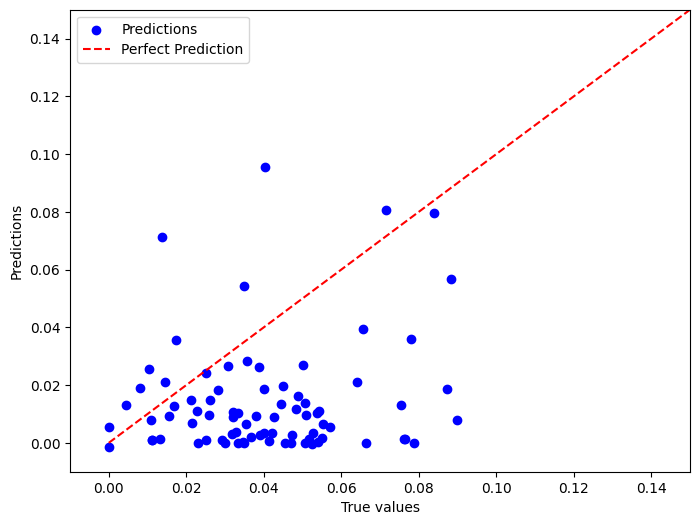

RMSE: 0.10100789513067003
R2: -0.061406305139845685
CORRELATION: 0.32634363723946


In [210]:
fynesse.assess.plot_predictions_against_trues(trues, preds, (-0.01, 0.15))

Now let's try to predict the additional census variable we selected in the previous step.

In [211]:
fynesse.access.db_to_csv(conn, 'census_data_1', 'backup/census_data_1.csv')
census_data_1_df = pd.read_csv('backup/census_data_1.csv')

Data successfully exported to backup/census_data_1.csv


In [217]:
def get_true_MI_AddrYearAgoOutUK_Norm(latitude: float, longitude: float) -> float:
    """
    Args:
    latitude (float): The latitude coordinate.
    longitude (float): The longitude coordinate.

    Returns:
    float: True share of migrants that used to live outside of the UK one year ago in that area (value between 0 and 1).
    """

    oa = oa_by_coordinates(latitude, longitude)

    if oa is None:
        return None
    else:
        query = f"""
        SELECT MI_AddrYearAgoOutUK_Norm
        FROM census_data_1
        WHERE geography_code = '{oa}';
        """
        true_value = fynesse.assess.execute_query(conn, query)[0][0]

        return float(true_value)

In [218]:
def estimate_MI_AddrYearAgoOutUK_Norm(latitude: float, longitude: float) -> float:
    """
    Args:
    latitude (float): The latitude coordinate.
    longitude (float): The longitude coordinate.

    Returns:
    float: Estimated share of migrants that used to live outside of the UK one year ago in that area (value between 0 and 1).
    """
    
    selected_features = ['amenity_nearby', 'tourism_nearby', 'leisure_nearby', 
                         'cuisine_nearby', 'sport_nearby', 'shop_nearby', 
                         'religion_nearby', 'house_nearby', 'building_nearby',
                         'emergency_nearby', 'historic_nearby', 'power_nearby', 
                         'military_nearby']
    
    x = census_data_1_df[selected_features].to_numpy()
    y = census_data_1_df['MI_AddrYearAgoOutUK_Norm'].to_numpy()
    model = sm.OLS(y, x)
    results = model.fit()

    oa = oa_by_coordinates(latitude, longitude)
    
    if oa is None:
        return None
    else:
        x_pred = census_data_1_df[census_data_1_df['geography_code'] == oa][selected_features].to_numpy()
        y_pred = results.get_prediction(x_pred).summary_frame(alpha=0.00)['mean']
        return y_pred[0]

In [219]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

latitude = 51.5
longitude = 0

pred_value = estimate_MI_AddrYearAgoOutUK_Norm(latitude, longitude)

oa = oa_by_coordinates(latitude, longitude)
true_value = get_true_MI_AddrYearAgoOutUK_Norm(latitude, longitude)

print(oa)
print(f"True value: {true_value}")
print(f"Predicted value: {pred_value}")

E00182188
True value: 0.12324
Predicted value: 0.03055019865313184


In [224]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

lat_min, lat_max = 51.3, 53.8
lon_min, lon_max = -2.5, 1.5
samples = 100
    
coords = [(random.uniform(lat_min, lat_max), random.uniform(lon_min, lon_max)) for _ in range(samples)]
trues = []
preds = []

for i in range(samples):
    
    latitude = coords[i][0]
    longitude = coords[i][1]
    oa = oa_by_coordinates(latitude, longitude)
    true_value = get_true_MI_AddrYearAgoOutUK_Norm(latitude, longitude)

    if oa is not None:
        pred_value = estimate_MI_AddrYearAgoOutUK_Norm(latitude, longitude)
        trues.append(true_value)
        preds.append(pred_value)

print(f"Correlation coefficient: {np.corrcoef(trues, preds)[0, 1]}")

Correlation coefficient: 0.17743262001935034


In [225]:
for i in range(len(trues)):
    print(f"{trues[i]} - {preds[i]}")

0.00345 - 9.858428349820988e-07
0.0 - 0.0034315049824812714
0.0051 - 0.0016014329113870954
0.00889 - 0.0038799037454009355
0.0226 - 0.010815702790827782
0.0 - 0.000722852917445034
0.00787 - 0.0034278717422790562
0.00749 - 0.0032903205744513405
0.00847 - 0.008311569521144492
0.00248 - 0.007518009251401445
0.00573 - 0.0005260831712566579
0.02281 - 0.0044832322529039376
0.02367 - 0.0037299867163805202
0.0 - 0.00105413802818328
0.00271 - 0.0012068076531859353
0.0 - 0.00748983899367556
0.00667 - 0.008093639041796906
0.00787 - 0.008895037266547619
0.0 - 0.0005260831712566579
0.00331 - 0.010758579549489122
0.0 - 0.0015999380561395797
0.00415 - 0.005498684877353334
0.00296 - 0.0026781750529566812
0.0 - 7.393821262365741e-06
0.00369 - 0.0060179702458006
0.0 - 0.0005502363207137193
0.0 - 0.0032022865385433748
0.00599 - 0.0015792353566049556
0.003 - 0.003437198021416012
0.02048 - 0.0012190878990307906
0.00338 - 0.0005462929493737909
0.0127 - 0.0006802315605117863
0.00512 - 0.007831766782308753
0.

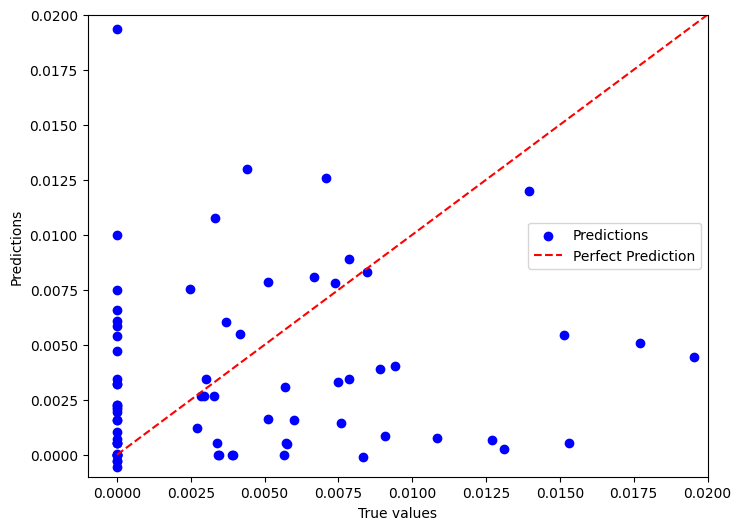

RMSE: 0.13979616951795878
R2: -0.0024870232482430144
CORRELATION: 0.17743262001935034


In [230]:
fynesse.assess.plot_predictions_against_trues(trues, preds, (-0.001, 0.02))

## Discussion

#### Story and structure

Marks awarded for inline explanation and structure, no need for answers here.

#### Design decisions

One of the toughest design decisions I had to face during this project was to decide how to store geometrical data. While it's possible to do simple operations (such as computing area of polygon) in SQL, for more complex operations I needed to use dataframes. Limited time for this task puts further constraints on this topic.

#### Comparison

Not sure what to put here - to be discussed.

#### Reusability

Quite a big number of snippets of code produced during this project can be effectively reused. Most of such pieces of code has been placed into fynesse library, some of them still remain in the code.

# Task 2: miniproject (13 marks)

We expect your miniproject to be more advanced than the example project, and that's why we allocated more marks to it. The first 7 marks will be allocated similarly to Task 1.

6 remaining points are *bonus* - they will be allocated for going far beyond what you did in Task 1, either in data access, assess, address or story.

#### Choosing your topic

You are given a lot of flexibility in choosing a miniproject topic.

Some hints:
- Your project should be based on the Census, Price Paid, OSM and Election datasets.
- It's a good idea to pick something that you are interested in.
- Bear in mind there are no marks dedicated to your overall prediction accuracy, so there is no advantage to picking 'easy' topics. It is perfectly ok to not reach significant predictive power, as long as you followed the proper process.

Some guidelines:
- Do not make a miniproject that furthers discriminatory rhetoric. In general, avoid topics that could be insensitive. If in doubt, message Radzim Sendyka (and *cc* Christian Cabrera) to discuss if this applies to your idea.
- Please avoid any projects that would require approval from the ethics comittee.
- Pick the scope of your projects that will allow you to show your skills. Some projects might not be challenging enough while others might be hard to make any progress in. Don't be scared to report negative results.

Please email Radzim Sendyka (and *cc* Christian Cabrera) with your project idea when you begin working on it, so we can let you know about any potential concerns (eg. potentially insensive, too off-topic, too simple, too complex) as soon as we can. You can change the topic up to the submission deadline, but let us know again in cases of major changes.

Most of the advice from Task 1 still applies, particularly around using an online relational database, structuring your notebook, fynesse, access-assess-address, data readiness levels, hints.

Sources you may want to include in your data include:

  - UK Census Data
    - UK Census 2021 data [here](https://www.ons.gov.uk/search?topics=9731,6646,3845,9497,4262,4128,7755,4994,6885,9724,7367&filter=datasets) or [here](https://www.nomisweb.co.uk/sources/census_2021_bulk).
    - Historical Census data [here](https://www.ons.gov.uk/census/historiccensusdata).
    - Geographic coordinates of Census Output Areas [here](https://www.data.gov.uk/dataset/4d4e021d-fe98-4a0e-88e2-3ead84538537/output-areas-december-2021-boundaries-ew-bgc-v2).
  - Spatial data
    - You should already have a connection to OpenStreetMaps.
    - You might want to also download the entire map for England (or more) [here](https://download.openstreetmap.fr/extracts/) or [here](https://wiki.openstreetmap.org/wiki/Planet.osm).
  - Election data
    - Recent Election Results data [here](https://commonslibrary.parliament.uk/research-briefings/cbp-10009/)
    - Historical Election Results data [here](https://commonslibrary.parliament.uk/research-briefings/cbp-8647/#fullreport).
    - Lookup reference between Output Areas and Parliamentary Constituencies [here](https://geoportal.statistics.gov.uk/datasets/5968b5b2c0f14dd29ba277beaae6dec3_0/explore).
  - Price Paid Data
    - You should have this data already in your database.
  - OSM
    - You should know how to access this data from previous practicals.

Example ideas:

- Are areas correlated in terms of census results? If so, find the areas that are leading change, and the ones that are following.
- Which historical census variables used to predict election results in the past, but don't seem related anymore?
- Census results are only updated once a decade, but new roads and houses are built every year. Can census results, for example those relating to travel, be predicted from basic map information, such as street networks?
- Building new houses is our best way of tackling the housing crisis. Use the information on new builds in the house prices dataset to explore what factors drive new developments, and make predictions for where the next houses will be built.
- House styles differ a lot between regions and inhabitants. Can you make any predictions about the house or area simply from looking at it's geometric shape and orientation?

Note that the ideas are just a starting point question. You should include more in-depth investigations into the data, validate your findings where applicable, and prepare visualisations.

## Title

### How often do unexpected cultural or political shifts lead to unpredictable electoral outcomes? 

## Description

The aim of the project is to investigate how often unexpected factors like region-specific cultural issues influence voting results.

TODO: expand this

## Project plan

- Extract relevant demographic features from census data.
- Add special indices to enrich the dataset.
- Cluster regions based on similarity of demographic profiles.
- Compare clusters to voting patterns.
- Identify demographic profiles strongly associated with specific voting patterns.
- Identify areas with anomalies in voting results (do a thorough analysis in assess).
- Build a model to predict voting results based on census data. 
- Analyse feature importance to identify links between demographic features and voting outcomes. 
- Identify regions where predictions deviate significantly from actual results (make use of LOOCV or something similar to avoid testing on region you used as part of your training, as it might not deviate much in this case).

## Project execution

In [1294]:
conn = fynesse.access.create_connection()

Connection established!


In [1303]:
query = """
SELECT 
    data_oa_with_boundaries.*, 
    data_oa.ShapeArea, 
    data_oa.ShapeLength 
FROM 
    data_oa_with_boundaries 
    JOIN data_oa 
    ON data_oa.OA21CD = data_oa_with_boundaries.OA21CD;
"""

fynesse.assess.execute_query(conn, query)

(('E00000001',
  'E01000001',
  'City of London 001A',
  '',
  532250,
  181864,
  51.5202,
  -0.09523,
  '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed',
  'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))',
  1,
  6949.15,
  421.166),
 ('E00000003',
  'E01000001',
  'City of London 001A',
  '',
  532171,
  181819,
  51.5198,
  -0.09638,
  'f1216dc8-14d1-4857-9230-cab0641758fb',
  'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))',
  2,
  4492.41,
  307.715),
 (

In [1302]:
fynesse.assess.get_summary_on_db(conn)


Table census_data_mi - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK', 'db_id')
(2021, 'E00060274', 'E00060274', 271, 253, 0, 18, 0, 1)
(2021, 'E00060275', 'E00060275', 407, 386, 0, 19, 2, 2)
(2021, 'E00060276', 'E00060276', 257, 245, 0, 12, 0, 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_geography_code (BTREE): Column geography_code

Table census_data_nssec - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_geography_code (BTREE)

In [ ]:
query = """
ALTER TABLE pp_data_subset 
ADD COLUMN latitude FLOAT, 
ADD COLUMN longitude FLOAT;
"""

fynesse.assess.execute_query(conn, query)

In [1280]:
query = """
UPDATE pp_data_subset AS pp
JOIN postcode_data AS pd
ON pp.postcode = pd.postcode
SET 
    pp.latitude = pd.latitude,
    pp.longitude = pd.longitude;
"""

fynesse.assess.execute_query(conn, query)

[]

In [ ]:
"""
Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)

Table prices_coordinates_data - Approx Row Count 2.1M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'easting', 'northing', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '40', '', 'SARGENT SQUARE', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 409865, 238235, 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', '3', '', 'OXFORD ROAD', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 445300, 517686, 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', 'KELSEY PARK MANSIONS, 78', 'FLAT 15', 'WICKHAM ROAD', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 537932, 168705, 3)

Table prices_coordinates_data_old - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
"""

In [1004]:
"""
url = "https://researchbriefings.files.parliament.uk/documents/CBP-10009/HoC-GE2024-results-by-constituency.csv"
file_name = "GE2024_results.csv"
fynesse.access.download_data_csv([url], [file_name])
"""

results2024_df = fynesse.access.csv_to_df("GE2024_results.csv")

In [1207]:
"""
oa_to_pc_gdf = gpd.read_file("OA_to_PC/Output_area_(2021)_to_future_Parliamentary_Constituencies_Lookup_in_England_and_Wales.shp")
oa_to_pc_gdf
"""

'\noa_to_pc_gdf = gpd.read_file("OA_to_PC/Output_area_(2021)_to_future_Parliamentary_Constituencies_Lookup_in_England_and_Wales.shp")\noa_to_pc_gdf\n'

In [1149]:
"""
zip_file_path = "Output_area_(2021)_to_future_Parliamentary_Constituencies_Lookup_in_England_and_Wales.zip"
extraction_folder = "OA_to_PC"

if zipfile.is_zipfile(zip_file_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        os.makedirs(extraction_folder, exist_ok=True)
        zip_ref.extractall(extraction_folder)
    print(f"Extracted files to {extraction_folder}")
else:
    print(f"{zip_file_path} is not a valid zip file.")

oa_to_pc_gdf = gpd.read_file("OA_to_PC/Output_area_(2021)_to_future_Parliamentary_Constituencies_Lookup_in_England_and_Wales.shp")
"""

oa_to_pc_df = fynesse.access.csv_to_df("Output_area_(2021)_to_future_Parliamentary_Constituencies_Lookup_in_England_and_Wales.csv")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fynesse/access.py:111: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  print(f"Error loading CSV file: {e}")


In [1151]:
code = 'TS062'
census = fynesse.access.load_census_data(code, level='oa')
census.columns

Index(['date', 'geography', 'geography code',
       'National Statistics Socio-economic Classification (NS-SEC): Total: All usual residents aged 16 years and over',
       'National Statistics Socio-economic Classification (NS-SEC): L1, L2 and L3 Higher managerial, administrative and professional occupations',
       'National Statistics Socio-economic Classification (NS-SEC): L4, L5 and L6 Lower managerial, administrative and professional occupations',
       'National Statistics Socio-economic Classification (NS-SEC): L7 Intermediate occupations',
       'National Statistics Socio-economic Classification (NS-SEC): L8 and L9 Small employers and own account workers',
       'National Statistics Socio-economic Classification (NS-SEC): L10 and L11 Lower supervisory and technical occupations',
       'National Statistics Socio-economic Classification (NS-SEC): L12 Semi-routine occupations',
       'National Statistics Socio-economic Classification (NS-SEC): L13 Routine occupations',
    

In [1173]:
# oa2021_gdf = oa_data_gdf.copy()
oa2021_gdf = pd.read_csv('uk_oa_with_boundaries.csv')
oa2021_gdf['geometry'] = oa2021_gdf['geometry'].apply(wkt.loads)  # converting WKT strings to geometries
oa2021_gdf = gpd.GeoDataFrame(oa2021_gdf, geometry='geometry')  # converting DataFrame to GeoDataFrame
oa2021_gdf.set_crs("EPSG:27700", inplace=True)  # setting CRS to EPSG:27700 (UK Grid)

# add area
oa2021 = pd.read_csv('uk_oa_list.csv')
oa2021_gdf = oa2021_gdf.merge(oa2021[['OA21CD', 'Shape__Area']], on='OA21CD', how='left')
oa2021_gdf.rename(columns={'Shape__Area': 'AREA'}, inplace=True)

# populate
codes_and_columns = [
    ('TS007A', [8, 11, 14, 17]),  # Age groups
    ('TS021', [4, 10, 19]),      # Ethnic groups
    ('TS054', [4, 7, 9, 12]),        # Tenure
    ('TS066', [4, 16, 28]),     # Economic activity
    ('TS067', [4, 5, 6]),        # Education levels
    ('TS004', [4, 5, 13, 14]),        # Country of birth
    ('TS037', [4, 6, 8])         # Health
]

census_column_titles = []
for (code, column_numbers) in codes_and_columns:
    fynesse.access.download_census_data(code)
    census = fynesse.access.load_census_data(code, level='oa')
    columns_dict = {census.columns[i]: f'census_{code}_{i}' for i in column_numbers}
    for key, value in columns_dict.items():
        census_column_titles.append(value)
        print(value + " -> " + key)
    census.rename(columns=columns_dict, inplace=True)
    oa2021_gdf = oa2021_gdf.merge(
        census[['geography'] + [column for column in columns_dict.values()]], 
        left_on='OA21CD', 
        right_on='geography',
        how='left'
    )
    oa2021_gdf.drop(columns=['geography'], inplace=True)

oa2021_gdf.drop(columns=['LSOA21CD', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'GlobalID'], inplace=True)

grouped_counts = {feature: osm_data_gdf[(osm_data_gdf[feature].notna()) & (osm_data_gdf[feature] != '')].groupby('OA21CD').size() for feature in features_of_interest}

for feature in features_of_interest:
    oa2021_gdf[feature] = oa2021_gdf['OA21CD'].map(grouped_counts[feature]).fillna(0).astype(int)

# merge oa_to_pc_df['OA21CD'] <--> oa2021_gdf['OA21CD']
columns_to_add = ['PCON25CD', 'PCON25NM', 'PCON25NMW', 'LAD21CD', 'LAD21NM']
oa2021_gdf = oa2021_gdf.merge(oa_to_pc_df[['OA21CD'] + columns_to_add], how='left', on='OA21CD')

# print(oa2021_gdf.columns)
oa2021_gdf_features_not_to_sum = ['OA21CD', 'LSOA21NM', 'geometry', 'PCON25CD', 'PCON25NM', 'PCON25NMW', 'LAD21CD', 'LAD21NM']
oa2021_gdf_features_to_sum = [col for col in oa2021_gdf.columns if col not in oa2021_gdf_features_not_to_sum]

# grouping
r = (
    oa2021_gdf.groupby('PCON25CD')
    .agg({feature: (('mean') if feature in ['LAT', 'LONG'] else ('sum')) for feature in oa2021_gdf_features_to_sum})
    .reset_index()  # reseting index to include 'PCON25CD' as a column
)

# const_df['PCON25CD'] <--> results2024_df['ONS ID']
const_df = r.merge(
    results2024_df,
    left_on='PCON25CD',
    right_on='ONS ID',
    how='left'  # using left join to retain all rows from cons_df
)

/var/folders/tq/f7lcjhp564g26624rbp38l240000gn/T/ipykernel_33730/2496680614.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  oa2021_gdf = pd.read_csv('uk_oa_with_boundaries.csv')


Files already exist at: census2021-ts007a.
census_TS007A_8 -> Age: Aged 20 to 24 years
census_TS007A_11 -> Age: Aged 35 to 39 years
census_TS007A_14 -> Age: Aged 50 to 54 years
census_TS007A_17 -> Age: Aged 65 to 69 years
Files already exist at: census2021-ts021.
census_TS021_4 -> Ethnic group: Asian, Asian British or Asian Welsh
census_TS021_10 -> Ethnic group: Black, Black British, Black Welsh, Caribbean or African
census_TS021_19 -> Ethnic group: White
Files already exist at: census2021-ts054.
census_TS054_4 -> Tenure of household: Owned
census_TS054_7 -> Tenure of household: Shared ownership
census_TS054_9 -> Tenure of household: Social rented
census_TS054_12 -> Tenure of household: Private rented
Files already exist at: census2021-ts066.
census_TS066_4 -> Economic activity status: Economically active (excluding full-time students)
census_TS066_16 -> Economic activity status: Economically active and a full-time student
census_TS066_28 -> Economic activity status: Economically inact

In [1175]:
const_df.columns

Index(['PCON25CD', 'LAT', 'LONG', 'AREA', 'census_TS007A_8',
       'census_TS007A_11', 'census_TS007A_14', 'census_TS007A_17',
       'census_TS021_4', 'census_TS021_10', 'census_TS021_19',
       'census_TS054_4', 'census_TS054_7', 'census_TS054_9', 'census_TS054_12',
       'census_TS066_4', 'census_TS066_16', 'census_TS066_28',
       'census_TS067_4', 'census_TS067_5', 'census_TS067_6', 'census_TS004_4',
       'census_TS004_5', 'census_TS004_13', 'census_TS004_14',
       'census_TS037_4', 'census_TS037_6', 'census_TS037_8', 'amenity',
       'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport',
       'shop', 'religion', 'power', 'military', 'house', 'building', 'ONS ID',
       'ONS region ID', 'Constituency name', 'County name', 'Region name',
       'Country name', 'Constituency type', 'Declaration time',
       'Member first name', 'Member surname', 'Member gender', 'Result',
       'First party', 'Second party', 'Electorate', 'Valid votes',
       'Invalid vote

In [1176]:
oa2021_gdf.columns

Index(['OA21CD', 'LSOA21NM', 'LAT', 'LONG', 'geometry', 'AREA',
       'census_TS007A_8', 'census_TS007A_11', 'census_TS007A_14',
       'census_TS007A_17', 'census_TS021_4', 'census_TS021_10',
       'census_TS021_19', 'census_TS054_4', 'census_TS054_7', 'census_TS054_9',
       'census_TS054_12', 'census_TS066_4', 'census_TS066_16',
       'census_TS066_28', 'census_TS067_4', 'census_TS067_5', 'census_TS067_6',
       'census_TS004_4', 'census_TS004_5', 'census_TS004_13',
       'census_TS004_14', 'census_TS037_4', 'census_TS037_6', 'census_TS037_8',
       'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic',
       'sport', 'shop', 'religion', 'power', 'military', 'house', 'building',
       'PCON25CD', 'PCON25NM', 'PCON25NMW', 'LAD21CD', 'LAD21NM'],
      dtype='object')

In [1197]:
labels_df = const_df[['PCON25CD', 'LAT', 'LONG']].copy()
to_cluster_df = const_df[['Con', 'Lab', 'LD', 'RUK', 'Green', 'PC']].copy()
labels_df['cluster_v'] = fynesse.assess.kmeans_clusters(to_cluster_df, 5)
to_cluster_df = const_df[census_column_titles].copy()
labels_df['cluster_c'] = fynesse.assess.kmeans_clusters(to_cluster_df, 5)

In [1203]:
import matplotlib.pyplot as plt

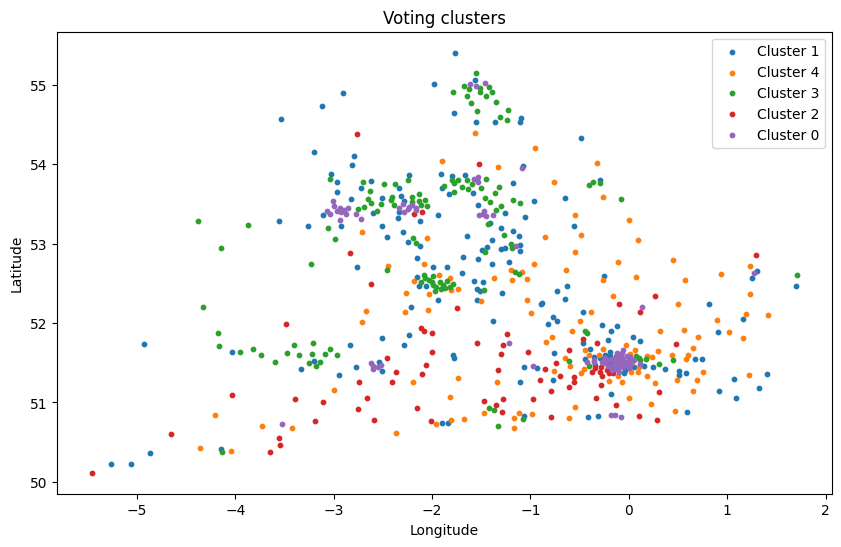

In [1204]:
plt.figure(figsize=(10, 6))
for cluster in labels_df['cluster_v'].unique():
    subset = labels_df[labels_df['cluster_v'] == cluster]
    plt.scatter(subset['LONG'], subset['LAT'], label=f'Cluster {cluster}', s=10)

plt.title('Voting clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

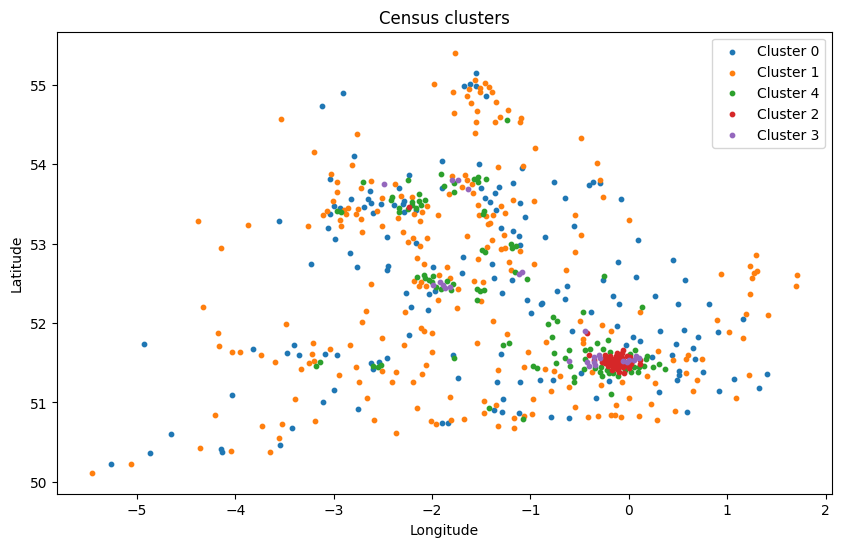

In [1205]:
plt.figure(figsize=(10, 6))
for cluster in labels_df['cluster_c'].unique():
    subset = labels_df[labels_df['cluster_c'] == cluster]
    plt.scatter(subset['LONG'], subset['LAT'], label=f'Cluster {cluster}', s=10)

plt.title('Census clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [1206]:
labels_df.groupby(['cluster_c', 'cluster_v']).size().reset_index(name='count')

,cluster_c,cluster_v,count
0,0,0,11
1,0,1,56
2,0,2,18
3,0,3,35
4,0,4,38
5,1,0,17
6,1,1,78
7,1,2,43
8,1,3,42
9,1,4,61


In [1117]:
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [1146]:
def cross_validation(x, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    r2_list = []
    rmse_list = []
    corr_list = []

    for train_index, test_index in kf.split(x):
        # using iloc[] to correctly index the rows
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = sm.OLS(y_train, x_train)
        results = model.fit()
        y_pred = results.get_prediction(x_test).summary_frame(alpha=0.00)['mean']
        
        r2_list.append(r2_score(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        corr_list.append(np.corrcoef(y_test, y_pred)[0, 1])

    mean_r2 = np.mean(r2_list)
    mean_rmse = np.mean(rmse_list)
    mean_corr = np.mean(corr_list)

    print(f"Mean R2: {mean_r2}")
    print(f"Mean RMSE: {mean_rmse}")
    print(f"Mean Correlation: {mean_corr}")

In [1147]:
for party in ['Con', 'Lab', 'LD', 'RUK', 'Green', 'PC']:
    x = const_df[census_column_titles].copy()
    y = const_df[party].copy()
    print("Party: " + party)
    cross_validation(x, y, 5)

Party: Con
Mean R2: 0.764901775107578
Mean RMSE: 2565.7358202162454
Mean Correlation: 0.8759705944893696
Party: Lab
Mean R2: 0.3460411765284001
Mean RMSE: 4517.004163748594
Mean Correlation: 0.61056020981725
Party: LD
Mean R2: 0.3277474313458829
Mean RMSE: 5472.83198640771
Mean Correlation: 0.594851998839051
Party: RUK
Mean R2: 0.5073951817277161
Mean RMSE: 1997.0693148742223
Mean Correlation: 0.7289889054093976
Party: Green
Mean R2: 0.28639588653492865
Mean RMSE: 2025.7807922890624
Mean Correlation: 0.5543034285556054
Party: PC
Mean R2: 0.27798748756399927
Mean RMSE: 1505.4861997271346
Mean Correlation: 0.5669322894613252


## Conclusions

The below code is for marking purpuses only, and not part of your project. It helps us gather the data we need without asking you for database credentials, and scouring github pages. This is mandatory. If the code does not work for you, let us know immediately.

1) Please re-run the code from Practical 1 to help us see the contents of your database. We recommend you include all data sources there, but some smaller inputs are fine to use as files.

In [ ]:
tables = %sql SHOW TABLES;

for row in tables:
    table_name = row[0]
    print(f"\nTable: {table_name}")

    table_status = %sql SHOW TABLE STATUS LIKE '{table_name}';
    approx_row_count = table_status[0][4] if table_status else 'Unable to fetch row count'
    print("\nApprox Row Count:", approx_row_count//100000/10, "M")

    first_5_rows = %sql SELECT * FROM `{table_name}` LIMIT 5;
    print(first_5_rows)

    indices = %sql SHOW INDEX FROM `{table_name}`;
    if indices:
        print("\nIndices:")
        for index in indices:
            print(f" - {index[2]} ({index[10]}): Column {index[4]}")
    else:
        print("\nNo indices set on this table.")

Unfortunately I can't run the code above, so I'll display same output using different method.

In [1435]:
import yaml

with open("credentials.yaml") as file:
    credentials = yaml.safe_load(file)

conn = pymysql.connect(
    user=credentials["username"],
    passwd=credentials["password"],
    host=credentials["url"],
    port=(int)(credentials["port"]),
    local_infile=1,
    db="ads_2024"
)

In [1436]:
def ex_query(conn, query):
    
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()

    conn.commit()
    return rows

In [1437]:
tables = ex_query(conn, f"SHOW TABLES;")

for row in tables:
    table_name = row[0]
    print(f"\nTable: {table_name}")

    table_status = ex_query(conn, f"SHOW TABLE STATUS LIKE '{table_name}';")
    approx_row_count = table_status[0][4] if table_status else 'Unable to fetch row count'
    print("\nApprox Row Count:", approx_row_count//100000/10, "M")

    first_5_rows = ex_query(conn, f"SELECT * FROM `{table_name}` LIMIT 5;")
    print(first_5_rows)

    indices = ex_query(conn, f"SHOW INDEX FROM `{table_name}`;")
    if indices:
        print("\nIndices:")
        for index in indices:
            print(f" - {index[2]} ({index[10]}): Column {index[4]}")
    else:
        print("\nNo indices set on this table.")


Table: census_data_1

Approx Row Count: 0.1 M
((2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12), (2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5), (2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2), (2021, 'E00000007', 'E00000007', 140, 62, 39, 5, 11, 3, 3, 1, 6, 10, 4, 146, 93, 5, 41, 7), (2021, 'E00000010', 'E00000010', 170, 34, 45, 17, 27, 7, 10, 14, 11, 5, 5, 178, 153, 0, 19, 6))

Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table: data_oa

Approx Row Count: 0.1 M
((1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1), (2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2), (3, 'E00000005', 'E0100000

2) Please paste a link to your fynesse library below, and make sure it's publically accessible. Also run the code below, and make sure it worked, printing out the contents of your library.

In [1249]:
fynesse_url = 'https://github.com/sdenyskov/sd995_ads_2024.git' # '<your-url-library-here>'

In [1250]:
import fynesse
import os

print('FYNESSE STRUCTURE:')
package_path = os.path.dirname(fynesse.__file__)
for root, dirs, files in os.walk(package_path):
    level = root.replace(package_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

print('FILE CONTENTS')
for root, dirs, files in os.walk(package_path):
    for file in files:
        file_path = os.path.join(root, file)
        print(f"--- Contents of {file_path} ---\n")
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                print(f.read())
        except Exception as e:
            print(f"Could not read {file_path}: {e}")
        print("\n" + "-" * 50 + "\n")

FYNESSE STRUCTURE:
fynesse/
    defaults.yml
    address.py
    config.py
    access.py
    __init__.py
    assess.py
    __pycache__/
        address.cpython-310.pyc
        assess.cpython-310.pyc
        config.cpython-310.pyc
        access.cpython-310.pyc
        __init__.cpython-310.pyc
FILE CONTENTS
--- Contents of /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fynesse/defaults.yml ---

# Place config informatio you want everyone to have here.
data_url: https://raw.githubusercontent.com/lawrennd/datasets_mirror/main/


--------------------------------------------------

--- Contents of /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fynesse/address.py ---

from .config import *

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score



def fit_and_predict(x, y, x_pred, design_matrix = lambda x: x.reshape(-